In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
from make_plot_dir import plots_dir
from make_model_dir import model_dir
import json
from make_json_dir import json_dir
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from itertools import product
from functools import partial
from model_objects import LOWOCV, FeatureSelectorNN

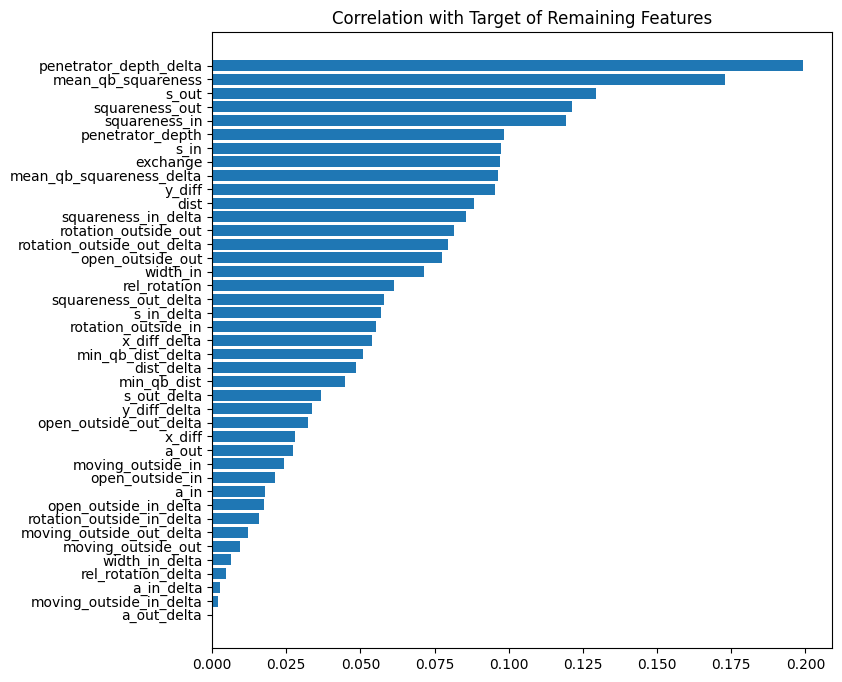

In [2]:
%run rush-win-predictor-2v2-feature-selection-general.ipynb

In [3]:
pro_frames_merge_trunc['stunt_type'] = pro_frames_merge_trunc['stunt_type'].astype('object')
stunt_dummies = pd.get_dummies(pro_frames_merge_trunc['stunt_type'])
pro_frames_merge_trunc = pd.concat((pro_frames_merge_trunc,stunt_dummies), axis = 1)
features2.extend(stunt_dummies.columns.tolist())
features2.remove('stunt_type')
features2

['width_in',
 's_in',
 's_out',
 'a_in',
 'a_out',
 'squareness_in',
 'squareness_out',
 'open_outside_in',
 'open_outside_out',
 'moving_outside_in',
 'moving_outside_out',
 'rotation_outside_in',
 'rotation_outside_out',
 'x_diff',
 'y_diff',
 'dist',
 'min_qb_dist',
 'rel_rotation',
 'penetrator_depth',
 'mean_qb_squareness',
 'exchange',
 'width_in_delta',
 's_in_delta',
 's_out_delta',
 'a_in_delta',
 'a_out_delta',
 'squareness_in_delta',
 'squareness_out_delta',
 'open_outside_in_delta',
 'open_outside_out_delta',
 'moving_outside_in_delta',
 'moving_outside_out_delta',
 'rotation_outside_in_delta',
 'rotation_outside_out_delta',
 'x_diff_delta',
 'y_diff_delta',
 'dist_delta',
 'min_qb_dist_delta',
 'rel_rotation_delta',
 'penetrator_depth_delta',
 'mean_qb_squareness_delta',
 'ET',
 'TE',
 'TT']

In [4]:
pro_frames_merge_trunc[features2].dtypes

width_in                      float64
s_in                          float64
s_out                         float64
a_in                          float64
a_out                         float64
squareness_in                 float64
squareness_out                float64
open_outside_in               float64
open_outside_out              float64
moving_outside_in             float64
moving_outside_out            float64
rotation_outside_in           float64
rotation_outside_out          float64
x_diff                        float64
y_diff                        float64
dist                          float64
min_qb_dist                   float64
rel_rotation                  float64
penetrator_depth              float64
mean_qb_squareness            float64
exchange                        int64
width_in_delta                float64
s_in_delta                    float64
s_out_delta                   float64
a_in_delta                    float64
a_out_delta                   float64
squareness_i

In [5]:
class StuntSequenceDataset(Dataset):
    def __init__(self, sequences, sequence_length, pad_sequence = True):
        self.sequences = sequences
        self.sequence_length = sequence_length
        self.pad_sequence = pad_sequence
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        sequence, label, week = self.sequences[idx]
        if sequence.shape[0] > self.sequence_length:
                sequence = sequence[:self.sequence_length]
        pad_tensor = torch.ones(sequence.shape[0], dtype = torch.long)
        if self.pad_sequence and sequence.shape[0] < self.sequence_length:
            num_padded = self.sequence_length - sequence.shape[0]
            padding_rep = np.zeros((num_padded, sequence.shape[1]))
            pad_tensor = torch.concatenate((pad_tensor, torch.zeros(num_padded, dtype = torch.long)))
            sequence = np.vstack([sequence, padding_rep])
        labels = np.repeat(label, len(sequence))
        label_tensor = torch.LongTensor(labels)
        data_tensor = torch.Tensor(sequence)
            
        return data_tensor, label_tensor, pad_tensor
class SequenceModel(torch.nn.Module):
    def __init__(self, n_features, n_classes, n_hidden, n_layers, dropout = 0.0):
        super().__init__()
        self.n_classes = n_classes
        self.ltsm = torch.nn.LSTM(input_size = n_features, hidden_size = n_hidden, 
                                  num_layers = n_layers, batch_first = True, dropout = dropout)
        self.classifier = torch.nn.Linear(n_hidden, n_classes)
    def forward(self, x):
        unfolded_hiddens, (_, _) = self.ltsm(x)
        return self.classifier(unfolded_hiddens)
    def get_layer_probabilities(self, x):
        fc_output = self.forward(x)
        fc_output_long = fc_output.view([x.size(0) * x.size(1), self.n_classes])
        time_prob = torch.nn.functional.softmax(fc_output_long, dim = 1).detach().cpu().numpy()
        time_prob_win = time_prob[:,1]
        return time_prob_win

def get_unpadded_outputs(model, X, y, pad_tensor):
    fc_output = model(X)
    batch_probs = model.get_layer_probabilities(X)
    fc_output_long = fc_output.view([X.size(0) * X.size(1), model.n_classes])
    y_long = torch.ravel(y)
    pad_tensor_long = torch.ravel(pad_tensor)
    pad_series = pd.Series(pad_tensor_long.numpy())
    unpadded_indices = pad_series[pad_series == 1].index.tolist()
    return fc_output_long[unpadded_indices], batch_probs[unpadded_indices], y_long[unpadded_indices]
    
    
def train_sequence_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    probs = []
    labels = []
    for X, y, pad_tensor in data_loader:
        fc_output_long, batch_probs, y_long = get_unpadded_outputs(model, X, y, pad_tensor)
        probs.extend(batch_probs)
        labels.extend(y_long.numpy())
        loss = loss_function(fc_output_long, y_long)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    train_auc = roc_auc_score(labels, probs)
    print(f"Overall train loss: {avg_loss} , Overall train AUC: {train_auc}")
    return model

def test_sequence_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        probs = []
        labels = []
        for X, y, pad_tensor in data_loader:
            fc_output_long, batch_probs, y_long = get_unpadded_outputs(model, X, y, pad_tensor)
            probs.extend(batch_probs)
            labels.extend(y_long.numpy())
            total_loss += loss_function(fc_output_long, y_long).item()
    avg_loss = total_loss / num_batches
    test_auc = roc_auc_score(labels, probs)
    print(f"Overall test loss: {avg_loss} , Overall test AUC: {test_auc}")
    return avg_loss, test_auc
        
class LOWOCVLSTM(LOWOCV):
    def __init__(self, data, features, target_col, num_weeks, model):
        self.data = data
        self.features = features
        self.target_col = target_col
        self.num_weeks = num_weeks
        self.model = model
        self.probs = []
        self.preds = []
        self.train_aucs = []
    def run_cv(self, scaler, sequence_length, loss_function, optimizer, model_params = {}, eval_metric = 'loss',
               state_dict_fname = 'lstm_state_dict.pt', batch_size = 64, 
               num_epochs = 0, threshold = 0.001, patience = 10):
        self.clear_outputs()
        if isinstance(self.model, partial):
            model = self.model(**model_params)
            optimizer = optimizer(model.parameters())
        else:
            model = self.model
        base_model_path = os.path.join('state_dicts', state_dict_fname)
        torch.save(model.state_dict(), base_model_path)
        model_state_dict = torch.load(base_model_path)
        for week in range(1,self.num_weeks+1):
            print(f'FITTING FOR HOLDOUT WEEK {week}')
            model.load_state_dict(model_state_dict)
            train_sequences, test_sequences = self.sequence_builder_ttstowo(holdout_week = week,
                                                                            scaler = scaler)
            train_dataset = StuntSequenceDataset(train_sequences, sequence_length)
            train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
            test_dataset = StuntSequenceDataset(test_sequences, sequence_length)
            test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
            improvement_index = 0
            ix_epoch = 0
            best_fname = 'best_' + state_dict_fname[:-3] + str(week) + '.pt'
            best_model_path = os.path.join('state_dicts', best_fname)
            while True:
                print(f"Epoch {ix_epoch}\n---------")
                model = train_sequence_model(train_loader, model, loss_function, optimizer)
                avg_loss, test_auc = test_sequence_model(test_loader, model, loss_function)
                new_benchmark = False
                if eval_metric == 'loss':
                    if ix_epoch == 0:
                        best_eval_score = avg_loss
                        torch.save(model.state_dict(), best_fname)
                    else:
                        new_benchmark = avg_loss < best_eval_score * (1.0-threshold)
                        if new_benchmark:
                            best_eval_score = avg_loss
                elif eval_metric == 'auc':
                    if ix_epoch == 0:
                        best_eval_score = test_auc
                        torch.save(model.state_dict(), best_fname)
                    else:
                        new_benchmark = test_auc > best_eval_score * (1.0+threshold)
                        if new_benchmark:
                            best_eval_score = test_auc 
                if ix_epoch == 0 or new_benchmark:
                    torch.save(model.state_dict(), best_model_path)
                    improvement_index = 0
                else:
                    improvement_index += 1
                ix_epoch += 1
                print()
                if num_epochs == 0 and improvement_index == patience:
                    break
                elif ix_epoch == num_epochs:
                    break
            self.infer_best_model(model, best_model_path, train_sequences, test_sequences, 
                                  sequence_length, batch_size = batch_size)
 
    def clear_outputs(self):
        self.probs = []
        self.preds = []
        self.train_aucs = []
    
    def sequence_builder_ttstowo(self, holdout_week, scaler):
        training_data = self.data[(self.data['week'] < holdout_week) |
                                  (self.data['week'].isin(range(holdout_week+1, self.num_weeks+1)))]
        scaler.fit(training_data[self.features])
        sequences = []
        for index, group in self.data.groupby(['gameId', 'playId', 'stuntId']):
            X_scaled = scaler.transform(group[self.features])
            label, week = group.iloc[0][[self.target_col, 'week']]
            sequences.append((X_scaled, label, week))
        train_sequences = [sequence for sequence in sequences if sequence[2] in training_data['week'].unique()]
        test_sequences = [sequence for sequence in sequences if sequence[2] == holdout_week]
        return train_sequences, test_sequences
    
    def infer_best_model(self, model, best_model_path, train_sequences, test_sequences, sequence_length, batch_size = 64):
        best_state = torch.load(best_model_path)
        model.load_state_dict(best_state)
        model.eval()
        train_prob_dataset = StuntSequenceDataset(train_sequences, sequence_length)
        train_prob_loader = DataLoader(train_prob_dataset, batch_size = batch_size)
        train_probs = []
        y_train_long = []
        for X_train, y_train, pad_tensor in train_prob_loader:
            _, batch_probs, y_long = get_unpadded_outputs(model, X_train, y_train, pad_tensor)
            train_probs.extend(batch_probs)
            y_train_long.extend(y_long.numpy())
        self.train_aucs.append(roc_auc_score(y_train_long, train_probs)) 
        test_prob_dataset = StuntSequenceDataset(test_sequences, sequence_length)
        test_prob_loader = DataLoader(test_prob_dataset, batch_size = batch_size)
        test_probs = []
        for X_test, y_test, pad_tensor in test_prob_loader:
            _, batch_probs, _ = get_unpadded_outputs(model, X_test, y_test, pad_tensor)
            test_probs.extend(batch_probs)
        self.probs.extend(test_probs)
        self.preds.extend(np.where(np.array(test_probs) >= 0.5, 1, 0))
        
    def infer_saved_models(self, saved_model_names, scaler, model, sequence_length, batch_size = 64):
        self.clear_outputs()
        for week in range(1,self.num_weeks+1):
            train_sequences, test_sequences = self.sequence_builder_ttstowo(holdout_week = week, scaler = scaler)
            self.infer_best_model(model = model,
                                 best_model_path = saved_model_names[week -1],
                                 train_sequences = train_sequences,
                                 test_sequences = test_sequences,
                                 sequence_length = sequence_length, 
                                 batch_size = batch_size
                                 )
        
        
        
        
        

In [6]:
torch.manual_seed(0)
model = SequenceModel(n_features = len(features2),
                      n_classes = 2,
                      n_hidden = 15,
                      n_layers = 1,
                      dropout = 0.0
                      )
weight = compute_class_weight(class_weight = 'balanced', classes = y.unique(),
                               y = y.values)
loss_function = torch.nn.CrossEntropyLoss(weight = torch.Tensor((weight[1], weight[0])))
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)
scaler = StandardScaler()
sequence_length = pro_frames_merge_trunc['frame_from_snap'].max() + 1
lstmcv = LOWOCVLSTM(data = pro_frames_merge_trunc,
                    features = features2,
                    target_col = 'rush_win',
                    num_weeks = num_weeks,
                    model = model)

In [238]:
lstmcv.run_cv(scaler = scaler,
              sequence_length = sequence_length,
              loss_function = loss_function,
              optimizer = optimizer, 
              num_epochs = 0)

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6754393256627597 , Overall train AUC: 0.5757638720737825
Overall test loss: 0.6358228325843811 , Overall test AUC: 0.6919871467413694

Epoch 1
---------
Overall train loss: 0.6529967418083777 , Overall train AUC: 0.6680711005522878
Overall test loss: 0.6284682949384054 , Overall test AUC: 0.6999301310043669

Epoch 2
---------
Overall train loss: 0.6248704424271216 , Overall train AUC: 0.6894232463816269
Overall test loss: 0.598574697971344 , Overall test AUC: 0.7097253027931121

Epoch 3
---------
Overall train loss: 0.6499538146532499 , Overall train AUC: 0.7055218541273868
Overall test loss: 0.6387043396631876 , Overall test AUC: 0.7146916041855484

Epoch 4
---------
Overall train loss: 0.6040058365234962 , Overall train AUC: 0.7221157759376549
Overall test loss: 0.6057196855545044 , Overall test AUC: 0.7068346378841558

Epoch 5
---------
Overall train loss: 0.602619102367988 , Overall train AUC: 0.7304191758127103
Ove

Overall train loss: 0.5890470926578228 , Overall train AUC: 0.7500832076231505
Overall test loss: 0.6412512063980103 , Overall test AUC: 0.6834891305210093

Epoch 11
---------
Overall train loss: 0.5820098244226896 , Overall train AUC: 0.7598034847971664
Overall test loss: 0.6350769698619843 , Overall test AUC: 0.696196945348025

Epoch 12
---------
Overall train loss: 0.56433288867657 , Overall train AUC: 0.7708495545091297
Overall test loss: 0.6340884268283844 , Overall test AUC: 0.6959531142945538

Epoch 13
---------
Overall train loss: 0.5650116709562448 , Overall train AUC: 0.7792084854112435
Overall test loss: 0.6415177583694458 , Overall test AUC: 0.6927474039716905

Epoch 14
---------
Overall train loss: 0.5436885930024661 , Overall train AUC: 0.7907894889561059
Overall test loss: 0.646022617816925 , Overall test AUC: 0.6982674217078946

Epoch 15
---------
Overall train loss: 0.5433800266339228 , Overall train AUC: 0.7951164713969125
Overall test loss: 0.6449786126613617 , Overa

Overall train loss: 0.5596590133813711 , Overall train AUC: 0.7817889045991867
Overall test loss: 0.6726178228855133 , Overall test AUC: 0.6818455731623987

Epoch 13
---------
Overall train loss: 0.5420454052778391 , Overall train AUC: 0.7939167895824932
Overall test loss: 0.69267937541008 , Overall test AUC: 0.6800859011486026

Epoch 14
---------
Overall train loss: 0.5272208406375005 , Overall train AUC: 0.8040519398669534
Overall test loss: 0.7114004790782928 , Overall test AUC: 0.6644141476588684

Epoch 15
---------
Overall train loss: 0.5183479144023015 , Overall train AUC: 0.8123465989232694
Overall test loss: 0.7015907764434814 , Overall test AUC: 0.6654625321315849

Epoch 16
---------
Overall train loss: 0.508913108935723 , Overall train AUC: 0.8249561357486718
Overall test loss: 0.7153083682060242 , Overall test AUC: 0.6637861582012821

Epoch 17
---------
Overall train loss: 0.4877299987352811 , Overall train AUC: 0.8380760671645843
Overall test loss: 0.7529324591159821 , Over

Overall train loss: 0.5031535487908584 , Overall train AUC: 0.83120980555417
Overall test loss: 0.6037286818027496 , Overall test AUC: 0.7127062770520634

Epoch 17
---------
Overall train loss: 0.49343091478714574 , Overall train AUC: 0.8337065072753325
Overall test loss: 0.6147884726524353 , Overall test AUC: 0.7270191303106405

Epoch 18
---------
Overall train loss: 0.4841640247748448 , Overall train AUC: 0.842980318983955
Overall test loss: 0.7046927213668823 , Overall test AUC: 0.6520796425720793

Epoch 19
---------
Overall train loss: 0.45365331264642567 , Overall train AUC: 0.8648436839675774
Overall test loss: 0.880089670419693 , Overall test AUC: 0.636661994406266

Epoch 20
---------
Overall train loss: 0.45412288491542524 , Overall train AUC: 0.8631691265767685
Overall test loss: 0.8235276937484741 , Overall test AUC: 0.682671592007839

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6942182595913227 , Overall train AUC: 0.5165843974947054
Overall test loss:

In [224]:
lstmcv.get_auc(), lstmcv.get_f1(), lstmcv.get_avg_train_auc()

(0.6543932042658603, 0.49820163487738417, 0.7634490957899496)

In [135]:
lstmcv.get_scores_by_frame('frame_from_overlap')

,count,pred,prob,f1_score,auc_score
frame_from_overlap,,,,,
-22,36,0.138889,0.430133,0.000000,0.430769
-21,93,0.290323,0.449811,0.321429,0.573815
-20,157,0.350318,0.456212,0.403846,0.562358
-19,232,0.331897,0.453162,0.394558,0.599559
-18,329,0.322188,0.454580,0.429907,0.603779
-17,440,0.352273,0.459159,0.375405,0.570430
-16,567,0.375661,0.465875,0.398058,0.554607
-15,664,0.417169,0.471723,0.421471,0.559361
-14,754,0.420424,0.475276,0.410435,0.540702


In [137]:
features_xgb = ['penetrator_depth_delta',
                 'mean_qb_squareness_delta',
                 'exchange',
                 's_in_delta',
                 'penetrator_depth',
                 'TT', 'ET', 'TE',
                 'y_diff_delta',
                 'y_diff',
                 'rel_rotation',
                 'width_in_delta',
                 'min_qb_dist_delta',
                 'open_outside_in',
                 's_out',
                 's_in',
                 'open_outside_in_delta',
                 'x_diff_delta',
                 'squareness_in_delta']
model = SequenceModel(n_features = len(features_xgb),
                      n_classes = 2,
                      n_hidden = 50,
                      n_layers = 2,
                      dropout = 0.1
                      )
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
lstmcv = LOWOCVLSTM(data = pro_frames_merge_trunc,
                    features = features_xgb,
                    target_col = 'rush_win',
                    num_weeks = num_weeks,
                    model = model)
lstmcv.run_cv(scaler = scaler,
              sequence_length = sequence_length,
              loss_function = loss_function,
              optimizer = optimizer, 
              num_epochs = 0)

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6768877001909109 , Overall train AUC: 0.5914928641265182
Overall test loss: 0.6547869642575582 , Overall test AUC: 0.7060822278981626

Epoch 1
---------
Overall train loss: 0.6697772466219388 , Overall train AUC: 0.6409878413320809
Overall test loss: 0.641485353310903 , Overall test AUC: 0.6820398780588284

Epoch 2
---------
Overall train loss: 0.661120396393996 , Overall train AUC: 0.6648873888416023
Overall test loss: 0.6060059368610382 , Overall test AUC: 0.6948086017961604

Epoch 3
---------
Overall train loss: 0.6518777975669274 , Overall train AUC: 0.6626088376800584
Overall test loss: 0.6256196101506551 , Overall test AUC: 0.7188179945620831

Epoch 4
---------
Overall train loss: 0.6540622206834646 , Overall train AUC: 0.6710993037459825
Overall test loss: 0.6057697137196859 , Overall test AUC: 0.723819724808437

Epoch 5
---------
Overall train loss: 0.6158837423874781 , Overall train AUC: 0.6993348025189701
Over

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6922135899464289 , Overall train AUC: 0.5298542745018437
Overall test loss: 0.6869895259539286 , Overall test AUC: 0.605061078943652

Epoch 1
---------
Overall train loss: 0.659797191619873 , Overall train AUC: 0.6413336354236334
Overall test loss: 0.6253435810407003 , Overall test AUC: 0.640706486926786

Epoch 2
---------
Overall train loss: 0.6395096729199091 , Overall train AUC: 0.6747258037163395
Overall test loss: 0.6835183103879293 , Overall test AUC: 0.661061038594226

Epoch 3
---------
Overall train loss: 0.6252808719873428 , Overall train AUC: 0.6983272644194444
Overall test loss: 0.6639982263247172 , Overall test AUC: 0.657593825024714

Epoch 4
---------
Overall train loss: 0.6153654207785925 , Overall train AUC: 0.713182273002886
Overall test loss: 0.6219893495241801 , Overall test AUC: 0.6665728332358222

Epoch 5
---------
Overall train loss: 0.6045626451571783 , Overall train AUC: 0.7218861277878836
Overall

Overall train loss: 0.5335745375889999 , Overall train AUC: 0.7905623389938639
Overall test loss: 0.6412871479988098 , Overall test AUC: 0.6919921575394998

Epoch 19
---------
Overall train loss: 0.516103772016672 , Overall train AUC: 0.8146711037658688
Overall test loss: 0.6997922956943512 , Overall test AUC: 0.6660329421690443

Epoch 20
---------
Overall train loss: 0.4830539043133075 , Overall train AUC: 0.8300418923454854
Overall test loss: 0.7860210835933685 , Overall test AUC: 0.6586142429820524

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6873213786345261 , Overall train AUC: 0.5914937627770149
Overall test loss: 0.6644505560398102 , Overall test AUC: 0.6429095203794913

Epoch 1
---------
Overall train loss: 0.6571109294891357 , Overall train AUC: 0.6518398475622078
Overall test loss: 0.6387587189674377 , Overall test AUC: 0.6998360653078176

Epoch 2
---------
Overall train loss: 0.6448713220082797 , Overall train AUC: 0.675550305484177
Overall test loss: 

In [138]:
lstmcv.get_auc(), lstmcv.get_f1(), lstmcv.get_avg_train_auc()

(0.6708571498860773, 0.49744367661104555, 0.7510807740278002)

In [139]:
lstmcv.get_scores_by_frame('frame_from_overlap')

,count,pred,prob,f1_score,auc_score
frame_from_overlap,,,,,
-22,36,0.277778,0.475331,0.100000,0.376923
-21,93,0.268817,0.474500,0.185185,0.434806
-20,157,0.261146,0.466670,0.200000,0.496977
-19,232,0.262931,0.463378,0.290076,0.529453
-18,329,0.267477,0.461726,0.265306,0.544704
-17,440,0.281818,0.459331,0.323741,0.554536
-16,567,0.303351,0.461012,0.318059,0.534807
-15,664,0.317771,0.460994,0.329519,0.542975
-14,754,0.318302,0.461610,0.361446,0.550239


In [140]:
features_fnn = ['penetrator_depth_delta',
                 'mean_qb_squareness',
                 'y_diff',
                 'exchange',
                 'penetrator_depth',
                 'open_outside_in',
                 's_out_delta',
                 's_in',
                 'squareness_out',
                 's_in_delta',
                 'open_outside_out',
                 'rotation_outside_out_delta',
                 'y_diff_delta',
                 'width_in_delta',
                 'rel_rotation',
                 'min_qb_dist_delta',
                 'dist_delta',
                 'mean_qb_squareness_delta']
model = SequenceModel(n_features = len(features_fnn),
                      n_classes = 2,
                      n_hidden = 50,
                      n_layers = 2,
                      dropout = 0.1
                      )
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
lstmcv = LOWOCVLSTM(data = pro_frames_merge_trunc,
                    features = features_fnn,
                    target_col = 'rush_win',
                    num_weeks = num_weeks,
                    model = model)
lstmcv.run_cv(scaler = scaler,
              sequence_length = sequence_length,
              loss_function = loss_function,
              optimizer = optimizer, 
              num_epochs = 0)

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6755338494594281 , Overall train AUC: 0.6147648069853301
Overall test loss: 0.619713564713796 , Overall test AUC: 0.7163422592073823

Epoch 1
---------
Overall train loss: 0.6456091908308176 , Overall train AUC: 0.6872076385035066
Overall test loss: 0.6301917831103007 , Overall test AUC: 0.7161642910109582

Epoch 2
---------
Overall train loss: 0.6133743020204397 , Overall train AUC: 0.6902585649430366
Overall test loss: 0.6050143440564474 , Overall test AUC: 0.7194588448545769

Epoch 3
---------
Overall train loss: 0.6550178115184491 , Overall train AUC: 0.6923281654814948
Overall test loss: 0.6357256571451823 , Overall test AUC: 0.7281512729669605

Epoch 4
---------
Overall train loss: 0.6366484577839191 , Overall train AUC: 0.6991202382970553
Overall test loss: 0.615286111831665 , Overall test AUC: 0.7320372414929555

Epoch 5
---------
Overall train loss: 0.6374716346080487 , Overall train AUC: 0.7073458167009856
Ove

Overall train loss: 0.5836369349406316 , Overall train AUC: 0.7461881927145088
Overall test loss: 0.6416253447532654 , Overall test AUC: 0.6784862099761135

Epoch 8
---------
Overall train loss: 0.5719377811138446 , Overall train AUC: 0.7628021735361837
Overall test loss: 0.6872123181819916 , Overall test AUC: 0.6701445993300491

Epoch 9
---------
Overall train loss: 0.5742737513322097 , Overall train AUC: 0.7542589213284442
Overall test loss: 0.6439580321311951 , Overall test AUC: 0.6918827222735076

Epoch 10
---------
Overall train loss: 0.5558476218810449 , Overall train AUC: 0.7775312173411435
Overall test loss: 0.697478175163269 , Overall test AUC: 0.6929478130567354

Epoch 11
---------
Overall train loss: 0.5535459357958573 , Overall train AUC: 0.7786131774106416
Overall test loss: 0.6827623248100281 , Overall test AUC: 0.6570624787848195

Epoch 12
---------
Overall train loss: 0.5494491595488328 , Overall train AUC: 0.7840925969302017
Overall test loss: 0.6592116057872772 , Over

Overall train loss: 0.6356724408956674 , Overall train AUC: 0.6896171716023753
Overall test loss: 0.6478882133960724 , Overall test AUC: 0.6628748657769596

Epoch 3
---------
Overall train loss: 0.624405182324923 , Overall train AUC: 0.7106119397098285
Overall test loss: 0.6407855153083801 , Overall test AUC: 0.6552092920693358

Epoch 4
---------
Overall train loss: 0.6144343981376061 , Overall train AUC: 0.7182771990203061
Overall test loss: 0.6409248113632202 , Overall test AUC: 0.6559978524313546

Epoch 5
---------
Overall train loss: 0.6038515430230361 , Overall train AUC: 0.725415533316974
Overall test loss: 0.6475901901721954 , Overall test AUC: 0.6389285166436569

Epoch 6
---------
Overall train loss: 0.6017470680750333 , Overall train AUC: 0.7323810010777284
Overall test loss: 0.6291953921318054 , Overall test AUC: 0.6772551867617733

Epoch 7
---------
Overall train loss: 0.6113055577644935 , Overall train AUC: 0.7462278947253927
Overall test loss: 0.6725732982158661 , Overall 

Overall train loss: 0.5524624173457806 , Overall train AUC: 0.7855057792219039
Overall test loss: 0.6843006014823914 , Overall test AUC: 0.6476174618738398

Epoch 12
---------
Overall train loss: 0.542669218320113 , Overall train AUC: 0.7953491814995931
Overall test loss: 0.6652489900588989 , Overall test AUC: 0.642906653346407



In [141]:
lstmcv.get_auc(), lstmcv.get_f1(), lstmcv.get_avg_train_auc()

(0.6720186080866226, 0.5195806352143078, 0.7475595814721254)

In [142]:
lstmcv.get_scores_by_frame('frame_from_overlap')

,count,pred,prob,f1_score,auc_score
frame_from_overlap,,,,,
-22,36,0.416667,0.481867,0.320000,0.557692
-21,93,0.419355,0.483986,0.441176,0.577586
-20,157,0.350318,0.476541,0.384615,0.567271
-19,232,0.366379,0.473084,0.451613,0.595855
-18,329,0.367781,0.475149,0.410480,0.601433
-17,440,0.386364,0.477018,0.419753,0.571202
-16,567,0.405644,0.482792,0.419580,0.555590
-15,664,0.448795,0.486858,0.435115,0.561492
-14,754,0.457560,0.489938,0.437811,0.548864


In [177]:
model = partial(SequenceModel,
                n_classes = 2,
                n_hidden = 50,
                n_layers = 2,
                dropout = 0.1
                )
weight = compute_class_weight(class_weight = 'balanced', classes = y.unique(),
                               y = y.values)
loss_function = torch.nn.CrossEntropyLoss(weight = torch.Tensor((weight[1], weight[0])))
optimizer = partial(torch.optim.Adam, lr= 0.01)
scaler = StandardScaler()
lstmcv = LOWOCVLSTM(data = pro_frames_merge_trunc,
                 features = features2,
                 target_col = 'rush_win',
                 num_weeks = num_weeks,
                 model = model)
sw_feat_sel = FeatureSelectorNN(lstmcv,
                              scaler = scaler,
                              sequence_length = sequence_length,
                              loss_function = loss_function,
                              optimizer = optimizer
                             )

In [178]:
torch.manual_seed(0)
sorted_features = pd.read_csv('ln_feature_importances_sorted.csv', index_col = 0).iloc[:,0]
start_features = sorted_features[sorted_features > 56.0].index.tolist()
sw_feat_sel.sw_select_cust(primary_selection_heirarchy = sorted_features,
                           start_features = start_features)

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6469878095846909 , Overall train AUC: 0.6036149361131589
Overall test loss: 0.5725458363691965 , Overall test AUC: 0.7190010711048859

Epoch 1
---------
Overall train loss: 0.6297299816058233 , Overall train AUC: 0.6757233982413048
Overall test loss: 0.6450577179590861 , Overall test AUC: 0.7121318282936475

Epoch 2
---------
Overall train loss: 0.6732837420243484 , Overall train AUC: 0.7085405991598357
Overall test loss: 0.5891860723495483 , Overall test AUC: 0.7416040207629563

Epoch 3
---------
Overall train loss: 0.6283639852817242 , Overall train AUC: 0.7107536368269978
Overall test loss: 0.6274309357007345 , Overall test AUC: 0.7158147812474253

Epoch 4
---------
Overall train loss: 0.5939796177240518 , Overall train AUC: 0.714923228766541
Overall test loss: 0.6452890038490295 , Overall test AUC: 0.7302529455384361

Epoch 5
---------
Overall train loss: 0.6244942500041082 , Overall train AUC: 0.7210476973512289
Ov

Overall train loss: 0.4820662278395433 , Overall train AUC: 0.8338821699853579
Overall test loss: 0.8329024612903595 , Overall test AUC: 0.6479766406510623

Epoch 17
---------
Overall train loss: 0.48333980486943173 , Overall train AUC: 0.8396280047956612
Overall test loss: 0.845082014799118 , Overall test AUC: 0.6340713815409037

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.691912000377973 , Overall train AUC: 0.5324741434124363
Overall test loss: 0.6796183983484904 , Overall test AUC: 0.6145222312728226

Epoch 1
---------
Overall train loss: 0.6606541027625402 , Overall train AUC: 0.6387083774649746
Overall test loss: 0.682360311349233 , Overall test AUC: 0.6518708263562449

Epoch 2
---------
Overall train loss: 0.631720170378685 , Overall train AUC: 0.6842854165636567
Overall test loss: 0.6206079920132955 , Overall test AUC: 0.649710871144108

Epoch 3
---------
Overall train loss: 0.6216002603371938 , Overall train AUC: 0.7035979214972923
Overall test loss: 0.6

Overall train loss: 0.5129869259320773 , Overall train AUC: 0.8123074457593187
Overall test loss: 0.6963024735450745 , Overall test AUC: 0.6886327465868998

Epoch 13
---------
Overall train loss: 0.5269343302800105 , Overall train AUC: 0.8155377439755674
Overall test loss: 0.6886480152606964 , Overall test AUC: 0.6700196061512503

Epoch 14
---------
Overall train loss: 0.528583471591656 , Overall train AUC: 0.799395732065459
Overall test loss: 0.6999318599700928 , Overall test AUC: 0.6673248389323516

Epoch 15
---------
Overall train loss: 0.5263108336008512 , Overall train AUC: 0.8035871979041526
Overall test loss: 0.6198277473449707 , Overall test AUC: 0.7037012003374751

Epoch 16
---------
Overall train loss: 0.5101682635454031 , Overall train AUC: 0.8158601171168112
Overall test loss: 0.6752399206161499 , Overall test AUC: 0.6890895842920695

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6888531904954177 , Overall train AUC: 0.5251949886416543
Overall test loss

Epoch 0
---------
Overall train loss: 0.6645803726636447 , Overall train AUC: 0.6027729070428038
Overall test loss: 0.616148849328359 , Overall test AUC: 0.7053813957320589

Epoch 1
---------
Overall train loss: 0.6406870484352112 , Overall train AUC: 0.6818298968573266
Overall test loss: 0.617787758509318 , Overall test AUC: 0.7339741286973717

Epoch 2
---------
Overall train loss: 0.6103497170484983 , Overall train AUC: 0.7041743108038463
Overall test loss: 0.621520201365153 , Overall test AUC: 0.7297933591497074

Epoch 3
---------
Overall train loss: 0.6413714656463037 , Overall train AUC: 0.7092886273348538
Overall test loss: 0.6304516196250916 , Overall test AUC: 0.6933314657658399

Epoch 4
---------
Overall train loss: 0.6300567571933453 , Overall train AUC: 0.6945152429425772
Overall test loss: 0.5860755443572998 , Overall test AUC: 0.7345380242234488

Epoch 5
---------
Overall train loss: 0.6101526709703299 , Overall train AUC: 0.7204305940017771
Overall test loss: 0.5703282554

Overall train loss: 0.5162465709906358 , Overall train AUC: 0.8211774462366821
Overall test loss: 0.682594507932663 , Overall test AUC: 0.663944025742547

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6880028694868088 , Overall train AUC: 0.566083722385737
Overall test loss: 0.6602528691291809 , Overall test AUC: 0.6512428884136623

Epoch 1
---------
Overall train loss: 0.6496862471103668 , Overall train AUC: 0.65424142479925
Overall test loss: 0.6754277944564819 , Overall test AUC: 0.6512023813726875

Epoch 2
---------
Overall train loss: 0.6354049642880758 , Overall train AUC: 0.6854743251437152
Overall test loss: 0.6607947746912638 , Overall test AUC: 0.6535929272499849

Epoch 3
---------
Overall train loss: 0.6249606112639109 , Overall train AUC: 0.709850366628759
Overall test loss: 0.6099343498547872 , Overall test AUC: 0.6783548656364112

Epoch 4
---------
Overall train loss: 0.6162850509087244 , Overall train AUC: 0.7129952231564685
Overall test loss: 0.6612

Overall train loss: 0.5173798845364497 , Overall train AUC: 0.8151972968758483
Overall test loss: 0.6743956804275513 , Overall test AUC: 0.6957571138211383

Epoch 16
---------
Overall train loss: 0.48983128254230207 , Overall train AUC: 0.8260421294010037
Overall test loss: 0.714295357465744 , Overall test AUC: 0.6574143848749809

Epoch 17
---------
Overall train loss: 0.47753910376475406 , Overall train AUC: 0.8477661227740214
Overall test loss: 0.7903063297271729 , Overall test AUC: 0.6125711861481822

Epoch 18
---------
Overall train loss: 0.49770694283338696 , Overall train AUC: 0.826120554929484
Overall test loss: 0.7158627510070801 , Overall test AUC: 0.6746879314312011

Epoch 19
---------
Overall train loss: 0.46030575037002563 , Overall train AUC: 0.852265196610716
Overall test loss: 0.7469919919967651 , Overall test AUC: 0.6650799585826046

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6887266956842862 , Overall train AUC: 0.5542702524353409
Overall test l

Overall train loss: 0.5946854330026187 , Overall train AUC: 0.7362447041287137
Overall test loss: 0.5900932749112447 , Overall test AUC: 0.7137546345884485

Epoch 7
---------
Overall train loss: 0.5823510197492746 , Overall train AUC: 0.7482306732287987
Overall test loss: 0.6029588182767233 , Overall test AUC: 0.719373156463706

Epoch 8
---------
Overall train loss: 0.5551395588196241 , Overall train AUC: 0.7527418827683551
Overall test loss: 0.7149183948834738 , Overall test AUC: 0.6876587295048199

Epoch 9
---------
Overall train loss: 0.5505282512077918 , Overall train AUC: 0.7782163673700815
Overall test loss: 0.6806752681732178 , Overall test AUC: 0.693597594133641

Epoch 10
---------
Overall train loss: 0.5798973120175875 , Overall train AUC: 0.7562912258073786
Overall test loss: 0.5897676845391592 , Overall test AUC: 0.7197188761637967

Epoch 11
---------
Overall train loss: 0.5539100697407355 , Overall train AUC: 0.7733554263218595
Overall test loss: 0.6542345682779948 , Overal

Overall train loss: 0.4894353027145068 , Overall train AUC: 0.8320800868927074
Overall test loss: 0.7193264365196228 , Overall test AUC: 0.6433069759113925

Epoch 15
---------
Overall train loss: 0.45598499725262326 , Overall train AUC: 0.854504767084692
Overall test loss: 0.8613475958506266 , Overall test AUC: 0.6013695793067968

Epoch 16
---------
Overall train loss: 0.43740466237068176 , Overall train AUC: 0.8678520945939497
Overall test loss: 0.9193807045618693 , Overall test AUC: 0.6412787867936329

Epoch 17
---------
Overall train loss: 0.4346668943762779 , Overall train AUC: 0.8679014146847548
Overall test loss: 0.8614862561225891 , Overall test AUC: 0.5996232057114612

Epoch 18
---------
Overall train loss: 0.4309138258298238 , Overall train AUC: 0.8747931939250573
Overall test loss: 0.8995352387428284 , Overall test AUC: 0.5724704062178465

Epoch 19
---------
Overall train loss: 0.4359292487303416 , Overall train AUC: 0.8704253921535461
Overall test loss: 0.9496792753537496 , 

Overall train loss: 0.544988235602012 , Overall train AUC: 0.7876903898864205
Overall test loss: 0.640043318271637 , Overall test AUC: 0.7149685920273068

Epoch 10
---------
Overall train loss: 0.5517923556841337 , Overall train AUC: 0.7818391263373067
Overall test loss: 0.6372817754745483 , Overall test AUC: 0.6937016956411703

Epoch 11
---------
Overall train loss: 0.5371068028303293 , Overall train AUC: 0.797508366729422
Overall test loss: 0.6075926423072815 , Overall test AUC: 0.7198136287240187

Epoch 12
---------
Overall train loss: 0.517782387825159 , Overall train AUC: 0.8077745015574009
Overall test loss: 0.6429351568222046 , Overall test AUC: 0.6993919572228604

Epoch 13
---------
Overall train loss: 0.5061260301333207 , Overall train AUC: 0.8192868505462049
Overall test loss: 0.6539539694786072 , Overall test AUC: 0.712561891227182

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.684437829714555 , Overall train AUC: 0.5771737019139246
Overall test loss: 0.

Overall train loss: 0.59871650659121 , Overall train AUC: 0.7359003214181543
Overall test loss: 0.6918621361255646 , Overall test AUC: 0.6121623592089025

Epoch 6
---------
Overall train loss: 0.5841664030001714 , Overall train AUC: 0.7474294890827272
Overall test loss: 0.7500565052032471 , Overall test AUC: 0.6108457601741241

Epoch 7
---------
Overall train loss: 0.5773804371173565 , Overall train AUC: 0.7567067786043277
Overall test loss: 0.7522085011005402 , Overall test AUC: 0.5939821252654003

Epoch 8
---------
Overall train loss: 0.5576543922607715 , Overall train AUC: 0.7754482840719099
Overall test loss: 0.7839751839637756 , Overall test AUC: 0.5988484204012391

Epoch 9
---------
Overall train loss: 0.5457268678225003 , Overall train AUC: 0.7882661330828339
Overall test loss: 0.868071973323822 , Overall test AUC: 0.5620775377962081

Epoch 10
---------
Overall train loss: 0.5670697436882899 , Overall train AUC: 0.7702914788976796
Overall test loss: 0.7376650869846344 , Overall 

Overall train loss: 0.5143628326746134 , Overall train AUC: 0.81011723005573
Overall test loss: 0.7790866196155548 , Overall test AUC: 0.67735463508281

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6779506206512451 , Overall train AUC: 0.5796819837196125
Overall test loss: 0.6815584301948547 , Overall test AUC: 0.6248274275195581

Epoch 1
---------
Overall train loss: 0.6435032349366409 , Overall train AUC: 0.679937616380333
Overall test loss: 0.6532822847366333 , Overall test AUC: 0.6598073899371071

Epoch 2
---------
Overall train loss: 0.6316953118030841 , Overall train AUC: 0.6955256126695807
Overall test loss: 0.6524316370487213 , Overall test AUC: 0.6751160070562969

Epoch 3
---------
Overall train loss: 0.6131275754708511 , Overall train AUC: 0.7162450273742198
Overall test loss: 0.6524461805820465 , Overall test AUC: 0.6576377703635526

Epoch 4
---------
Overall train loss: 0.6086989045143127 , Overall train AUC: 0.7243093826614829
Overall test loss: 0.637

Overall train loss: 0.6422720138843243 , Overall train AUC: 0.7039911536995186
Overall test loss: 0.5947119394938151 , Overall test AUC: 0.7268392518744335

Epoch 3
---------
Overall train loss: 0.6253837026082553 , Overall train AUC: 0.705373373362953
Overall test loss: 0.6084398825963339 , Overall test AUC: 0.7215509598747631

Epoch 4
---------
Overall train loss: 0.5969217213300558 , Overall train AUC: 0.727269753297172
Overall test loss: 0.6392226219177246 , Overall test AUC: 0.7154974046304687

Epoch 5
---------
Overall train loss: 0.6474481866909907 , Overall train AUC: 0.7240854877544181
Overall test loss: 0.5866746306419373 , Overall test AUC: 0.7312772513800774

Epoch 6
---------
Overall train loss: 0.6406398507264944 , Overall train AUC: 0.7326347191667062
Overall test loss: 0.6115604043006897 , Overall test AUC: 0.6829865699925847

Epoch 7
---------
Overall train loss: 0.593096422461363 , Overall train AUC: 0.7252515946169502
Overall test loss: 0.6449342966079712 , Overall t

Overall train loss: 0.6613590518633524 , Overall train AUC: 0.6383753679082513
Overall test loss: 0.6662944356600443 , Overall test AUC: 0.6864036304396071

Epoch 2
---------
Overall train loss: 0.6467500030994415 , Overall train AUC: 0.6677562139953035
Overall test loss: 0.6507599552472433 , Overall test AUC: 0.6635469415135069

Epoch 3
---------
Overall train loss: 0.6281634469827017 , Overall train AUC: 0.7072625500845332
Overall test loss: 0.6579177379608154 , Overall test AUC: 0.6747284609720177

Epoch 4
---------
Overall train loss: 0.61310446759065 , Overall train AUC: 0.7164801427132698
Overall test loss: 0.6157127022743225 , Overall test AUC: 0.6829063124155184

Epoch 5
---------
Overall train loss: 0.6039803077777227 , Overall train AUC: 0.7283308437449307
Overall test loss: 0.6456196506818136 , Overall test AUC: 0.6692715163314302

Epoch 6
---------
Overall train loss: 0.5920292809605598 , Overall train AUC: 0.7435898574428718
Overall test loss: 0.6455266276995341 , Overall 

Overall train loss: 0.5916386246681213 , Overall train AUC: 0.7440585738733535
Overall test loss: 0.6049190163612366 , Overall test AUC: 0.7194486083802182

Epoch 6
---------
Overall train loss: 0.5889708262223464 , Overall train AUC: 0.7447078277226548
Overall test loss: 0.5925987958908081 , Overall test AUC: 0.7335132478050109

Epoch 7
---------
Overall train loss: 0.5830292426622831 , Overall train AUC: 0.7525499843403334
Overall test loss: 0.6237329244613647 , Overall test AUC: 0.7097122990765797

Epoch 8
---------
Overall train loss: 0.5753706005903391 , Overall train AUC: 0.7616370063714826
Overall test loss: 0.6609110534191132 , Overall test AUC: 0.7089530567614747

Epoch 9
---------
Overall train loss: 0.5466410150894752 , Overall train AUC: 0.7855753126798626
Overall test loss: 0.650624543428421 , Overall test AUC: 0.7085904698866328

Epoch 10
---------
Overall train loss: 0.5295790410958804 , Overall train AUC: 0.8058434502793516
Overall test loss: 0.719763308763504 , Overall

Epoch 0
---------
Overall train loss: 0.6830504215680636 , Overall train AUC: 0.5650188145958754
Overall test loss: 0.6677370667457581 , Overall test AUC: 0.6506602555667387

Epoch 1
---------
Overall train loss: 0.6523458178226764 , Overall train AUC: 0.6621491027603678
Overall test loss: 0.6583384573459625 , Overall test AUC: 0.6543461638315806

Epoch 2
---------
Overall train loss: 0.6348000856546255 , Overall train AUC: 0.6933443212787843
Overall test loss: 0.6530805826187134 , Overall test AUC: 0.6629463793526543

Epoch 3
---------
Overall train loss: 0.6151896761013911 , Overall train AUC: 0.7177718637272024
Overall test loss: 0.6911281645298004 , Overall test AUC: 0.6350865462925752

Epoch 4
---------
Overall train loss: 0.6024486651787391 , Overall train AUC: 0.7298698032021198
Overall test loss: 0.7078472971916199 , Overall test AUC: 0.6308401409778113

Epoch 5
---------
Overall train loss: 0.5929027291444632 , Overall train AUC: 0.7416745308781731
Overall test loss: 0.6858631

Overall train loss: 0.5601310982153966 , Overall train AUC: 0.7768032099776652
Overall test loss: 0.6791746318340302 , Overall test AUC: 0.6977327302899163

Epoch 10
---------
Overall train loss: 0.5425462974951818 , Overall train AUC: 0.7939109406257191
Overall test loss: 0.6750198006629944 , Overall test AUC: 0.6898122539290015

Epoch 11
---------
Overall train loss: 0.5232169032096863 , Overall train AUC: 0.8050793188726066
Overall test loss: 0.7039686441421509 , Overall test AUC: 0.6955077603878567

Epoch 12
---------
Overall train loss: 0.5032274333330301 , Overall train AUC: 0.8192490113020952
Overall test loss: 0.7912440598011017 , Overall test AUC: 0.6593206000065076

Epoch 13
---------
Overall train loss: 0.5176124160106366 , Overall train AUC: 0.8097527425660832
Overall test loss: 0.696379542350769 , Overall test AUC: 0.7052119871148278

Epoch 14
---------
Overall train loss: 0.4872384231824141 , Overall train AUC: 0.833788596632116
Overall test loss: 0.8037177622318268 , Ove

Overall train loss: 0.4668983335678394 , Overall train AUC: 0.84925589371833
Overall test loss: 0.8103279769420624 , Overall test AUC: 0.6826910597595084

Epoch 18
---------
Overall train loss: 0.47529531671450687 , Overall train AUC: 0.847733219476972
Overall test loss: 0.6252378523349762 , Overall test AUC: 0.7379632513740989

Epoch 19
---------
Overall train loss: 0.4785323486878322 , Overall train AUC: 0.8424388324144971
Overall test loss: 0.7328210771083832 , Overall test AUC: 0.7059744907560626

Epoch 20
---------
Overall train loss: 0.4428864602859204 , Overall train AUC: 0.863451521145661
Overall test loss: 0.7268353402614594 , Overall test AUC: 0.7031338213249752

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6812088168584384 , Overall train AUC: 0.5920995936811739
Overall test loss: 0.6664292812347412 , Overall test AUC: 0.610675324835501

Epoch 1
---------
Overall train loss: 0.6490115798436679 , Overall train AUC: 0.6676938852541373
Overall test loss: 0

Overall train loss: 0.5693513796879694 , Overall train AUC: 0.7656813603859327
Overall test loss: 0.691550612449646 , Overall test AUC: 0.6378321282883856

Epoch 8
---------
Overall train loss: 0.5586304297814002 , Overall train AUC: 0.7810354998626428
Overall test loss: 0.6627477705478668 , Overall test AUC: 0.6332421695788093

Epoch 9
---------
Overall train loss: 0.5549856080458715 , Overall train AUC: 0.7780108384760395
Overall test loss: 0.7389268279075623 , Overall test AUC: 0.6205207359013298

Epoch 10
---------
Overall train loss: 0.5445664066534776 , Overall train AUC: 0.791423771267726
Overall test loss: 0.7064394354820251 , Overall test AUC: 0.6203037922462205

Epoch 11
---------
Overall train loss: 0.5254386686361753 , Overall train AUC: 0.8097756597596897
Overall test loss: 0.7308256328105927 , Overall test AUC: 0.6129469128206588

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6902726934506342 , Overall train AUC: 0.5673248606787145
Overall test loss: 

Overall train loss: 0.6228697299957275 , Overall train AUC: 0.7069498995563647
Overall test loss: 0.6517916023731232 , Overall test AUC: 0.6514062260315998

Epoch 4
---------
Overall train loss: 0.6116039248613211 , Overall train AUC: 0.7285668875728626
Overall test loss: 0.6395657658576965 , Overall test AUC: 0.6468299394078847

Epoch 5
---------
Overall train loss: 0.5980849311901972 , Overall train AUC: 0.7343765775323008
Overall test loss: 0.6574237942695618 , Overall test AUC: 0.7005553478294217

Epoch 6
---------
Overall train loss: 0.5944638848304749 , Overall train AUC: 0.739184845158629
Overall test loss: 0.6487562358379364 , Overall test AUC: 0.6692737095413407

Epoch 7
---------
Overall train loss: 0.5829593860186063 , Overall train AUC: 0.7501880637057227
Overall test loss: 0.6328065097332001 , Overall test AUC: 0.6843634951679706

Epoch 8
---------
Overall train loss: 0.5645976525086623 , Overall train AUC: 0.7664215534292844
Overall test loss: 0.6638469696044922 , Overall

Overall train loss: 0.4948504612996028 , Overall train AUC: 0.8287432790914141
Overall test loss: 0.6567742824554443 , Overall test AUC: 0.6767428881529856

Epoch 15
---------
Overall train loss: 0.47823949043567365 , Overall train AUC: 0.8421062110287589
Overall test loss: 0.8071094751358032 , Overall test AUC: 0.636941520359647

Epoch 16
---------
Overall train loss: 0.48648531849567705 , Overall train AUC: 0.8364284828155987
Overall test loss: 0.7764877676963806 , Overall test AUC: 0.6487743510998464

Epoch 17
---------
Overall train loss: 0.4771646490463844 , Overall train AUC: 0.8418094958097235
Overall test loss: 0.6992144584655762 , Overall test AUC: 0.6720730887585642

Test score = 0.6712
Failed to add one of 3 candidates
Testing features: ['penetrator_depth_delta', 'mean_qb_squareness', 'y_diff', 'exchange', 'penetrator_depth', 'open_outside_in', 's_out_delta', 's_in', 'squareness_out', 's_in_delta', 'open_outside_out', 'rotation_outside_out_delta', 'y_diff_delta', 'width_in_d

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6836031575997671 , Overall train AUC: 0.586796881031505
Overall test loss: 0.6781359314918518 , Overall test AUC: 0.6427922054996268

Epoch 1
---------
Overall train loss: 0.6491928944985071 , Overall train AUC: 0.6598177883693717
Overall test loss: 0.6382971405982971 , Overall test AUC: 0.6703306887647024

Epoch 2
---------
Overall train loss: 0.6282395571470261 , Overall train AUC: 0.6951325998589521
Overall test loss: 0.5974666674931844 , Overall test AUC: 0.6718070679585209

Epoch 3
---------
Overall train loss: 0.612670029203097 , Overall train AUC: 0.7128854307898761
Overall test loss: 0.6250423789024353 , Overall test AUC: 0.6638035386446628

Epoch 4
---------
Overall train loss: 0.6001815795898438 , Overall train AUC: 0.7326772736578125
Overall test loss: 0.6832822759946188 , Overall test AUC: 0.6528978453406501

Epoch 5
---------
Overall train loss: 0.582317849000295 , Overall train AUC: 0.7462784231623673
Over

Overall train loss: 0.6433819165596595 , Overall train AUC: 0.6745691935314266
Overall test loss: 0.6293869316577911 , Overall test AUC: 0.7082952089863142

Epoch 3
---------
Overall train loss: 0.6235268941292396 , Overall train AUC: 0.7015217514142207
Overall test loss: 0.6420390009880066 , Overall test AUC: 0.7144640527965426

Epoch 4
---------
Overall train loss: 0.6240718777363117 , Overall train AUC: 0.7035115276253273
Overall test loss: 0.6325874626636505 , Overall test AUC: 0.6982498491249245

Epoch 5
---------
Overall train loss: 0.605653675702902 , Overall train AUC: 0.7267084582738741
Overall test loss: 0.6281600892543793 , Overall test AUC: 0.7207440250225501

Epoch 6
---------
Overall train loss: 0.5971006934459393 , Overall train AUC: 0.7352861459795168
Overall test loss: 0.630102127790451 , Overall test AUC: 0.6907661209206948

Epoch 7
---------
Overall train loss: 0.5799154272446265 , Overall train AUC: 0.75789082983361
Overall test loss: 0.5949419438838959 , Overall te

Overall train loss: 0.5546927406237676 , Overall train AUC: 0.7760258862614331
Overall test loss: 0.6905457774798075 , Overall test AUC: 0.717126143198484

FITTING FOR HOLDOUT WEEK 2
Epoch 0
---------
Overall train loss: 0.6786887691571162 , Overall train AUC: 0.5932669963633092
Overall test loss: 0.6900414526462555 , Overall test AUC: 0.6375397878219924

Epoch 1
---------
Overall train loss: 0.6382619188382075 , Overall train AUC: 0.6815211156636659
Overall test loss: 0.6579486131668091 , Overall test AUC: 0.6716454642772042

Epoch 2
---------
Overall train loss: 0.6315390651042645 , Overall train AUC: 0.6879711364120811
Overall test loss: 0.6710944771766663 , Overall test AUC: 0.6388531860487447

Epoch 3
---------
Overall train loss: 0.6274810891885024 , Overall train AUC: 0.7068117032301386
Overall test loss: 0.6535793840885162 , Overall test AUC: 0.6516532173455344

Epoch 4
---------
Overall train loss: 0.6005224631382868 , Overall train AUC: 0.7342266101593007
Overall test loss: 0

Overall train loss: 0.6377013279841497 , Overall train AUC: 0.672972524447567
Overall test loss: 0.643330454826355 , Overall test AUC: 0.6832785605049947

Epoch 3
---------
Overall train loss: 0.6175352197427016 , Overall train AUC: 0.7077019092047724
Overall test loss: 0.6477274596691132 , Overall test AUC: 0.6893043308495753

Epoch 4
---------
Overall train loss: 0.5998443640195407 , Overall train AUC: 0.7289976391270878
Overall test loss: 0.642602801322937 , Overall test AUC: 0.7052751114437249

Epoch 5
---------
Overall train loss: 0.5896167892676133 , Overall train AUC: 0.7468523254223853
Overall test loss: 0.6539994478225708 , Overall test AUC: 0.6865792470634172

Epoch 6
---------
Overall train loss: 0.5866262087455163 , Overall train AUC: 0.7483745164228763
Overall test loss: 0.6654974520206451 , Overall test AUC: 0.6908996843783555

Epoch 7
---------
Overall train loss: 0.5774842065114242 , Overall train AUC: 0.7622174812528263
Overall test loss: 0.6737414598464966 , Overall t

Overall train loss: 0.5771054579661443 , Overall train AUC: 0.7557413855979717
Overall test loss: 0.6440443396568298 , Overall test AUC: 0.7219615706582047

Epoch 9
---------
Overall train loss: 0.5642265769151541 , Overall train AUC: 0.7731920183687087
Overall test loss: 0.6443063318729401 , Overall test AUC: 0.6933674992375131

Epoch 10
---------
Overall train loss: 0.548898153580152 , Overall train AUC: 0.7836808148213421
Overall test loss: 0.623697817325592 , Overall test AUC: 0.7252682493948773

Epoch 11
---------
Overall train loss: 0.5265768147431887 , Overall train AUC: 0.8021314467402387
Overall test loss: 0.6845972537994385 , Overall test AUC: 0.6839004938319674

Epoch 12
---------
Overall train loss: 0.5235137182932633 , Overall train AUC: 0.8046381291918239
Overall test loss: 0.6833867728710175 , Overall test AUC: 0.6983877456992491

Epoch 13
---------
Overall train loss: 0.525650109236057 , Overall train AUC: 0.8030112180759784
Overall test loss: 0.6810953617095947 , Overa

Overall train loss: 0.6258581097309406 , Overall train AUC: 0.7024558713240705
Overall test loss: 0.6668611466884613 , Overall test AUC: 0.6289281916501588

Epoch 3
---------
Overall train loss: 0.6037154793739319 , Overall train AUC: 0.7337337194202717
Overall test loss: 0.724666953086853 , Overall test AUC: 0.6434306971715525

Epoch 4
---------
Overall train loss: 0.6023043348239019 , Overall train AUC: 0.7316963861445256
Overall test loss: 0.7222879827022552 , Overall test AUC: 0.6123821480267019

Epoch 5
---------
Overall train loss: 0.5846376235668476 , Overall train AUC: 0.7526140039607441
Overall test loss: 0.7513354420661926 , Overall test AUC: 0.5917234217349091

Epoch 6
---------
Overall train loss: 0.5710019927758437 , Overall train AUC: 0.7686077577544976
Overall test loss: 0.7308520674705505 , Overall test AUC: 0.6208322812158802

Epoch 7
---------
Overall train loss: 0.5432132207430326 , Overall train AUC: 0.7910363781771572
Overall test loss: 0.8402824103832245 , Overall

Overall train loss: 0.552433573282682 , Overall train AUC: 0.7733648081294573
Overall test loss: 0.7216703593730927 , Overall test AUC: 0.6769928090326359

Epoch 9
---------
Overall train loss: 0.5468191252304957 , Overall train AUC: 0.7893010366028105
Overall test loss: 0.7474590837955475 , Overall test AUC: 0.6604822178114731

Epoch 10
---------
Overall train loss: 0.5363587003487807 , Overall train AUC: 0.7931812150303059
Overall test loss: 0.7169615626335144 , Overall test AUC: 0.6789008557576547

Epoch 11
---------
Overall train loss: 0.5280136282627399 , Overall train AUC: 0.8004731630561641
Overall test loss: 0.7920572459697723 , Overall test AUC: 0.659763121075066

Epoch 12
---------
Overall train loss: 0.5206620051310613 , Overall train AUC: 0.8021291148239509
Overall test loss: 0.7616976499557495 , Overall test AUC: 0.6660527771450884

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6835188361314627 , Overall train AUC: 0.5626905008438242
Overall test loss:

Overall train loss: 0.6002059808144202 , Overall train AUC: 0.737249236248614
Overall test loss: 0.7060168385505676 , Overall test AUC: 0.6375544989793968

Epoch 7
---------
Overall train loss: 0.5800417845065777 , Overall train AUC: 0.7548013059770424
Overall test loss: 0.6748323738574982 , Overall test AUC: 0.6505022847945534

Epoch 8
---------
Overall train loss: 0.5651184824796823 , Overall train AUC: 0.7703409249656124
Overall test loss: 0.7107745110988617 , Overall test AUC: 0.6249119691167311

Epoch 9
---------
Overall train loss: 0.5591344374876756 , Overall train AUC: 0.7746203353026637
Overall test loss: 0.7227078080177307 , Overall test AUC: 0.6368875609741056

Epoch 10
---------
Overall train loss: 0.5420993130940658 , Overall train AUC: 0.7949857991916318
Overall test loss: 0.6787099242210388 , Overall test AUC: 0.6621001609531385

Epoch 11
---------
Overall train loss: 0.5244886645903954 , Overall train AUC: 0.8085703634004886
Overall test loss: 0.7646653354167938 , Overa

Overall train loss: 0.5818712688409365 , Overall train AUC: 0.7536104635961959
Overall test loss: 0.6568051874637604 , Overall test AUC: 0.6872252986408506

Epoch 9
---------
Overall train loss: 0.5685257178086501 , Overall train AUC: 0.7754066026818657
Overall test loss: 0.6866948902606964 , Overall test AUC: 0.6757593938627223

Epoch 10
---------
Overall train loss: 0.5827315014142257 , Overall train AUC: 0.7545190578711125
Overall test loss: 0.6845507919788361 , Overall test AUC: 0.6351318796159326

Epoch 11
---------
Overall train loss: 0.5451719737969912 , Overall train AUC: 0.7886174348669288
Overall test loss: 0.7294616103172302 , Overall test AUC: 0.6788816004001502

Epoch 12
---------
Overall train loss: 0.5400837132563958 , Overall train AUC: 0.7942201969042268
Overall test loss: 0.6870349049568176 , Overall test AUC: 0.6542438085074492

Epoch 13
---------
Overall train loss: 0.5077517170172471 , Overall train AUC: 0.8127427207683013
Overall test loss: 0.7012126743793488 , Ov

Overall train loss: 0.6235891809830298 , Overall train AUC: 0.6986497695824427
Overall test loss: 0.6641179919242859 , Overall test AUC: 0.6671479521398989

Epoch 3
---------
Overall train loss: 0.6061819631319779 , Overall train AUC: 0.7167508339129266
Overall test loss: 0.6521334052085876 , Overall test AUC: 0.6438612133762847

Epoch 4
---------
Overall train loss: 0.6135000769908612 , Overall train AUC: 0.7279842412973077
Overall test loss: 0.6417933404445648 , Overall test AUC: 0.6743523738303421

Epoch 5
---------
Overall train loss: 0.6014419289735647 , Overall train AUC: 0.7349545223422793
Overall test loss: 0.6438229084014893 , Overall test AUC: 0.6739717556373677

Epoch 6
---------
Overall train loss: 0.597968958891355 , Overall train AUC: 0.7452782240922817
Overall test loss: 0.6281194686889648 , Overall test AUC: 0.6937202791839239

Epoch 7
---------
Overall train loss: 0.6013048566304721 , Overall train AUC: 0.7556306327369605
Overall test loss: 0.6510917246341705 , Overall

Overall train loss: 0.6519287136884836 , Overall train AUC: 0.6882523593568735
Overall test loss: 0.6196688413619995 , Overall test AUC: 0.7278276345060558

Epoch 3
---------
Overall train loss: 0.6238307998730586 , Overall train AUC: 0.6968053224143602
Overall test loss: 0.5916690031687418 , Overall test AUC: 0.7111632199060725

Epoch 4
---------
Overall train loss: 0.6220512756934533 , Overall train AUC: 0.7098116114947406
Overall test loss: 0.6473687489827474 , Overall test AUC: 0.7216689461975777

Epoch 5
---------
Overall train loss: 0.6232198889438922 , Overall train AUC: 0.7195229223887916
Overall test loss: 0.6201741894086202 , Overall test AUC: 0.7230861003542886

Epoch 6
---------
Overall train loss: 0.6082890262970557 , Overall train AUC: 0.7302595592597947
Overall test loss: 0.6023303270339966 , Overall test AUC: 0.7304747466424981

Epoch 7
---------
Overall train loss: 0.6188537799395047 , Overall train AUC: 0.7390690379741249
Overall test loss: 0.5931586027145386 , Overal

Overall train loss: 0.6168308903773626 , Overall train AUC: 0.7072849520428939
Overall test loss: 0.6542235016822815 , Overall test AUC: 0.657544018701959

Epoch 4
---------
Overall train loss: 0.6148589303096136 , Overall train AUC: 0.7143074834685258
Overall test loss: 0.6373305320739746 , Overall test AUC: 0.6462707673452094

Epoch 5
---------
Overall train loss: 0.6029330492019653 , Overall train AUC: 0.7314708967549473
Overall test loss: 0.7331737478574117 , Overall test AUC: 0.6555025899287832

Epoch 6
---------
Overall train loss: 0.5871974875529608 , Overall train AUC: 0.7443032882518318
Overall test loss: 0.6760068535804749 , Overall test AUC: 0.6518396185970505

Epoch 7
---------
Overall train loss: 0.5710829347372055 , Overall train AUC: 0.7553662882839276
Overall test loss: 0.6883369286855062 , Overall test AUC: 0.6176674375088265

Epoch 8
---------
Overall train loss: 0.5664037515719732 , Overall train AUC: 0.7678630624452962
Overall test loss: 0.6390246152877808 , Overall

Overall train loss: 0.4661564826965332 , Overall train AUC: 0.8536429445792253
Overall test loss: 0.6992345750331879 , Overall test AUC: 0.6916374252185917

Epoch 23
---------
Overall train loss: 0.43841761579880345 , Overall train AUC: 0.8706546056370013
Overall test loss: 0.7708132266998291 , Overall test AUC: 0.6554149409418623

Epoch 24
---------
Overall train loss: 0.43072256675133336 , Overall train AUC: 0.8861664534319071
Overall test loss: 0.8004815578460693 , Overall test AUC: 0.6747651096793986

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6901582479476929 , Overall train AUC: 0.5379915959315722
Overall test loss: 0.6771418452262878 , Overall test AUC: 0.6089747957508387

Epoch 1
---------
Overall train loss: 0.671929121017456 , Overall train AUC: 0.6212648334997419
Overall test loss: 0.6464187800884247 , Overall test AUC: 0.7006845348180738

Epoch 2
---------
Overall train loss: 0.6485571173521189 , Overall train AUC: 0.6670751462397065
Overall test los

Overall train loss: 0.5914533344598917 , Overall train AUC: 0.7313580824789515
Overall test loss: 0.5565332273642222 , Overall test AUC: 0.7427866853423416

Epoch 9
---------
Overall train loss: 0.544501974605597 , Overall train AUC: 0.7653753353264978
Overall test loss: 0.6389517386754354 , Overall test AUC: 0.7291465765839993

Epoch 10
---------
Overall train loss: 0.6291050406602713 , Overall train AUC: 0.7369059043402325
Overall test loss: 0.6125291983286539 , Overall test AUC: 0.7154077613907885

Epoch 11
---------
Overall train loss: 0.5726455450057983 , Overall train AUC: 0.7536524687209628
Overall test loss: 0.6192453304926554 , Overall test AUC: 0.7154934497816593

Epoch 12
---------
Overall train loss: 0.5499333372482886 , Overall train AUC: 0.7683136402837702
Overall test loss: 0.7282332181930542 , Overall test AUC: 0.7149239515531022

Epoch 13
---------
Overall train loss: 0.5877793293732864 , Overall train AUC: 0.7554225106345436
Overall test loss: 0.6052472790082296 , Ove

Overall train loss: 0.5748337656259537 , Overall train AUC: 0.7586648140051926
Overall test loss: 0.6808620691299438 , Overall test AUC: 0.6680187927451733

Epoch 8
---------
Overall train loss: 0.5719038347403208 , Overall train AUC: 0.7628349504814793
Overall test loss: 0.6703791817029318 , Overall test AUC: 0.6551555218189521

Epoch 9
---------
Overall train loss: 0.5584807693958282 , Overall train AUC: 0.7741950150112639
Overall test loss: 0.5938043495019277 , Overall test AUC: 0.6857031896221276

Epoch 10
---------
Overall train loss: 0.5334464957316717 , Overall train AUC: 0.7931629461633016
Overall test loss: 0.6572203040122986 , Overall test AUC: 0.6631629915064459

Epoch 11
---------
Overall train loss: 0.5284722472230593 , Overall train AUC: 0.8022159071687134
Overall test loss: 0.7327013413111368 , Overall test AUC: 0.6459024212177457

Epoch 12
---------
Overall train loss: 0.5077475011348724 , Overall train AUC: 0.8191783642623488
Overall test loss: 0.6688589056332906 , Ove

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6829066001451932 , Overall train AUC: 0.5560404667744844
Overall test loss: 0.6466165482997894 , Overall test AUC: 0.6583052673246768

Epoch 1
---------
Overall train loss: 0.6539495954146752 , Overall train AUC: 0.6569609418856471
Overall test loss: 0.6325753033161163 , Overall test AUC: 0.6977193528919344

Epoch 2
---------
Overall train loss: 0.6365174238498394 , Overall train AUC: 0.6847031463862232
Overall test loss: 0.6050377190113068 , Overall test AUC: 0.7241476369394099

Epoch 3
---------
Overall train loss: 0.6208242040414077 , Overall train AUC: 0.7080280755249301
Overall test loss: 0.6102568209171295 , Overall test AUC: 0.714342379348609

Epoch 4
---------
Overall train loss: 0.6194241322003878 , Overall train AUC: 0.7146428436553837
Overall test loss: 0.6159608960151672 , Overall test AUC: 0.7311552163840598

Epoch 5
---------
Overall train loss: 0.5975160186107342 , Overall train AUC: 0.7372216031655905
Ov

Overall train loss: 0.5454882773069235 , Overall train AUC: 0.7963469903517937
Overall test loss: 0.603138267993927 , Overall test AUC: 0.7061097470544615

Epoch 14
---------
Overall train loss: 0.548234393963447 , Overall train AUC: 0.8105952612880761
Overall test loss: 0.6015859444936117 , Overall test AUC: 0.7360982120787675

Epoch 15
---------
Overall train loss: 0.5018979402688833 , Overall train AUC: 0.8292609828340449
Overall test loss: 0.6531948645909628 , Overall test AUC: 0.7092055697454065

Epoch 16
---------
Overall train loss: 0.4690120415045665 , Overall train AUC: 0.8296681139284399
Overall test loss: 0.6367542147636414 , Overall test AUC: 0.7462180110406196

Epoch 17
---------
Overall train loss: 0.5157342140491192 , Overall train AUC: 0.840973202959042
Overall test loss: 0.7797178626060486 , Overall test AUC: 0.6887275273955672

FITTING FOR HOLDOUT WEEK 2
Epoch 0
---------
Overall train loss: 0.6835261950126061 , Overall train AUC: 0.5844482930731206
Overall test loss:

Overall train loss: 0.48298833270867664 , Overall train AUC: 0.837501436718046
Overall test loss: 0.7525590658187866 , Overall test AUC: 0.6588927297899813

Epoch 18
---------
Overall train loss: 0.4562234506011009 , Overall train AUC: 0.8580060110114409
Overall test loss: 0.7623161276181539 , Overall test AUC: 0.6091464583291303

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6872789813922002 , Overall train AUC: 0.5529160237200933
Overall test loss: 0.6784959137439728 , Overall test AUC: 0.6135977613640061

Epoch 1
---------
Overall train loss: 0.6648146922771747 , Overall train AUC: 0.6276378015190832
Overall test loss: 0.683523416519165 , Overall test AUC: 0.6631666287053005

Epoch 2
---------
Overall train loss: 0.6378501928769625 , Overall train AUC: 0.6866738665374905
Overall test loss: 0.6864434480667114 , Overall test AUC: 0.6766742589399017

Epoch 3
---------
Overall train loss: 0.6284487705964309 , Overall train AUC: 0.6984603869069309
Overall test loss: 

Overall train loss: 0.5427446709229395 , Overall train AUC: 0.7908092096066022
Overall test loss: 0.6115012019872665 , Overall test AUC: 0.7005949020447628

Epoch 11
---------
Overall train loss: 0.5429177903212034 , Overall train AUC: 0.7851161801506225
Overall test loss: 0.6165454685688019 , Overall test AUC: 0.7197089895587959

Epoch 12
---------
Overall train loss: 0.5350490464613988 , Overall train AUC: 0.7956727594395988
Overall test loss: 0.7690416574478149 , Overall test AUC: 0.681149457174191

Epoch 13
---------
Overall train loss: 0.5101317602854508 , Overall train AUC: 0.8152811702848904
Overall test loss: 0.7292066514492035 , Overall test AUC: 0.6524787314813012

Epoch 14
---------
Overall train loss: 0.5168944367995629 , Overall train AUC: 0.8104882711510323
Overall test loss: 0.7659830451011658 , Overall test AUC: 0.6945128519607271

Epoch 15
---------
Overall train loss: 0.4855784086080698 , Overall train AUC: 0.8326177984108255
Overall test loss: 0.7300588190555573 , Ov

TypeError: unsupported operand type(s) for |: 'list' and 'set'

In [179]:
sw_feat_sel.best_features

['penetrator_depth_delta',
 'mean_qb_squareness',
 'y_diff',
 'exchange',
 'penetrator_depth',
 'open_outside_in',
 's_out_delta',
 's_in',
 'squareness_out',
 's_in_delta',
 'open_outside_out',
 'rotation_outside_out_delta',
 'y_diff_delta',
 'width_in_delta',
 'rel_rotation',
 'min_qb_dist_delta',
 'dist_delta',
 'mean_qb_squareness_delta',
 'TE',
 'width_in',
 'squareness_in',
 'rotation_outside_out',
 'moving_outside_in']

In [180]:
sw_feat_sel.best_score

0.6818094320839845

In [8]:
param_grid = {'n_layers': [2,3],
             'n_hidden': np.arange(40,51,5),
             'dropout': np.arange(0.0,0.35,0.05),
             'eta': [0.01, 0.005]}
param_list = list(product(*param_grid.values()))
param_sets = [dict(zip(param_grid.keys(),param_set)) for param_set in param_list]
auc_scores = []
avg_train_aucs = []
f1_scores = []
grid_df = pd.DataFrame(param_sets, columns = list(param_grid.keys()))
grid_df

,n_layers,n_hidden,dropout,eta
0,2,40,0.00,0.010
1,2,40,0.00,0.005
2,2,40,0.05,0.010
3,2,40,0.05,0.005
4,2,40,0.10,0.010
...,...,...,...,...
79,3,50,0.20,0.005
80,3,50,0.25,0.010
81,3,50,0.25,0.005
82,3,50,0.30,0.010


In [7]:
#best_features = sw_feat_sel.best_features
best_features = ['penetrator_depth_delta',
                'mean_qb_squareness',
                'y_diff',
                'exchange',
                'penetrator_depth',
                'open_outside_in',
                's_out_delta',
                's_in',
                'squareness_out',
                's_in_delta',
                'open_outside_out',
                'rotation_outside_out_delta',
                'y_diff_delta',
                'width_in_delta',
                'rel_rotation',
                'min_qb_dist_delta',
                'dist_delta',
                'mean_qb_squareness_delta',
                'TE',
                'width_in',
                'squareness_in',
                'rotation_outside_out',
                'moving_outside_in']
with open(os.path.join(json_dir,'lstm_best_features.json'), 'w') as outfile:
    outfile.write(json.dumps(best_features))
best_models = [fname for fname in os.listdir(path = model_dir) if fname.startswith('best_lstm')]
grid_best_models = ['grid_' + fname for fname in best_models]

In [252]:
torch.manual_seed(0)
for params in param_sets:
    if params['n_layers'] > 1:
        dropout = params['dropout']
    else:
        dropout = 0.0
    model = SequenceModel(n_features = len(best_features),
                      n_classes = 2,
                      n_hidden = params['n_hidden'],
                      n_layers = params['n_layers'],
                      dropout = dropout
                      )
    optimizer = torch.optim.Adam(model.parameters(), lr= params['eta'])
    lstmcv = LOWOCVLSTM(data = pro_frames_merge_trunc,
                    features = best_features,
                    target_col = 'rush_win',
                    num_weeks = num_weeks,
                    model = model)
    lstmcv.run_cv(scaler = scaler,
                  sequence_length = sequence_length,
                  loss_function = loss_function,
                  optimizer = optimizer, 
                  num_epochs = 0)
    if len(auc_scores) == 0 or lstmcv.get_auc() > max(auc_scores):
        for best_model, grid_best in zip(best_models, grid_best_models):
            shutil.copy(os.path.join(model_dir,best_model), os.path.join(model_dir,grid_best))   
    auc_scores.append(lstmcv.get_auc())
    avg_train_aucs.append(lstmcv.get_avg_train_auc())
    f1_scores.append(lstmcv.get_f1())
grid_df['auc'] = auc_scores
grid_df['avg_train_auc'] = avg_train_aucs
grid_df['f1'] = f1_scores

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6693602250172541 , Overall train AUC: 0.6050660514104995
Overall test loss: 0.6420382459958395 , Overall test AUC: 0.7219981873609624

Epoch 1
---------
Overall train loss: 0.6583888668280381 , Overall train AUC: 0.6662880301425738
Overall test loss: 0.6011937260627747 , Overall test AUC: 0.717272802175167

Epoch 2
---------
Overall train loss: 0.6355406871208777 , Overall train AUC: 0.6935914402984731
Overall test loss: 0.6019871632258097 , Overall test AUC: 0.7159179368872044

Epoch 3
---------
Overall train loss: 0.630352625480065 , Overall train AUC: 0.7063222221213734
Overall test loss: 0.5723893841107687 , Overall test AUC: 0.7289613578314246

Epoch 4
---------
Overall train loss: 0.598283011179704 , Overall train AUC: 0.7155141245674356
Overall test loss: 0.6580408215522766 , Overall test AUC: 0.7230313916124248

Epoch 5
---------
Overall train loss: 0.5888932461921985 , Overall train AUC: 0.7257085275814178
Over

Overall train loss: 0.515371941603147 , Overall train AUC: 0.8101079513683211
Overall test loss: 0.729369729757309 , Overall test AUC: 0.6825177727369326

Epoch 11
---------
Overall train loss: 0.49972341840083784 , Overall train AUC: 0.8206190304027523
Overall test loss: 0.7368632555007935 , Overall test AUC: 0.6420927551698237

Epoch 12
---------
Overall train loss: 0.4932429836346553 , Overall train AUC: 0.8281437198096219
Overall test loss: 0.7776334881782532 , Overall test AUC: 0.6441244022694659

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6896366129318873 , Overall train AUC: 0.5568520716064611
Overall test loss: 0.6788997451464335 , Overall test AUC: 0.6344843217261484

Epoch 1
---------
Overall train loss: 0.6663279185692469 , Overall train AUC: 0.6327219040840526
Overall test loss: 0.6357912222544352 , Overall test AUC: 0.6758576144410595

Epoch 2
---------
Overall train loss: 0.6411161522070566 , Overall train AUC: 0.6811205110422354
Overall test loss:

Overall train loss: 0.49943097738119274 , Overall train AUC: 0.8218224191901932
Overall test loss: 0.6959768533706665 , Overall test AUC: 0.6460241217978218

Epoch 17
---------
Overall train loss: 0.4797743558883667 , Overall train AUC: 0.8391180589341162
Overall test loss: 0.7606249749660492 , Overall test AUC: 0.6448693242828654

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6866881801531866 , Overall train AUC: 0.5757311370110565
Overall test loss: 0.6748590767383575 , Overall test AUC: 0.6253496083737289

Epoch 1
---------
Overall train loss: 0.6631316313376794 , Overall train AUC: 0.6368187441619353
Overall test loss: 0.6405673325061798 , Overall test AUC: 0.693517563156631

Epoch 2
---------
Overall train loss: 0.6382263486201947 , Overall train AUC: 0.6814968615832174
Overall test loss: 0.6020882725715637 , Overall test AUC: 0.7077955366934673

Epoch 3
---------
Overall train loss: 0.6254178377298208 , Overall train AUC: 0.7020101588597226
Overall test loss:

Overall train loss: 0.6029664094631488 , Overall train AUC: 0.7512662375496937
Overall test loss: 0.5818747083346049 , Overall test AUC: 0.7280797561176566

Epoch 12
---------
Overall train loss: 0.5753084902579968 , Overall train AUC: 0.7409143150168415
Overall test loss: 0.6150869528452555 , Overall test AUC: 0.7310617121199637

Epoch 13
---------
Overall train loss: 0.6206583105600797 , Overall train AUC: 0.7329553825572968
Overall test loss: 0.6180980404218038 , Overall test AUC: 0.7250127708659471

Epoch 14
---------
Overall train loss: 0.5848677708552434 , Overall train AUC: 0.7555784977054577
Overall test loss: 0.6208359003067017 , Overall test AUC: 0.7105823514871881

Epoch 15
---------
Overall train loss: 0.6086311661280118 , Overall train AUC: 0.7631191740361462
Overall test loss: 0.6819528738657633 , Overall test AUC: 0.7265406607893219

Epoch 16
---------
Overall train loss: 0.5668279551542722 , Overall train AUC: 0.759408741143365
Overall test loss: 0.6318659782409668 , Ov

Overall train loss: 0.5813649892807007 , Overall train AUC: 0.7465947884760683
Overall test loss: 0.6881163517634074 , Overall test AUC: 0.648562488651724

Epoch 9
---------
Overall train loss: 0.5848496903975805 , Overall train AUC: 0.7524894853925352
Overall test loss: 0.7256739139556885 , Overall test AUC: 0.6841863033873343

Epoch 10
---------
Overall train loss: 0.5680275907119116 , Overall train AUC: 0.7636750293415776
Overall test loss: 0.7783285975456238 , Overall test AUC: 0.6593427204591764

Epoch 11
---------
Overall train loss: 0.5712944095333418 , Overall train AUC: 0.7582297703593248
Overall test loss: 0.6342562039693197 , Overall test AUC: 0.6654859205721548

Epoch 12
---------
Overall train loss: 0.5495305558045706 , Overall train AUC: 0.7824002256243705
Overall test loss: 0.7823002735773722 , Overall test AUC: 0.6804735257328465

Epoch 13
---------
Overall train loss: 0.5348859081665674 , Overall train AUC: 0.7955896713743309
Overall test loss: 0.7068622708320618 , Ove

Overall train loss: 0.4964186411637526 , Overall train AUC: 0.8286376281111251
Overall test loss: 0.6948182284832001 , Overall test AUC: 0.6728557869305108

Epoch 18
---------
Overall train loss: 0.5416687910373394 , Overall train AUC: 0.8171295788970981
Overall test loss: 0.7011952698230743 , Overall test AUC: 0.6470528455284553

Epoch 19
---------
Overall train loss: 0.5600093947007105 , Overall train AUC: 0.7884044120382729
Overall test loss: 0.6407454609870911 , Overall test AUC: 0.6765560285319834

Epoch 20
---------
Overall train loss: 0.5263398587703705 , Overall train AUC: 0.8099324991527197
Overall test loss: 0.6889618337154388 , Overall test AUC: 0.6596110887406044

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6887367596993079 , Overall train AUC: 0.5944609738296635
Overall test loss: 0.6688889265060425 , Overall test AUC: 0.6821435292438076

Epoch 1
---------
Overall train loss: 0.6660180321106544 , Overall train AUC: 0.6456961471919695
Overall test los

Overall train loss: 0.5852742470227755 , Overall train AUC: 0.7475213756594956
Overall test loss: 0.5932658910751343 , Overall test AUC: 0.7161148554008403

Epoch 8
---------
Overall train loss: 0.5726097707565014 , Overall train AUC: 0.7604006597548711
Overall test loss: 0.6611625552177429 , Overall test AUC: 0.7129547664167423

Epoch 9
---------
Overall train loss: 0.622513119991009 , Overall train AUC: 0.7420107519559735
Overall test loss: 0.6052136421203613 , Overall test AUC: 0.7034314904836451

Epoch 10
---------
Overall train loss: 0.5656456867089639 , Overall train AUC: 0.7447838644005738
Overall test loss: 0.5712065895398458 , Overall test AUC: 0.7044696382961193

Epoch 11
---------
Overall train loss: 0.5469322238977139 , Overall train AUC: 0.7634933655649975
Overall test loss: 0.6034863988558451 , Overall test AUC: 0.7019649007168163

Epoch 12
---------
Overall train loss: 0.5568679800400367 , Overall train AUC: 0.7759715945876993
Overall test loss: 0.595631996790568 , Overa

Overall train loss: 0.5709723383188248 , Overall train AUC: 0.7590241398992541
Overall test loss: 0.6906041900316874 , Overall test AUC: 0.6430554224584906

Epoch 8
---------
Overall train loss: 0.5690937340259552 , Overall train AUC: 0.761241847031708
Overall test loss: 0.6912359396616617 , Overall test AUC: 0.6188549085076764

Epoch 9
---------
Overall train loss: 0.5699637631575266 , Overall train AUC: 0.7594258950590778
Overall test loss: 0.6756211519241333 , Overall test AUC: 0.6759936361389633

Epoch 10
---------
Overall train loss: 0.5392750600973765 , Overall train AUC: 0.7894705916285639
Overall test loss: 0.6987366875012716 , Overall test AUC: 0.631285368793754

Epoch 11
---------
Overall train loss: 0.5247267931699753 , Overall train AUC: 0.802909771504362
Overall test loss: 0.7253618041674296 , Overall test AUC: 0.6534989887425101

Epoch 12
---------
Overall train loss: 0.5352121343215307 , Overall train AUC: 0.7915194166209087
Overall test loss: 0.8658151825269064 , Overal

Overall train loss: 0.578171445773198 , Overall train AUC: 0.7555168783190425
Overall test loss: 0.666245311498642 , Overall test AUC: 0.6840156780293444

Epoch 8
---------
Overall train loss: 0.5708808761376601 , Overall train AUC: 0.7670045807246114
Overall test loss: 0.6716185808181763 , Overall test AUC: 0.6940415701390648

Epoch 9
---------
Overall train loss: 0.5611853828796973 , Overall train AUC: 0.7704550597854742
Overall test loss: 0.6166402101516724 , Overall test AUC: 0.7130591300510704

Epoch 10
---------
Overall train loss: 0.5437432206594027 , Overall train AUC: 0.7897437417886131
Overall test loss: 0.6838665902614594 , Overall test AUC: 0.6739832966690676

Epoch 11
---------
Overall train loss: 0.5150055220493903 , Overall train AUC: 0.8156672338346477
Overall test loss: 0.7189561128616333 , Overall test AUC: 0.6920826276273353

Epoch 12
---------
Overall train loss: 0.5257846942314734 , Overall train AUC: 0.8026697673027485
Overall test loss: 0.6158895790576935 , Overa

Overall train loss: 0.5977689486283523 , Overall train AUC: 0.7547263383475604
Overall test loss: 0.6546568075815836 , Overall test AUC: 0.6725357172283102

Epoch 12
---------
Overall train loss: 0.5878815994812892 , Overall train AUC: 0.7206928684367297
Overall test loss: 0.6496148506800333 , Overall test AUC: 0.7247718546593062

Epoch 13
---------
Overall train loss: 0.5762279056585752 , Overall train AUC: 0.7452444322240532
Overall test loss: 0.6258300145467123 , Overall test AUC: 0.7222020268600149

Epoch 14
---------
Overall train loss: 0.5499937121684735 , Overall train AUC: 0.7655036469250234
Overall test loss: 0.65855340162913 , Overall test AUC: 0.7301896679574853

Epoch 15
---------
Overall train loss: 0.5375196498173934 , Overall train AUC: 0.7831592433023638
Overall test loss: 0.6947675148646036 , Overall test AUC: 0.7099098624042185

Epoch 16
---------
Overall train loss: 0.5042115598917007 , Overall train AUC: 0.7937257784502243
Overall test loss: 0.6682250102361044 , Ove

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6903221194560711 , Overall train AUC: 0.5133457157697896
Overall test loss: 0.6845917105674744 , Overall test AUC: 0.6116861354244624

Epoch 1
---------
Overall train loss: 0.6723191600579482 , Overall train AUC: 0.6185689404252168
Overall test loss: 0.6751786768436432 , Overall test AUC: 0.649619627110923

Epoch 2
---------
Overall train loss: 0.6510902918302096 , Overall train AUC: 0.6618802070093974
Overall test loss: 0.6421652734279633 , Overall test AUC: 0.6839462467054958

Epoch 3
---------
Overall train loss: 0.6336431778394259 , Overall train AUC: 0.6856173402305791
Overall test loss: 0.6374029219150543 , Overall test AUC: 0.6905040184817623

Epoch 4
---------
Overall train loss: 0.6255994393275335 , Overall train AUC: 0.7028936573093887
Overall test loss: 0.6520496606826782 , Overall test AUC: 0.6954849835681515

Epoch 5
---------
Overall train loss: 0.6179609711353595 , Overall train AUC: 0.7102797247980053
Ov

Overall train loss: 0.5673893598409799 , Overall train AUC: 0.7700307722624475
Overall test loss: 0.6233028173446655 , Overall test AUC: 0.6859218953803026

Epoch 13
---------
Overall train loss: 0.5585714945426354 , Overall train AUC: 0.773100578030524
Overall test loss: 0.6293754577636719 , Overall test AUC: 0.6992840734323593

Epoch 14
---------
Overall train loss: 0.5470378696918488 , Overall train AUC: 0.7875095488946471
Overall test loss: 0.6096024811267853 , Overall test AUC: 0.6914742603876678

Epoch 15
---------
Overall train loss: 0.5436300176840562 , Overall train AUC: 0.788298788521999
Overall test loss: 0.627244621515274 , Overall test AUC: 0.7048859189752176

Epoch 16
---------
Overall train loss: 0.5399386859857119 , Overall train AUC: 0.7920589920323579
Overall test loss: 0.7081125676631927 , Overall test AUC: 0.6591075009247181

Epoch 17
---------
Overall train loss: 0.5273589881566855 , Overall train AUC: 0.8054853081660547
Overall test loss: 0.6781177520751953 , Over

Overall train loss: 0.6159236706220187 , Overall train AUC: 0.7168410885808766
Overall test loss: 0.6713792383670807 , Overall test AUC: 0.6393699387223086

Epoch 4
---------
Overall train loss: 0.5988441659854009 , Overall train AUC: 0.7360192440314409
Overall test loss: 0.6947658061981201 , Overall test AUC: 0.6433723713364086

Epoch 5
---------
Overall train loss: 0.587813308605781 , Overall train AUC: 0.7529498250129083
Overall test loss: 0.688836932182312 , Overall test AUC: 0.6313778767262136

Epoch 6
---------
Overall train loss: 0.5817758578520554 , Overall train AUC: 0.7493082444644692
Overall test loss: 0.7251113653182983 , Overall test AUC: 0.6158333303696222

Epoch 7
---------
Overall train loss: 0.5588021232531621 , Overall train AUC: 0.7796793046323564
Overall test loss: 0.7669031322002411 , Overall test AUC: 0.5966775612688003

Epoch 8
---------
Overall train loss: 0.5520167006896093 , Overall train AUC: 0.7857015036930854
Overall test loss: 0.7669479548931122 , Overall 

Overall train loss: 0.560895309998439 , Overall train AUC: 0.7699317385801752
Overall test loss: 0.7383742034435272 , Overall test AUC: 0.6620876582175512

Epoch 9
---------
Overall train loss: 0.5520445521061237 , Overall train AUC: 0.7794922922252665
Overall test loss: 0.6936400532722473 , Overall test AUC: 0.6912439397390426

Epoch 10
---------
Overall train loss: 0.5223040718298692 , Overall train AUC: 0.8040394328477178
Overall test loss: 0.7533340454101562 , Overall test AUC: 0.6736351804249503

Epoch 11
---------
Overall train loss: 0.5378908767149999 , Overall train AUC: 0.7946073856570869
Overall test loss: 0.6831101477146149 , Overall test AUC: 0.668387075781733

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6884446602601272 , Overall train AUC: 0.570012507423233
Overall test loss: 0.6762220859527588 , Overall test AUC: 0.6467994995398068

Epoch 1
---------
Overall train loss: 0.6581655007142287 , Overall train AUC: 0.656600471386728
Overall test loss: 0.

Overall train loss: 0.5407897004714379 , Overall train AUC: 0.7927431634784344
Overall test loss: 0.7034614980220795 , Overall test AUC: 0.6828575657225316

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6719382542830247 , Overall train AUC: 0.6134806155980016
Overall test loss: 0.588662326335907 , Overall test AUC: 0.7372279805553267

Epoch 1
---------
Overall train loss: 0.6591962896860563 , Overall train AUC: 0.6587608285998794
Overall test loss: 0.60498046875 , Overall test AUC: 0.7259536953118564

Epoch 2
---------
Overall train loss: 0.6536317421839788 , Overall train AUC: 0.6788190452761049
Overall test loss: 0.6004245281219482 , Overall test AUC: 0.734113701903271

Epoch 3
---------
Overall train loss: 0.6718060099161588 , Overall train AUC: 0.6843438051398971
Overall test loss: 0.6334872047106425 , Overall test AUC: 0.6993724973222377

Epoch 4
---------
Overall train loss: 0.647740336564871 , Overall train AUC: 0.6826335018115578
Overall test loss: 0.637226

Overall train loss: 0.5926820223148053 , Overall train AUC: 0.7396618035807716
Overall test loss: 0.6492945551872253 , Overall test AUC: 0.68285387547331

Epoch 10
---------
Overall train loss: 0.558130525625669 , Overall train AUC: 0.7700824671959701
Overall test loss: 0.6926842629909515 , Overall test AUC: 0.6790486079710208

Epoch 11
---------
Overall train loss: 0.5544921847490164 , Overall train AUC: 0.7818789170667503
Overall test loss: 0.6995055079460144 , Overall test AUC: 0.662671010533585

Epoch 12
---------
Overall train loss: 0.5502919485935798 , Overall train AUC: 0.7919935874706657
Overall test loss: 0.6446278393268585 , Overall test AUC: 0.6928129544432573

Epoch 13
---------
Overall train loss: 0.5307203508340396 , Overall train AUC: 0.8028215443266642
Overall test loss: 0.6970491111278534 , Overall test AUC: 0.6854905074984312

Epoch 14
---------
Overall train loss: 0.5481293843342707 , Overall train AUC: 0.8000142514662066
Overall test loss: 0.74086132645607 , Overall

Overall train loss: 0.5873801158024714 , Overall train AUC: 0.7480930550662077
Overall test loss: 0.6383673548698425 , Overall test AUC: 0.6808497277189752

Epoch 10
---------
Overall train loss: 0.5797562003135681 , Overall train AUC: 0.7532104097461941
Overall test loss: 0.6456523239612579 , Overall test AUC: 0.6824604042030986

Epoch 11
---------
Overall train loss: 0.5816047008220966 , Overall train AUC: 0.7584285587654734
Overall test loss: 0.646808534860611 , Overall test AUC: 0.6876370992483509

Epoch 12
---------
Overall train loss: 0.5802764800878671 , Overall train AUC: 0.7701281888897406
Overall test loss: 0.6527434587478638 , Overall test AUC: 0.6683684230710232

Epoch 13
---------
Overall train loss: 0.556441054894374 , Overall train AUC: 0.7813524474762432
Overall test loss: 0.6605676114559174 , Overall test AUC: 0.6706880848289615

Epoch 14
---------
Overall train loss: 0.5468675035696763 , Overall train AUC: 0.784817910459292
Overall test loss: 0.6413095891475677 , Over

Overall train loss: 0.4545467793941498 , Overall train AUC: 0.8575412866774552
Overall test loss: 0.7529100179672241 , Overall test AUC: 0.65688799264919

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.692480192734645 , Overall train AUC: 0.5785971425104333
Overall test loss: 0.6389331022898356 , Overall test AUC: 0.69799439729752

Epoch 1
---------
Overall train loss: 0.6784586356236384 , Overall train AUC: 0.6547992678146484
Overall test loss: 0.6379936337471008 , Overall test AUC: 0.6855878717969844

Epoch 2
---------
Overall train loss: 0.6451146465081435 , Overall train AUC: 0.6762464361712951
Overall test loss: 0.6418728232383728 , Overall test AUC: 0.6988554008404054

Epoch 3
---------
Overall train loss: 0.6530671578187209 , Overall train AUC: 0.6906549527707069
Overall test loss: 0.5863928000132242 , Overall test AUC: 0.7347206064101508

Epoch 4
---------
Overall train loss: 0.6177412959245535 , Overall train AUC: 0.7004883755703234
Overall test loss: 0.637

Overall train loss: 0.5285037366243509 , Overall train AUC: 0.8055268372451448
Overall test loss: 0.6813590824604034 , Overall test AUC: 0.6512848518705474

Epoch 15
---------
Overall train loss: 0.515620421904784 , Overall train AUC: 0.8069071231151497
Overall test loss: 0.8213260769844055 , Overall test AUC: 0.6418434963702991

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6844617227713267 , Overall train AUC: 0.5511219466759657
Overall test loss: 0.6636282205581665 , Overall test AUC: 0.639888150130127

Epoch 1
---------
Overall train loss: 0.6482520947853724 , Overall train AUC: 0.6626705302996787
Overall test loss: 0.6961208979288737 , Overall test AUC: 0.6695712999576332

Epoch 2
---------
Overall train loss: 0.6325350453456243 , Overall train AUC: 0.6858089286442326
Overall test loss: 0.6439126133918762 , Overall test AUC: 0.6605481595618052

Epoch 3
---------
Overall train loss: 0.623008539279302 , Overall train AUC: 0.6993594189283319
Overall test loss: 0.

Overall train loss: 0.5655949849348801 , Overall train AUC: 0.7686749430080719
Overall test loss: 0.6575895249843597 , Overall test AUC: 0.6660391739530603

Epoch 11
---------
Overall train loss: 0.559854670212819 , Overall train AUC: 0.7790261114823717
Overall test loss: 0.6639395356178284 , Overall test AUC: 0.6640512348519712

Epoch 12
---------
Overall train loss: 0.5297565918702346 , Overall train AUC: 0.8074292101598823
Overall test loss: 0.6787283718585968 , Overall test AUC: 0.6617291762540266

Epoch 13
---------
Overall train loss: 0.5630512168774238 , Overall train AUC: 0.771920784015383
Overall test loss: 0.6624839603900909 , Overall test AUC: 0.6412625594416321

Epoch 14
---------
Overall train loss: 0.5221607180742117 , Overall train AUC: 0.8114301167040987
Overall test loss: 0.6823620200157166 , Overall test AUC: 0.6694815155698727

Epoch 15
---------
Overall train loss: 0.5033419407331027 , Overall train AUC: 0.8212079605113485
Overall test loss: 0.6936257183551788 , Ove

Overall train loss: 0.672503398014949 , Overall train AUC: 0.7450843263631937
Overall test loss: 0.6219966212908427 , Overall test AUC: 0.6846537035511246

Epoch 14
---------
Overall train loss: 0.5745349228382111 , Overall train AUC: 0.7462345441600742
Overall test loss: 0.6114640434583029 , Overall test AUC: 0.7116928400758011

Epoch 15
---------
Overall train loss: 0.6071143104479864 , Overall train AUC: 0.7565656092696905
Overall test loss: 0.6650525132815043 , Overall test AUC: 0.7266303040290022

Epoch 16
---------
Overall train loss: 0.5909732717734116 , Overall train AUC: 0.7411337669411853
Overall test loss: 0.6593244075775146 , Overall test AUC: 0.6948395814451677

Epoch 17
---------
Overall train loss: 0.579574296107659 , Overall train AUC: 0.7576992658746231
Overall test loss: 0.6076063911120096 , Overall test AUC: 0.7061283678009392

Epoch 18
---------
Overall train loss: 0.5441453411028936 , Overall train AUC: 0.7748975045036762
Overall test loss: 0.6575988332430521 , Ove

Overall train loss: 0.6059577713410059 , Overall train AUC: 0.7284358488585627
Overall test loss: 0.6389748255411783 , Overall test AUC: 0.6701254741057558

Epoch 8
---------
Overall train loss: 0.6022096623977026 , Overall train AUC: 0.7253733460935582
Overall test loss: 0.6580474575360616 , Overall test AUC: 0.6487747959832146

Epoch 9
---------
Overall train loss: 0.5841285039981207 , Overall train AUC: 0.7485298633502226
Overall test loss: 0.6694060961405436 , Overall test AUC: 0.6634678188109024

Epoch 10
---------
Overall train loss: 0.5762085020542145 , Overall train AUC: 0.7528410259012615
Overall test loss: 0.6703083515167236 , Overall test AUC: 0.6472899055823431

Epoch 11
---------
Overall train loss: 0.5573571796218554 , Overall train AUC: 0.7703790918814262
Overall test loss: 0.6938741604487101 , Overall test AUC: 0.6576250327839086

Epoch 12
---------
Overall train loss: 0.5799692571163177 , Overall train AUC: 0.7587810688922025
Overall test loss: 0.6419637799263 , Overal

Overall train loss: 0.5332720096294696 , Overall train AUC: 0.7951868326841414
Overall test loss: 0.6469599902629852 , Overall test AUC: 0.6834646801656696

Epoch 16
---------
Overall train loss: 0.5188843172330123 , Overall train AUC: 0.8070732405997627
Overall test loss: 0.6712395548820496 , Overall test AUC: 0.6597997200490873

Epoch 17
---------
Overall train loss: 0.5208218900056986 , Overall train AUC: 0.802694925812398
Overall test loss: 0.6842276453971863 , Overall test AUC: 0.6372979463874827

Epoch 18
---------
Overall train loss: 0.5232420792946448 , Overall train AUC: 0.8114614869154909
Overall test loss: 0.7104693353176117 , Overall test AUC: 0.6380771590734775

Epoch 19
---------
Overall train loss: 0.5330890050301185 , Overall train AUC: 0.8043496841326705
Overall test loss: 0.6529320180416107 , Overall test AUC: 0.6521916705016106

Epoch 20
---------
Overall train loss: 0.5169007342595321 , Overall train AUC: 0.8099623445644655
Overall test loss: 0.6769556403160095 , Ov

Overall train loss: 0.6488605187489436 , Overall train AUC: 0.665707936755518
Overall test loss: 0.6509926517804464 , Overall test AUC: 0.7110943396226415

Epoch 2
---------
Overall train loss: 0.6303100219139686 , Overall train AUC: 0.6967442664615775
Overall test loss: 0.6373929977416992 , Overall test AUC: 0.7174817500205981

Epoch 3
---------
Overall train loss: 0.6093322611772097 , Overall train AUC: 0.7114937715507887
Overall test loss: 0.6237404147783915 , Overall test AUC: 0.7260205981708825

Epoch 4
---------
Overall train loss: 0.6166509435727046 , Overall train AUC: 0.7126920544433915
Overall test loss: 0.5892495512962341 , Overall test AUC: 0.7163572546757847

Epoch 5
---------
Overall train loss: 0.6008961200714111 , Overall train AUC: 0.7226765443494311
Overall test loss: 0.5991010864575704 , Overall test AUC: 0.7255672736261021

Epoch 6
---------
Overall train loss: 0.6130578380364639 , Overall train AUC: 0.7306183080148555
Overall test loss: 0.6200519601504008 , Overall

Overall train loss: 0.6524101893107096 , Overall train AUC: 0.6548717970404259
Overall test loss: 0.6475361188252767 , Overall test AUC: 0.6790140113381887

Epoch 3
---------
Overall train loss: 0.6295055449008942 , Overall train AUC: 0.6918714125421473
Overall test loss: 0.6244186957677206 , Overall test AUC: 0.6758390158774992

Epoch 4
---------
Overall train loss: 0.6141435652971268 , Overall train AUC: 0.7131684805096458
Overall test loss: 0.6763310631116232 , Overall test AUC: 0.6613970736578773

Epoch 5
---------
Overall train loss: 0.6073004901409149 , Overall train AUC: 0.7253222531469004
Overall test loss: 0.6675248344739279 , Overall test AUC: 0.6389139321524402

Epoch 6
---------
Overall train loss: 0.5943225820859274 , Overall train AUC: 0.737677610879935
Overall test loss: 0.6616808573404948 , Overall test AUC: 0.6538205232311821

Epoch 7
---------
Overall train loss: 0.5774039675792059 , Overall train AUC: 0.7550915877935567
Overall test loss: 0.6711649894714355 , Overall

Overall train loss: 0.5568462358071253 , Overall train AUC: 0.7715365700831464
Overall test loss: 0.7207939624786377 , Overall test AUC: 0.7049657731247125

Epoch 13
---------
Overall train loss: 0.5885851658307589 , Overall train AUC: 0.7551940622675316
Overall test loss: 0.6414569020271301 , Overall test AUC: 0.6610944930204019

Epoch 14
---------
Overall train loss: 0.5384737734611218 , Overall train AUC: 0.78924473928874
Overall test loss: 0.6758443117141724 , Overall test AUC: 0.6574445850590581

Epoch 15
---------
Overall train loss: 0.5169678330421448 , Overall train AUC: 0.8090122774834463
Overall test loss: 0.7162807285785675 , Overall test AUC: 0.6762475552231938

Epoch 16
---------
Overall train loss: 0.5369488505216745 , Overall train AUC: 0.8065411465151517
Overall test loss: 0.706396609544754 , Overall test AUC: 0.6505148412333179

Epoch 17
---------
Overall train loss: 0.532384285560021 , Overall train AUC: 0.8054270059095135
Overall test loss: 0.7103665173053741 , Overa

Overall train loss: 0.6179275420995859 , Overall train AUC: 0.7089684747602488
Overall test loss: 0.6685727636019388 , Overall test AUC: 0.7219444673313009

Epoch 9
---------
Overall train loss: 0.656472215285668 , Overall train AUC: 0.7250576727378562
Overall test loss: 0.5946862101554871 , Overall test AUC: 0.7349480102166928

Epoch 10
---------
Overall train loss: 0.60118168592453 , Overall train AUC: 0.7221318209366072
Overall test loss: 0.6449801524480184 , Overall test AUC: 0.722890335338222

Epoch 11
---------
Overall train loss: 0.5876501019184406 , Overall train AUC: 0.728574737583612
Overall test loss: 0.5816094477971395 , Overall test AUC: 0.7381174919667134

Epoch 12
---------
Overall train loss: 0.5864097292606647 , Overall train AUC: 0.7451040438602305
Overall test loss: 0.5785318911075592 , Overall test AUC: 0.7312747795995715

Epoch 13
---------
Overall train loss: 0.5755964402969067 , Overall train AUC: 0.7410023205456125
Overall test loss: 0.5899632374445597 , Overall

Overall train loss: 0.6407578488190969 , Overall train AUC: 0.6750235459112196
Overall test loss: 0.6931417385737101 , Overall test AUC: 0.6633042144975488

Epoch 4
---------
Overall train loss: 0.632565105954806 , Overall train AUC: 0.6951026673294003
Overall test loss: 0.6304306983947754 , Overall test AUC: 0.6843574732180684

Epoch 5
---------
Overall train loss: 0.6206741432348887 , Overall train AUC: 0.7060300791290084
Overall test loss: 0.6988866329193115 , Overall test AUC: 0.6717027268646478

Epoch 6
---------
Overall train loss: 0.6161516259113947 , Overall train AUC: 0.7139378403124217
Overall test loss: 0.6909660696983337 , Overall test AUC: 0.6717091890774105

Epoch 7
---------
Overall train loss: 0.6066516786813736 , Overall train AUC: 0.7247150039338968
Overall test loss: 0.6369978586832682 , Overall test AUC: 0.6745448395605947

Epoch 8
---------
Overall train loss: 0.6005533635616302 , Overall train AUC: 0.7294005860508448
Overall test loss: 0.6544363300005595 , Overall

Overall train loss: 0.5307819430644696 , Overall train AUC: 0.7962179428663672
Overall test loss: 0.7084979712963104 , Overall test AUC: 0.6668785473232091

Epoch 14
---------
Overall train loss: 0.5347527403097886 , Overall train AUC: 0.8007405494442715
Overall test loss: 0.6556466817855835 , Overall test AUC: 0.6596693319527535

Epoch 15
---------
Overall train loss: 0.5266158695404346 , Overall train AUC: 0.8057622636077695
Overall test loss: 0.7476931214332581 , Overall test AUC: 0.6779116812394539

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6853372087845435 , Overall train AUC: 0.6019623658789067
Overall test loss: 0.6817594170570374 , Overall test AUC: 0.6257450470795127

Epoch 1
---------
Overall train loss: 0.6669942874174851 , Overall train AUC: 0.6334151920441132
Overall test loss: 0.6537959575653076 , Overall test AUC: 0.6472492066891194

Epoch 2
---------
Overall train loss: 0.6470672258963952 , Overall train AUC: 0.6693560389192644
Overall test loss

Overall train loss: 0.5770647021440359 , Overall train AUC: 0.7501891094548103
Overall test loss: 0.6155115564664205 , Overall test AUC: 0.7436147318118151

Epoch 13
---------
Overall train loss: 0.5781039595603943 , Overall train AUC: 0.7599772954661609
Overall test loss: 0.585697591304779 , Overall test AUC: 0.7412072175990772

Epoch 14
---------
Overall train loss: 0.5602081968234136 , Overall train AUC: 0.765146032719151
Overall test loss: 0.5805776516596476 , Overall test AUC: 0.7418685012770865

Epoch 15
---------
Overall train loss: 0.5713969010573167 , Overall train AUC: 0.7646552138353144
Overall test loss: 0.7037239869435629 , Overall test AUC: 0.7419124989700915

FITTING FOR HOLDOUT WEEK 2
Epoch 0
---------
Overall train loss: 0.6879214415183434 , Overall train AUC: 0.5544647508791959
Overall test loss: 0.6595998108386993 , Overall test AUC: 0.6474366862390151

Epoch 1
---------
Overall train loss: 0.6499468042300298 , Overall train AUC: 0.6640230501314508
Overall test loss:

Overall train loss: 0.4636361946662267 , Overall train AUC: 0.8510222818162023
Overall test loss: 0.995782732963562 , Overall test AUC: 0.613181873776908

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6835469557688787 , Overall train AUC: 0.6067050919730905
Overall test loss: 0.6548711061477661 , Overall test AUC: 0.6560003904597664

Epoch 1
---------
Overall train loss: 0.6421536528147184 , Overall train AUC: 0.6634772451600759
Overall test loss: 0.6266025602817535 , Overall test AUC: 0.6921934077376111

Epoch 2
---------
Overall train loss: 0.633689298079564 , Overall train AUC: 0.6842138440595597
Overall test loss: 0.664432942867279 , Overall test AUC: 0.6768229590342628

Epoch 3
---------
Overall train loss: 0.6170344352722168 , Overall train AUC: 0.7099238986385149
Overall test loss: 0.6562839448451996 , Overall test AUC: 0.6864458399765724

Epoch 4
---------
Overall train loss: 0.6025477418532739 , Overall train AUC: 0.7291070828565945
Overall test loss: 0.64

Overall train loss: 0.49553436499375564 , Overall train AUC: 0.8297360080239583
Overall test loss: 0.6622284352779388 , Overall test AUC: 0.7030486499114217

Epoch 15
---------
Overall train loss: 0.4925986344997699 , Overall train AUC: 0.8278728626258701
Overall test loss: 0.7077236771583557 , Overall test AUC: 0.686830390458206

Epoch 16
---------
Overall train loss: 0.5012444280661069 , Overall train AUC: 0.8216434055861235
Overall test loss: 0.6248798668384552 , Overall test AUC: 0.7150448407213452

Epoch 17
---------
Overall train loss: 0.48969228451068586 , Overall train AUC: 0.8258545639575523
Overall test loss: 0.6503862142562866 , Overall test AUC: 0.7252418868144918

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6754606136908898 , Overall train AUC: 0.6260557650625395
Overall test loss: 0.7265189588069916 , Overall test AUC: 0.6202822538372832

Epoch 1
---------
Overall train loss: 0.6513987091871408 , Overall train AUC: 0.6592317687577759
Overall test lo

Overall train loss: 0.6420626869568458 , Overall train AUC: 0.6838476193007869
Overall test loss: 0.6660705804824829 , Overall test AUC: 0.6539548854098428

Epoch 3
---------
Overall train loss: 0.6306682916787955 , Overall train AUC: 0.7023821735562344
Overall test loss: 0.6414335072040558 , Overall test AUC: 0.681020967383004

Epoch 4
---------
Overall train loss: 0.6173945802908677 , Overall train AUC: 0.7116793302900233
Overall test loss: 0.6558133065700531 , Overall test AUC: 0.6701366664704328

Epoch 5
---------
Overall train loss: 0.6065795192351708 , Overall train AUC: 0.7245698843109403
Overall test loss: 0.6558392941951752 , Overall test AUC: 0.6799018078987065

Epoch 6
---------
Overall train loss: 0.5981323352226844 , Overall train AUC: 0.7356415496107346
Overall test loss: 0.6772308349609375 , Overall test AUC: 0.652537826171005

Epoch 7
---------
Overall train loss: 0.5841918129187363 , Overall train AUC: 0.7499641542913403
Overall test loss: 0.6480708420276642 , Overall 

Overall train loss: 0.6477252382498521 , Overall train AUC: 0.6676945578274167
Overall test loss: 0.6566447913646698 , Overall test AUC: 0.6387204709311244

Epoch 2
---------
Overall train loss: 0.6404933608495272 , Overall train AUC: 0.678764552433692
Overall test loss: 0.6577594876289368 , Overall test AUC: 0.6514045482435956

Epoch 3
---------
Overall train loss: 0.6408051068966205 , Overall train AUC: 0.6978007560566566
Overall test loss: 0.6446541845798492 , Overall test AUC: 0.654076545482436

Epoch 4
---------
Overall train loss: 0.608154140985929 , Overall train AUC: 0.7134557367943709
Overall test loss: 0.6417601704597473 , Overall test AUC: 0.6713663905506979

Epoch 5
---------
Overall train loss: 0.6158032875794631 , Overall train AUC: 0.7153554795911667
Overall test loss: 0.6315116286277771 , Overall test AUC: 0.6530233739837399

Epoch 6
---------
Overall train loss: 0.6002162098884583 , Overall train AUC: 0.7324998287141731
Overall test loss: 0.6258050501346588 , Overall t

Overall train loss: 0.6062913216077365 , Overall train AUC: 0.7249828095580539
Overall test loss: 0.6548621356487274 , Overall test AUC: 0.6476082116934614

Epoch 7
---------
Overall train loss: 0.5946838305546687 , Overall train AUC: 0.7385394479736312
Overall test loss: 0.6905015707015991 , Overall test AUC: 0.6500299089165573

Epoch 8
---------
Overall train loss: 0.5902703404426575 , Overall train AUC: 0.747586662132855
Overall test loss: 0.6693628430366516 , Overall test AUC: 0.6584401729167052

Epoch 9
---------
Overall train loss: 0.5860731234917274 , Overall train AUC: 0.7524860895925133
Overall test loss: 0.6775184273719788 , Overall test AUC: 0.6565700947835149

Epoch 10
---------
Overall train loss: 0.565877588895651 , Overall train AUC: 0.7632065592244007
Overall test loss: 0.7207265198230743 , Overall test AUC: 0.6271424959453376

Epoch 11
---------
Overall train loss: 0.565869716497568 , Overall train AUC: 0.7697214112305987
Overall test loss: 0.6435509622097015 , Overall

Overall train loss: 0.6290870033777677 , Overall train AUC: 0.7065704550930656
Overall test loss: 0.6374892890453339 , Overall test AUC: 0.7054677443665215

Epoch 4
---------
Overall train loss: 0.6119528046021094 , Overall train AUC: 0.7140238199888819
Overall test loss: 0.6405974626541138 , Overall test AUC: 0.685303459019056

Epoch 5
---------
Overall train loss: 0.600223169876979 , Overall train AUC: 0.7305210367671395
Overall test loss: 0.6427302360534668 , Overall test AUC: 0.6840580000592877

Epoch 6
---------
Overall train loss: 0.5971329854084895 , Overall train AUC: 0.7368574873119937
Overall test loss: 0.6670338809490204 , Overall test AUC: 0.672695222456172

Epoch 7
---------
Overall train loss: 0.5743876420534574 , Overall train AUC: 0.758497458688344
Overall test loss: 0.6765001118183136 , Overall test AUC: 0.6682776634471783

Epoch 8
---------
Overall train loss: 0.577302886889531 , Overall train AUC: 0.7582736975429589
Overall test loss: 0.735736221075058 , Overall test

Overall train loss: 0.5798889261025649 , Overall train AUC: 0.7559144741911397
Overall test loss: 0.6320994794368744 , Overall test AUC: 0.6979181047706704

Epoch 12
---------
Overall train loss: 0.5673068624276382 , Overall train AUC: 0.7765224819509466
Overall test loss: 0.689605176448822 , Overall test AUC: 0.6753336401288541

Epoch 13
---------
Overall train loss: 0.5712859080387995 , Overall train AUC: 0.7697821610233154
Overall test loss: 0.6306580603122711 , Overall test AUC: 0.6960557600859028

Epoch 14
---------
Overall train loss: 0.5716303174312298 , Overall train AUC: 0.7723083779201692
Overall test loss: 0.6769712567329407 , Overall test AUC: 0.666521897530296

Epoch 15
---------
Overall train loss: 0.571425946859213 , Overall train AUC: 0.7681081394008432
Overall test loss: 0.6179045736789703 , Overall test AUC: 0.6979305683387023

Epoch 16
---------
Overall train loss: 0.5753779938587775 , Overall train AUC: 0.794278839908032
Overall test loss: 0.6470510959625244 , Overa

Overall train loss: 0.6575546310498164 , Overall train AUC: 0.6646974889662671
Overall test loss: 0.6435656150182089 , Overall test AUC: 0.7075715580456454

Epoch 2
---------
Overall train loss: 0.6673636528161856 , Overall train AUC: 0.6804094896662248
Overall test loss: 0.6185729503631592 , Overall test AUC: 0.7017664991348769

Epoch 3
---------
Overall train loss: 0.630025212581341 , Overall train AUC: 0.6892719910798409
Overall test loss: 0.6541349689165751 , Overall test AUC: 0.710562906813875

Epoch 4
---------
Overall train loss: 0.610538851756316 , Overall train AUC: 0.7070250081311151
Overall test loss: 0.6128254334131876 , Overall test AUC: 0.7360879953860098

Epoch 5
---------
Overall train loss: 0.5818550884723663 , Overall train AUC: 0.7152535976608543
Overall test loss: 0.5700679818789164 , Overall test AUC: 0.7331389964571146

Epoch 6
---------
Overall train loss: 0.5953882084443018 , Overall train AUC: 0.7298205263628581
Overall test loss: 0.6224052707354227 , Overall t

Overall train loss: 0.5189902484416962 , Overall train AUC: 0.8032617388275001
Overall test loss: 0.7437009811401367 , Overall test AUC: 0.6447360674977798

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6928703437248865 , Overall train AUC: 0.5147987597165512
Overall test loss: 0.6909957925478617 , Overall test AUC: 0.5469670471281296

Epoch 1
---------
Overall train loss: 0.6827113479375839 , Overall train AUC: 0.6223868972181669
Overall test loss: 0.667516807715098 , Overall test AUC: 0.608893013496883

Epoch 2
---------
Overall train loss: 0.6643729209899902 , Overall train AUC: 0.6465245898901892
Overall test loss: 0.6664175192515055 , Overall test AUC: 0.631132324681744

Epoch 3
---------
Overall train loss: 0.6459062546491623 , Overall train AUC: 0.6699924141287177
Overall test loss: 0.6596568624178568 , Overall test AUC: 0.6580773876772853

Epoch 4
---------
Overall train loss: 0.6320584863424301 , Overall train AUC: 0.6920212812098532
Overall test loss: 0.6

Overall train loss: 0.591808027946032 , Overall train AUC: 0.7372426621050083
Overall test loss: 0.6275480091571808 , Overall test AUC: 0.6958261428133148

Epoch 12
---------
Overall train loss: 0.5786295303931603 , Overall train AUC: 0.761978221184997
Overall test loss: 0.6221398115158081 , Overall test AUC: 0.7045913867157539

Epoch 13
---------
Overall train loss: 0.56278634759096 , Overall train AUC: 0.7645882766490759
Overall test loss: 0.6459333300590515 , Overall test AUC: 0.682467594723117

Epoch 14
---------
Overall train loss: 0.5516092410454383 , Overall train AUC: 0.7729963166939742
Overall test loss: 0.6633046567440033 , Overall test AUC: 0.6516768292682927

Epoch 15
---------
Overall train loss: 0.5627597845517672 , Overall train AUC: 0.7725327216921454
Overall test loss: 0.6536093652248383 , Overall test AUC: 0.6798876361405123

Epoch 16
---------
Overall train loss: 0.5478306504396292 , Overall train AUC: 0.790151898507709
Overall test loss: 0.7079586386680603 , Overall

Overall train loss: 0.5935644644957322 , Overall train AUC: 0.7425134535465915
Overall test loss: 0.6606401205062866 , Overall test AUC: 0.6500366923821682

Epoch 11
---------
Overall train loss: 0.5821729348256037 , Overall train AUC: 0.7525920502372608
Overall test loss: 0.6581366658210754 , Overall test AUC: 0.6440394921034294

Epoch 12
---------
Overall train loss: 0.5709068545928369 , Overall train AUC: 0.7668749010085855
Overall test loss: 0.6987051069736481 , Overall test AUC: 0.6312501927120913

Epoch 13
---------
Overall train loss: 0.5627510593487666 , Overall train AUC: 0.773918261115101
Overall test loss: 0.6931356489658356 , Overall test AUC: 0.6497323614477148

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.660252910393935 , Overall train AUC: 0.5985835599671512
Overall test loss: 0.6204801797866821 , Overall test AUC: 0.7180074153415176

Epoch 1
---------
Overall train loss: 0.622203950698559 , Overall train AUC: 0.672757595252986
Overall test loss: 0

Overall train loss: 0.5456095819289868 , Overall train AUC: 0.7917950188329886
Overall test loss: 0.6957037150859833 , Overall test AUC: 0.6721382522073183

Epoch 11
---------
Overall train loss: 0.5288688792632177 , Overall train AUC: 0.8044943423415505
Overall test loss: 0.7672678530216217 , Overall test AUC: 0.6611140824541428

Epoch 12
---------
Overall train loss: 0.5217521694990305 , Overall train AUC: 0.8076237220590154
Overall test loss: 0.6762873232364655 , Overall test AUC: 0.6747527557292992

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6939189533392588 , Overall train AUC: 0.5099524224042137
Overall test loss: 0.6775236129760742 , Overall test AUC: 0.6397891679443986

Epoch 1
---------
Overall train loss: 0.6625332037607828 , Overall train AUC: 0.6359288159881888
Overall test loss: 0.6631412704785665 , Overall test AUC: 0.6791642183811809

Epoch 2
---------
Overall train loss: 0.6321859508752823 , Overall train AUC: 0.6937669044787435
Overall test loss

Overall train loss: 0.5636542164362394 , Overall train AUC: 0.7694156042709842
Overall test loss: 0.6583440005779266 , Overall test AUC: 0.6724291494094186

Epoch 10
---------
Overall train loss: 0.5506942776533273 , Overall train AUC: 0.7923963527605685
Overall test loss: 0.6521745324134827 , Overall test AUC: 0.6570169888019635

Epoch 11
---------
Overall train loss: 0.5337082353922037 , Overall train AUC: 0.8051036264005031
Overall test loss: 0.6756009161472321 , Overall test AUC: 0.6598155391931279

Epoch 12
---------
Overall train loss: 0.5270895293125739 , Overall train AUC: 0.8064891559298746
Overall test loss: 0.6488513052463531 , Overall test AUC: 0.6829354578923148

Epoch 13
---------
Overall train loss: 0.5428960483807784 , Overall train AUC: 0.7914364812178227
Overall test loss: 0.6665237545967102 , Overall test AUC: 0.6598045137290995

Epoch 14
---------
Overall train loss: 0.5411639328186328 , Overall train AUC: 0.7999010100069551
Overall test loss: 0.6623756289482117 , O

Overall train loss: 0.6293571453828078 , Overall train AUC: 0.7172401502741048
Overall test loss: 0.6131159861882528 , Overall test AUC: 0.7268150284254759

Epoch 7
---------
Overall train loss: 0.6004878076223227 , Overall train AUC: 0.7045775059266484
Overall test loss: 0.64625350634257 , Overall test AUC: 0.7368425475817748

Epoch 8
---------
Overall train loss: 0.5977374429886158 , Overall train AUC: 0.7193574986646732
Overall test loss: 0.6395732959111532 , Overall test AUC: 0.733600889840982

Epoch 9
---------
Overall train loss: 0.6323456534972558 , Overall train AUC: 0.7357436312860962
Overall test loss: 0.5968052943547567 , Overall test AUC: 0.7322288868748454

Epoch 10
---------
Overall train loss: 0.6193284346507146 , Overall train AUC: 0.7244183246964926
Overall test loss: 0.5793401002883911 , Overall test AUC: 0.7018909120870067

Epoch 11
---------
Overall train loss: 0.6205443739891052 , Overall train AUC: 0.7284899259990023
Overall test loss: 0.6416234374046326 , Overall

Overall train loss: 0.5925130248069763 , Overall train AUC: 0.7431633864505773
Overall test loss: 0.6754865348339081 , Overall test AUC: 0.6695437895938418

Epoch 10
---------
Overall train loss: 0.5825660457977881 , Overall train AUC: 0.7473534611771881
Overall test loss: 0.699757993221283 , Overall test AUC: 0.6521662343258177

Epoch 11
---------
Overall train loss: 0.5784445817653949 , Overall train AUC: 0.7504089738782066
Overall test loss: 0.6963871419429779 , Overall test AUC: 0.6687709620596376

Epoch 12
---------
Overall train loss: 0.5749510457882514 , Overall train AUC: 0.7644977714165073
Overall test loss: 0.6734689474105835 , Overall test AUC: 0.6715161490058248

Epoch 13
---------
Overall train loss: 0.5640265574822059 , Overall train AUC: 0.7706069261133566
Overall test loss: 0.6759818196296692 , Overall test AUC: 0.6826797700806772

Epoch 14
---------
Overall train loss: 0.5620111181185796 , Overall train AUC: 0.7788198231538668
Overall test loss: 0.7326942980289459 , Ov

Overall train loss: 0.5883815609491788 , Overall train AUC: 0.7486032886065548
Overall test loss: 0.6179407238960266 , Overall test AUC: 0.6789006174259855

Epoch 11
---------
Overall train loss: 0.5894904320056622 , Overall train AUC: 0.7568779086823921
Overall test loss: 0.6679360866546631 , Overall test AUC: 0.6887890205552999

Epoch 12
---------
Overall train loss: 0.5817532264269315 , Overall train AUC: 0.7586916731097924
Overall test loss: 0.6156938374042511 , Overall test AUC: 0.690922687528762

Epoch 13
---------
Overall train loss: 0.5695684185394874 , Overall train AUC: 0.779212320015191
Overall test loss: 0.6426020264625549 , Overall test AUC: 0.6644141164289001

Epoch 14
---------
Overall train loss: 0.5527957815390366 , Overall train AUC: 0.787555276528515
Overall test loss: 0.6502155363559723 , Overall test AUC: 0.6995004985427212

Epoch 15
---------
Overall train loss: 0.5483647126417893 , Overall train AUC: 0.7871427369015135
Overall test loss: 0.6423287987709045 , Over

Overall train loss: 0.5374555289745331 , Overall train AUC: 0.7941406505206513
Overall test loss: 0.7456850111484528 , Overall test AUC: 0.6484222275667709

Epoch 15
---------
Overall train loss: 0.5200607753716983 , Overall train AUC: 0.8084546771119495
Overall test loss: 0.707355409860611 , Overall test AUC: 0.626585018407859

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6647487374452444 , Overall train AUC: 0.6113188100856712
Overall test loss: 0.6176036794980367 , Overall test AUC: 0.7309409244459092

Epoch 1
---------
Overall train loss: 0.6224811168817374 , Overall train AUC: 0.6853629152928584
Overall test loss: 0.5997481544812521 , Overall test AUC: 0.7293024635412375

Epoch 2
---------
Overall train loss: 0.6209481404377863 , Overall train AUC: 0.7050085163241088
Overall test loss: 0.6219614148139954 , Overall test AUC: 0.7091022493202603

Epoch 3
---------
Overall train loss: 0.5952611748988812 , Overall train AUC: 0.7118947836073795
Overall test loss: 0

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6859097133080164 , Overall train AUC: 0.5683425250758803
Overall test loss: 0.6911598443984985 , Overall test AUC: 0.614778670789033

Epoch 1
---------
Overall train loss: 0.6468940675258636 , Overall train AUC: 0.6621937296636626
Overall test loss: 0.6784558097521464 , Overall test AUC: 0.6520864436015898

Epoch 2
---------
Overall train loss: 0.6266911774873734 , Overall train AUC: 0.6960453061716637
Overall test loss: 0.6316578984260559 , Overall test AUC: 0.664507604605887

Epoch 3
---------
Overall train loss: 0.6132418215274811 , Overall train AUC: 0.715694632031027
Overall test loss: 0.7051286498705546 , Overall test AUC: 0.6627073266992152

Epoch 4
---------
Overall train loss: 0.6015310784180959 , Overall train AUC: 0.7278851954934111
Overall test loss: 0.644547681013743 , Overall test AUC: 0.6702143689349769

Epoch 5
---------
Overall train loss: 0.5845702787240347 , Overall train AUC: 0.7471825959120437
Overa

Overall train loss: 0.5581582692953256 , Overall train AUC: 0.7770935397491887
Overall test loss: 0.6389828324317932 , Overall test AUC: 0.6932864511428133

Epoch 11
---------
Overall train loss: 0.5501203353588398 , Overall train AUC: 0.7804094046389285
Overall test loss: 0.6600305438041687 , Overall test AUC: 0.67103514726185

Epoch 12
---------
Overall train loss: 0.5576403553669269 , Overall train AUC: 0.7820379262399518
Overall test loss: 0.7002330422401428 , Overall test AUC: 0.6809959349593495

Epoch 13
---------
Overall train loss: 0.5396014818778405 , Overall train AUC: 0.7993667202108533
Overall test loss: 0.660267561674118 , Overall test AUC: 0.6625345144960884

Epoch 14
---------
Overall train loss: 0.5299049890958346 , Overall train AUC: 0.8080137268563369
Overall test loss: 0.6132473647594452 , Overall test AUC: 0.6994693396226416

Epoch 15
---------
Overall train loss: 0.5179752432383024 , Overall train AUC: 0.81319161099962
Overall test loss: 0.7014163434505463 , Overal

Overall train loss: 0.5129502874154311 , Overall train AUC: 0.8147029633948661
Overall test loss: 0.6999844908714294 , Overall test AUC: 0.6659673530300507

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6417358540571653 , Overall train AUC: 0.6235939117875209
Overall test loss: 0.6229476531346639 , Overall test AUC: 0.7291521792864794

Epoch 1
---------
Overall train loss: 0.6535124228550837 , Overall train AUC: 0.6711027665406626
Overall test loss: 0.5999678373336792 , Overall test AUC: 0.7120383949905249

Epoch 2
---------
Overall train loss: 0.6406710698054388 , Overall train AUC: 0.6924009648249316
Overall test loss: 0.6124313672383627 , Overall test AUC: 0.7167115432149624

Epoch 3
---------
Overall train loss: 0.6424064727929922 , Overall train AUC: 0.6932274113192263
Overall test loss: 0.588838001092275 , Overall test AUC: 0.7326528796242893

Epoch 4
---------
Overall train loss: 0.6519971719154944 , Overall train AUC: 0.7057576844253259
Overall test loss: 0

Overall train loss: 0.6148314873377482 , Overall train AUC: 0.7121489365900966
Overall test loss: 0.6278774539629618 , Overall test AUC: 0.652902258559122

Epoch 6
---------
Overall train loss: 0.6030928293863932 , Overall train AUC: 0.728779332903077
Overall test loss: 0.6454876661300659 , Overall test AUC: 0.6535696002380615

Epoch 7
---------
Overall train loss: 0.6021122435728709 , Overall train AUC: 0.7289277377448493
Overall test loss: 0.6214260458946228 , Overall test AUC: 0.6746969379829322

Epoch 8
---------
Overall train loss: 0.5814356009165446 , Overall train AUC: 0.7531255665548521
Overall test loss: 0.6709992090861002 , Overall test AUC: 0.6504913803538644

Epoch 9
---------
Overall train loss: 0.5856656034787496 , Overall train AUC: 0.7470109704537037
Overall test loss: 0.6742974917093912 , Overall test AUC: 0.6926152354389009

Epoch 10
---------
Overall train loss: 0.5767248024543127 , Overall train AUC: 0.7589980675329047
Overall test loss: 0.6255304217338562 , Overall

Overall train loss: 0.6706808163569524 , Overall train AUC: 0.6488791672862229
Overall test loss: 0.6615837514400482 , Overall test AUC: 0.6474730858333172

Epoch 2
---------
Overall train loss: 0.6432161285327032 , Overall train AUC: 0.6727713038430592
Overall test loss: 0.6355943977832794 , Overall test AUC: 0.682499626868093

Epoch 3
---------
Overall train loss: 0.6339406829613906 , Overall train AUC: 0.6900739293383216
Overall test loss: 0.6136898398399353 , Overall test AUC: 0.7059087870941785

Epoch 4
---------
Overall train loss: 0.622158774962792 , Overall train AUC: 0.7032947957565853
Overall test loss: 0.6186733841896057 , Overall test AUC: 0.7023737678535507

Epoch 5
---------
Overall train loss: 0.6176371345153222 , Overall train AUC: 0.7102514074533577
Overall test loss: 0.6419861614704132 , Overall test AUC: 0.7013679340173004

Epoch 6
---------
Overall train loss: 0.6083171551044171 , Overall train AUC: 0.7225358362172075
Overall test loss: 0.619535505771637 , Overall t

Overall train loss: 0.6088659304838914 , Overall train AUC: 0.7147477016399322
Overall test loss: 0.617314875125885 , Overall test AUC: 0.732915547499382

Epoch 6
---------
Overall train loss: 0.5951376190552344 , Overall train AUC: 0.7213009599167965
Overall test loss: 0.6177131334940592 , Overall test AUC: 0.7381296860838757

Epoch 7
---------
Overall train loss: 0.5911878324471987 , Overall train AUC: 0.7366320424479266
Overall test loss: 0.6049731572469076 , Overall test AUC: 0.7249536129191727

Epoch 8
---------
Overall train loss: 0.5984930396080017 , Overall train AUC: 0.750997930109103
Overall test loss: 0.6068478226661682 , Overall test AUC: 0.730082887039631

Epoch 9
---------
Overall train loss: 0.5780099928379059 , Overall train AUC: 0.7449202415146582
Overall test loss: 0.6286826928456625 , Overall test AUC: 0.7163976270907144

Epoch 10
---------
Overall train loss: 0.570432532292146 , Overall train AUC: 0.7508816092437088
Overall test loss: 0.5927210450172424 , Overall te

Overall train loss: 0.5851307610670725 , Overall train AUC: 0.7421252562237541
Overall test loss: 0.6954359213511149 , Overall test AUC: 0.6515086272116528

Epoch 6
---------
Overall train loss: 0.584948738416036 , Overall train AUC: 0.748100490674453
Overall test loss: 0.6654270688692728 , Overall test AUC: 0.6585133506163374

Epoch 7
---------
Overall train loss: 0.5837313681840897 , Overall train AUC: 0.7472457247608217
Overall test loss: 0.6362190643946329 , Overall test AUC: 0.6925999467891943

Epoch 8
---------
Overall train loss: 0.5626494834820429 , Overall train AUC: 0.7664547155146465
Overall test loss: 0.6536791622638702 , Overall test AUC: 0.6682920970605444

Epoch 9
---------
Overall train loss: 0.5546196127931277 , Overall train AUC: 0.7762650654796448
Overall test loss: 0.706196109453837 , Overall test AUC: 0.6525123191841347

Epoch 10
---------
Overall train loss: 0.5344709381461143 , Overall train AUC: 0.794048333146831
Overall test loss: 0.6791822711626688 , Overall t

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6852259223277752 , Overall train AUC: 0.5692826765280764
Overall test loss: 0.6507639586925507 , Overall test AUC: 0.6882750598633364

Epoch 1
---------
Overall train loss: 0.6643666579173162 , Overall train AUC: 0.6383111070811697
Overall test loss: 0.6542743742465973 , Overall test AUC: 0.7106045710280919

Epoch 2
---------
Overall train loss: 0.638289763377263 , Overall train AUC: 0.6839950682224807
Overall test loss: 0.5907062292098999 , Overall test AUC: 0.7093010428225643

Epoch 3
---------
Overall train loss: 0.6300674814444321 , Overall train AUC: 0.6953658555284303
Overall test loss: 0.6340988278388977 , Overall test AUC: 0.7078227104301723

Epoch 4
---------
Overall train loss: 0.6138046338008001 , Overall train AUC: 0.7149983024713122
Overall test loss: 0.6192291975021362 , Overall test AUC: 0.723971616018066

Epoch 5
---------
Overall train loss: 0.6025440188554617 , Overall train AUC: 0.7298966745947771
Ove

Overall train loss: 0.5802893065489255 , Overall train AUC: 0.7800020510068366
Overall test loss: 0.6079412698745728 , Overall test AUC: 0.723947103897174

Epoch 21
---------
Overall train loss: 0.5222917233522122 , Overall train AUC: 0.7833933260719318
Overall test loss: 0.6021522283554077 , Overall test AUC: 0.7289854164950152

Epoch 22
---------
Overall train loss: 0.5274466436642867 , Overall train AUC: 0.7979417309732014
Overall test loss: 0.662562906742096 , Overall test AUC: 0.704346708412293

FITTING FOR HOLDOUT WEEK 2
Epoch 0
---------
Overall train loss: 0.6906001613690302 , Overall train AUC: 0.544360862977681
Overall test loss: 0.6866675019264221 , Overall test AUC: 0.6232101259340135

Epoch 1
---------
Overall train loss: 0.6712697056623605 , Overall train AUC: 0.6147075105555047
Overall test loss: 0.660300612449646 , Overall test AUC: 0.6116018621589806

Epoch 2
---------
Overall train loss: 0.6523503110958979 , Overall train AUC: 0.6602188666011631
Overall test loss: 0.6

Overall train loss: 0.5662558923165003 , Overall train AUC: 0.7644541479839104
Overall test loss: 0.6781214674313863 , Overall test AUC: 0.6367984243549135

Epoch 11
---------
Overall train loss: 0.5594935566186905 , Overall train AUC: 0.7715987082766236
Overall test loss: 0.7228524883588155 , Overall test AUC: 0.6747372874089617

Epoch 12
---------
Overall train loss: 0.5481759508450826 , Overall train AUC: 0.7793466250896729
Overall test loss: 0.6895999113718668 , Overall test AUC: 0.6513013635584157

Epoch 13
---------
Overall train loss: 0.548790916800499 , Overall train AUC: 0.784426111922179
Overall test loss: 0.7272739410400391 , Overall test AUC: 0.6635103748461678

Epoch 14
---------
Overall train loss: 0.5184231946865717 , Overall train AUC: 0.8103282732665914
Overall test loss: 0.6964956919352213 , Overall test AUC: 0.6705894925050941

Epoch 15
---------
Overall train loss: 0.5420749858021736 , Overall train AUC: 0.791397946176313
Overall test loss: 0.8281351923942566 , Over

Overall train loss: 0.5940047961014968 , Overall train AUC: 0.7429332689972958
Overall test loss: 0.6643317639827728 , Overall test AUC: 0.6880552365007364

Epoch 10
---------
Overall train loss: 0.5802100300788879 , Overall train AUC: 0.7555868522782804
Overall test loss: 0.6748394966125488 , Overall test AUC: 0.6799712526200349

Epoch 11
---------
Overall train loss: 0.5765854785075555 , Overall train AUC: 0.75378839469629
Overall test loss: 0.6726760566234589 , Overall test AUC: 0.682192198622981

Epoch 12
---------
Overall train loss: 0.5742699824846708 , Overall train AUC: 0.7656387019125428
Overall test loss: 0.6446158289909363 , Overall test AUC: 0.6731048143749878

Epoch 13
---------
Overall train loss: 0.5505577692618737 , Overall train AUC: 0.7820053582656301
Overall test loss: 0.6898119449615479 , Overall test AUC: 0.6612578763278629

Epoch 14
---------
Overall train loss: 0.5371382190630987 , Overall train AUC: 0.7945974528645927
Overall test loss: 0.7423141002655029 , Over

Overall train loss: 0.6098108497949747 , Overall train AUC: 0.8049961642558805
Overall test loss: 0.6047861178716024 , Overall test AUC: 0.7544612342423993

Epoch 19
---------
Overall train loss: 0.5269208917251 , Overall train AUC: 0.8010809371690316
Overall test loss: 0.6189103325208029 , Overall test AUC: 0.7226345884485458

Epoch 20
---------
Overall train loss: 0.5358396080824045 , Overall train AUC: 0.8035513239296448
Overall test loss: 0.5726582209269205 , Overall test AUC: 0.7291268023399523

Epoch 21
---------
Overall train loss: 0.5226223124907567 , Overall train AUC: 0.8080222757925403
Overall test loss: 0.6993510723114014 , Overall test AUC: 0.7148942901870313

Epoch 22
---------
Overall train loss: 0.5092930587438437 , Overall train AUC: 0.8134182562579044
Overall test loss: 0.6760611732800802 , Overall test AUC: 0.675938699843454

Epoch 23
---------
Overall train loss: 0.47133681636590224 , Overall train AUC: 0.833845174535391
Overall test loss: 0.8215551972389221 , Overa

Overall train loss: 0.5976720650990804 , Overall train AUC: 0.7565674658939401
Overall test loss: 0.6302258173624674 , Overall test AUC: 0.6664514697278431

Epoch 8
---------
Overall train loss: 0.5705152004957199 , Overall train AUC: 0.7640503922619776
Overall test loss: 0.6389248768488566 , Overall test AUC: 0.6510890562269251

Epoch 9
---------
Overall train loss: 0.557736779252688 , Overall train AUC: 0.7808103534348081
Overall test loss: 0.6812259753545126 , Overall test AUC: 0.6767884883087538

Epoch 10
---------
Overall train loss: 0.5375916759173075 , Overall train AUC: 0.7915876363309887
Overall test loss: 0.74522864818573 , Overall test AUC: 0.6585943646982872

Epoch 11
---------
Overall train loss: 0.5383568182587624 , Overall train AUC: 0.7901452310502854
Overall test loss: 0.6674576004346212 , Overall test AUC: 0.6492169059051386

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6896946842853839 , Overall train AUC: 0.5292293572476119
Overall test loss: 0

Overall train loss: 0.5540989751999195 , Overall train AUC: 0.7790401537704492
Overall test loss: 0.6203587055206299 , Overall test AUC: 0.7364115093347869

Epoch 11
---------
Overall train loss: 0.5488675190852239 , Overall train AUC: 0.7880980381262955
Overall test loss: 0.6767747700214386 , Overall test AUC: 0.6794650910766314

Epoch 12
---------
Overall train loss: 0.5380566762043879 , Overall train AUC: 0.7951810960706589
Overall test loss: 0.6876887083053589 , Overall test AUC: 0.6810590132445604

Epoch 13
---------
Overall train loss: 0.519876663501446 , Overall train AUC: 0.8066093589436951
Overall test loss: 0.6788531839847565 , Overall test AUC: 0.6848787483533527

Epoch 14
---------
Overall train loss: 0.4934032605244563 , Overall train AUC: 0.8289021082956102
Overall test loss: 0.74383744597435 , Overall test AUC: 0.6552204398414028

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6902066790140592 , Overall train AUC: 0.5475311907749836
Overall test loss:

Overall train loss: 0.6137643181360685 , Overall train AUC: 0.7149739857804117
Overall test loss: 0.6627649366855621 , Overall test AUC: 0.6441988910978417

Epoch 6
---------
Overall train loss: 0.6083042667462275 , Overall train AUC: 0.7194690146384184
Overall test loss: 0.6907790303230286 , Overall test AUC: 0.6423879450456826

Epoch 7
---------
Overall train loss: 0.5995741899196918 , Overall train AUC: 0.7332636631294662
Overall test loss: 0.7070168256759644 , Overall test AUC: 0.6466457310112064

Epoch 8
---------
Overall train loss: 0.589349063543173 , Overall train AUC: 0.740459401047524
Overall test loss: 0.7093959748744965 , Overall test AUC: 0.6325486611731317

Epoch 9
---------
Overall train loss: 0.5786626178484696 , Overall train AUC: 0.7534017828180374
Overall test loss: 0.6772622764110565 , Overall test AUC: 0.6399738245032524

Epoch 10
---------
Overall train loss: 0.5687416791915894 , Overall train AUC: 0.7652282305981856
Overall test loss: 0.7691822350025177 , Overall

Overall train loss: 0.6228015560370225 , Overall train AUC: 0.7008984709228278
Overall test loss: 0.6395833492279053 , Overall test AUC: 0.6829167344548204

Epoch 6
---------
Overall train loss: 0.6180030245047349 , Overall train AUC: 0.7111164326869495
Overall test loss: 0.6357119083404541 , Overall test AUC: 0.6843438649009208

Epoch 7
---------
Overall train loss: 0.6105837684411269 , Overall train AUC: 0.7265336539809423
Overall test loss: 0.6780405342578888 , Overall test AUC: 0.6786763413919891

Epoch 8
---------
Overall train loss: 0.6008772941736075 , Overall train AUC: 0.7320784260098583
Overall test loss: 0.6615104079246521 , Overall test AUC: 0.6929788826343019

Epoch 9
---------
Overall train loss: 0.593790971315824 , Overall train AUC: 0.7402394217814916
Overall test loss: 0.6596166789531708 , Overall test AUC: 0.68074480200436

Epoch 10
---------
Overall train loss: 0.5773866635102493 , Overall train AUC: 0.7541544555071613
Overall test loss: 0.6922488212585449 , Overall 

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6928765269426199 , Overall train AUC: 0.5119016710630486
Overall test loss: 0.6886085569858551 , Overall test AUC: 0.5757213598998514

Epoch 1
---------
Overall train loss: 0.6829294333091149 , Overall train AUC: 0.6189914972655008
Overall test loss: 0.6826437711715698 , Overall test AUC: 0.6019431545581806

Epoch 2
---------
Overall train loss: 0.6669412897183344 , Overall train AUC: 0.6510844454484828
Overall test loss: 0.6666980385780334 , Overall test AUC: 0.619890662867926

Epoch 3
---------
Overall train loss: 0.6460089912781348 , Overall train AUC: 0.6723412181620054
Overall test loss: 0.706759124994278 , Overall test AUC: 0.6333641672679284

Epoch 4
---------
Overall train loss: 0.6369301034854009 , Overall train AUC: 0.6845533278650778
Overall test loss: 0.6664304435253143 , Overall test AUC: 0.6389037919572765

Epoch 5
---------
Overall train loss: 0.6181273185289823 , Overall train AUC: 0.7112569302787266
Ove

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6889143311060392 , Overall train AUC: 0.5183369313057521
Overall test loss: 0.6741524934768677 , Overall test AUC: 0.6100627906714582

Epoch 1
---------
Overall train loss: 0.6611013962672307 , Overall train AUC: 0.6493889610224312
Overall test loss: 0.6963804364204407 , Overall test AUC: 0.6371971369892127

Epoch 2
---------
Overall train loss: 0.6338041424751282 , Overall train AUC: 0.6839226335452766
Overall test loss: 0.6488112509250641 , Overall test AUC: 0.6797594339445393

Epoch 3
---------
Overall train loss: 0.6266972193351159 , Overall train AUC: 0.7020047148592087
Overall test loss: 0.6377655863761902 , Overall test AUC: 0.691441196008018

Epoch 4
---------
Overall train loss: 0.6193634546720065 , Overall train AUC: 0.7208264120255875
Overall test loss: 0.6558955907821655 , Overall test AUC: 0.6887454850547012

Epoch 5
---------
Overall train loss: 0.6070319872636062 , Overall train AUC: 0.733217410245968
Ove

Overall train loss: 0.6095633781873263 , Overall train AUC: 0.7366793655369662
Overall test loss: 0.6215174496173859 , Overall test AUC: 0.7000867656082221

Epoch 6
---------
Overall train loss: 0.6021900635499221 , Overall train AUC: 0.7442929493874268
Overall test loss: 0.6234858632087708 , Overall test AUC: 0.6993274466942783

Epoch 7
---------
Overall train loss: 0.589161542745737 , Overall train AUC: 0.7514816783124088
Overall test loss: 0.6044908165931702 , Overall test AUC: 0.720229329651787

Epoch 8
---------
Overall train loss: 0.5748717257609735 , Overall train AUC: 0.7653529433410882
Overall test loss: 0.6499347686767578 , Overall test AUC: 0.6891173876361405

Epoch 9
---------
Overall train loss: 0.5652418251220996 , Overall train AUC: 0.7707563555174062
Overall test loss: 0.6610705554485321 , Overall test AUC: 0.6366419312778033

Epoch 10
---------
Overall train loss: 0.5611678728690515 , Overall train AUC: 0.7853827267443149
Overall test loss: 0.6464258134365082 , Overall

Overall train loss: 0.6349517290408795 , Overall train AUC: 0.7074929101967431
Overall test loss: 0.6071623762448629 , Overall test AUC: 0.7298459256817994

Epoch 5
---------
Overall train loss: 0.633739498945383 , Overall train AUC: 0.6987751256402998
Overall test loss: 0.6223991513252258 , Overall test AUC: 0.7497983027107192

Epoch 6
---------
Overall train loss: 0.6254856173808758 , Overall train AUC: 0.7151927460344656
Overall test loss: 0.57341996828715 , Overall test AUC: 0.7435730411139492

Epoch 7
---------
Overall train loss: 0.5980193729584034 , Overall train AUC: 0.7207751474494539
Overall test loss: 0.587516168753306 , Overall test AUC: 0.7403429183488507

Epoch 8
---------
Overall train loss: 0.5896367109738864 , Overall train AUC: 0.7320249930754861
Overall test loss: 0.6029489040374756 , Overall test AUC: 0.729639449616874

Epoch 9
---------
Overall train loss: 0.5896214659397419 , Overall train AUC: 0.7324485186745076
Overall test loss: 0.6223974426587423 , Overall tes

Overall train loss: 0.552420790378864 , Overall train AUC: 0.7822478955781045
Overall test loss: 0.6855794191360474 , Overall test AUC: 0.6574445086031863

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6933062473932902 , Overall train AUC: 0.5294868433493725
Overall test loss: 0.6854490240414938 , Overall test AUC: 0.5463753606229951

Epoch 1
---------
Overall train loss: 0.6728664884964625 , Overall train AUC: 0.6223721559488584
Overall test loss: 0.6761796474456787 , Overall test AUC: 0.5839567529808138

Epoch 2
---------
Overall train loss: 0.6532001296679179 , Overall train AUC: 0.6566299333102591
Overall test loss: 0.6470691760381063 , Overall test AUC: 0.6336549518833094

Epoch 3
---------
Overall train loss: 0.6311850895484289 , Overall train AUC: 0.68899332473688
Overall test loss: 0.6546965837478638 , Overall test AUC: 0.6547658976738555

Epoch 4
---------
Overall train loss: 0.6252533594767252 , Overall train AUC: 0.6971109226570761
Overall test loss: 0.6

Overall train loss: 0.5262302435361422 , Overall train AUC: 0.8007399954337332
Overall test loss: 0.6360497772693634 , Overall test AUC: 0.6918751917472004

Epoch 18
---------
Overall train loss: 0.5177400937447181 , Overall train AUC: 0.8011507357971521
Overall test loss: 0.6684974730014801 , Overall test AUC: 0.7128552116889094

Epoch 19
---------
Overall train loss: 0.5006989882542536 , Overall train AUC: 0.8170394174940061
Overall test loss: 0.7017788290977478 , Overall test AUC: 0.6880498350974076

Epoch 20
---------
Overall train loss: 0.48070473166612476 , Overall train AUC: 0.8344446344231856
Overall test loss: 0.6857258975505829 , Overall test AUC: 0.677217556373677

Epoch 21
---------
Overall train loss: 0.4772824553342966 , Overall train AUC: 0.8421693964985315
Overall test loss: 0.7272780537605286 , Overall test AUC: 0.6870580227028684

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6933075189590454 , Overall train AUC: 0.5123656044248
Overall test loss:

Overall train loss: 0.5948296051758987 , Overall train AUC: 0.734340269217876
Overall test loss: 0.6927082935969034 , Overall test AUC: 0.7250005767487848

Epoch 7
---------
Overall train loss: 0.6006370140955999 , Overall train AUC: 0.7412153469425609
Overall test loss: 0.6312445402145386 , Overall test AUC: 0.7292477547993739

Epoch 8
---------
Overall train loss: 0.5783071540869199 , Overall train AUC: 0.7483157106478442
Overall test loss: 0.6084862947463989 , Overall test AUC: 0.7374089148883579

Epoch 9
---------
Overall train loss: 0.5703255442472605 , Overall train AUC: 0.7578160384088884
Overall test loss: 0.566434383392334 , Overall test AUC: 0.7327998681717063

Epoch 10
---------
Overall train loss: 0.573229214319816 , Overall train AUC: 0.765081481709626
Overall test loss: 0.6410212914148966 , Overall test AUC: 0.7440514130345225

Epoch 11
---------
Overall train loss: 0.5581906392024114 , Overall train AUC: 0.7666820456332676
Overall test loss: 0.5981356898943583 , Overall 

Overall train loss: 0.560805544257164 , Overall train AUC: 0.7750590247145864
Overall test loss: 0.8447989026705424 , Overall test AUC: 0.6299784256662699

Epoch 11
---------
Overall train loss: 0.5188968032598495 , Overall train AUC: 0.8096651221676595
Overall test loss: 0.6997413436571757 , Overall test AUC: 0.6441817388585147

Epoch 12
---------
Overall train loss: 0.5082457860310873 , Overall train AUC: 0.8197139835930052
Overall test loss: 0.6640340387821198 , Overall test AUC: 0.6014100863477717

Epoch 13
---------
Overall train loss: 0.5060008565584818 , Overall train AUC: 0.8221749135366816
Overall test loss: 0.7767242193222046 , Overall test AUC: 0.6521252168781648

Epoch 14
---------
Overall train loss: 0.49706972390413284 , Overall train AUC: 0.8260000370835903
Overall test loss: 0.8195385734240214 , Overall test AUC: 0.6122443800815058

Epoch 15
---------
Overall train loss: 0.4758846287926038 , Overall train AUC: 0.8430186779851857
Overall test loss: 0.7991463343302408 , O

Overall train loss: 0.5517030564638284 , Overall train AUC: 0.7858011213816777
Overall test loss: 0.5757633447647095 , Overall test AUC: 0.7430143217759781

Epoch 12
---------
Overall train loss: 0.5370108416447272 , Overall train AUC: 0.798636553665616
Overall test loss: 0.6908910870552063 , Overall test AUC: 0.7196416635842726

Epoch 13
---------
Overall train loss: 0.5225803278959714 , Overall train AUC: 0.8096334398102326
Overall test loss: 0.6402432322502136 , Overall test AUC: 0.7028397771591358

Epoch 14
---------
Overall train loss: 0.5108174544114333 , Overall train AUC: 0.815473042610289
Overall test loss: 0.6709871590137482 , Overall test AUC: 0.7253481482923536

Epoch 15
---------
Overall train loss: 0.5008399096819071 , Overall train AUC: 0.8220287781986395
Overall test loss: 0.6492226123809814 , Overall test AUC: 0.7376347330646783

Epoch 16
---------
Overall train loss: 0.49436163214536816 , Overall train AUC: 0.8300504601878649
Overall test loss: 0.6642926931381226 , Ov

Overall train loss: 0.5514021332447345 , Overall train AUC: 0.7885591191309476
Overall test loss: 0.7850756049156189 , Overall test AUC: 0.6077413320340423

Epoch 13
---------
Overall train loss: 0.5495381813782912 , Overall train AUC: 0.7814932695487877
Overall test loss: 0.7424319684505463 , Overall test AUC: 0.6113137894366223

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6923774755918063 , Overall train AUC: 0.5249331669900903
Overall test loss: 0.6899842023849487 , Overall test AUC: 0.6014788102881673

Epoch 1
---------
Overall train loss: 0.6676879937832172 , Overall train AUC: 0.6459764950337377
Overall test loss: 0.6732341051101685 , Overall test AUC: 0.617072933458756

Epoch 2
---------
Overall train loss: 0.6492365140181321 , Overall train AUC: 0.6699905049826026
Overall test loss: 0.6750618517398834 , Overall test AUC: 0.6393312849854766

Epoch 3
---------
Overall train loss: 0.630479450409229 , Overall train AUC: 0.6955882425744864
Overall test loss: 0

Overall train loss: 0.6672132198627179 , Overall train AUC: 0.634179649657967
Overall test loss: 0.6653611361980438 , Overall test AUC: 0.6032994899524466

Epoch 2
---------
Overall train loss: 0.6480370118067815 , Overall train AUC: 0.6701546594116021
Overall test loss: 0.6579310595989227 , Overall test AUC: 0.6378408306488725

Epoch 3
---------
Overall train loss: 0.6310417377031766 , Overall train AUC: 0.6936230947374284
Overall test loss: 0.6542526185512543 , Overall test AUC: 0.6583110427212762

Epoch 4
---------
Overall train loss: 0.6289094090461731 , Overall train AUC: 0.7010481269462797
Overall test loss: 0.6363221406936646 , Overall test AUC: 0.6649332719742292

Epoch 5
---------
Overall train loss: 0.6165676804689261 , Overall train AUC: 0.7123677210893413
Overall test loss: 0.6391535997390747 , Overall test AUC: 0.6524903167663751

Epoch 6
---------
Overall train loss: 0.6150755561315097 , Overall train AUC: 0.7167517132140561
Overall test loss: 0.629877120256424 , Overall 

Overall train loss: 0.5844621520776015 , Overall train AUC: 0.7530671259438224
Overall test loss: 0.6720854341983795 , Overall test AUC: 0.6565589945670607

Epoch 10
---------
Overall train loss: 0.572045229948484 , Overall train AUC: 0.7615055978850762
Overall test loss: 0.6978915333747864 , Overall test AUC: 0.6329556176345439

Epoch 11
---------
Overall train loss: 0.5553487126643841 , Overall train AUC: 0.7789533686365407
Overall test loss: 0.6854574978351593 , Overall test AUC: 0.6468638805123366

Epoch 12
---------
Overall train loss: 0.5673114084280454 , Overall train AUC: 0.7671374054203133
Overall test loss: 0.6607473194599152 , Overall test AUC: 0.6694805715378116

Epoch 13
---------
Overall train loss: 0.5647724821017339 , Overall train AUC: 0.7643678157549018
Overall test loss: 0.724504828453064 , Overall test AUC: 0.6595696199409222

Epoch 14
---------
Overall train loss: 0.5380536547073951 , Overall train AUC: 0.791193345485794
Overall test loss: 0.7351517081260681 , Over

Overall train loss: 0.5358989467987647 , Overall train AUC: 0.795412671746968
Overall test loss: 0.8446645438671112 , Overall test AUC: 0.5963709949889572

Epoch 12
---------
Overall train loss: 0.5254931862537677 , Overall train AUC: 0.8066112250362539
Overall test loss: 0.7973895967006683 , Overall test AUC: 0.5856283719623443

Epoch 13
---------
Overall train loss: 0.5188763898152572 , Overall train AUC: 0.8100039273906047
Overall test loss: 0.8771655559539795 , Overall test AUC: 0.6006650567787779

Epoch 14
---------
Overall train loss: 0.5049421030741471 , Overall train AUC: 0.8190598082615304
Overall test loss: 0.832891196012497 , Overall test AUC: 0.5889323171360593

Epoch 15
---------
Overall train loss: 0.5183235934147468 , Overall train AUC: 0.8123428396525947
Overall test loss: 0.7445546984672546 , Overall test AUC: 0.5879201505091063

Epoch 16
---------
Overall train loss: 0.5052306927167453 , Overall train AUC: 0.8234996386595066
Overall test loss: 0.9209633767604828 , Ove

Overall train loss: 0.5545495817294488 , Overall train AUC: 0.7805461670051068
Overall test loss: 0.6639916598796844 , Overall test AUC: 0.6861943188103992

Epoch 12
---------
Overall train loss: 0.5495431308562939 , Overall train AUC: 0.7881168324436484
Overall test loss: 0.7234412133693695 , Overall test AUC: 0.7021706309179059

Epoch 13
---------
Overall train loss: 0.5216121925757482 , Overall train AUC: 0.8065301038591456
Overall test loss: 0.7037379741668701 , Overall test AUC: 0.6766361891126802

Epoch 14
---------
Overall train loss: 0.5255714586147895 , Overall train AUC: 0.8010840817171008
Overall test loss: 0.6511611044406891 , Overall test AUC: 0.7165925877721018

Epoch 15
---------
Overall train loss: 0.528431372000621 , Overall train AUC: 0.7957421758797679
Overall test loss: 0.6958845257759094 , Overall test AUC: 0.7092395796049848

Epoch 16
---------
Overall train loss: 0.503688979607362 , Overall train AUC: 0.8155758372031007
Overall test loss: 0.8088661432266235 , Ove

Overall train loss: 0.5369809797176948 , Overall train AUC: 0.7955874144929672
Overall test loss: 0.6659623086452484 , Overall test AUC: 0.6784126157520068

Epoch 15
---------
Overall train loss: 0.5308202069539291 , Overall train AUC: 0.8035425819416075
Overall test loss: 0.5837551206350327 , Overall test AUC: 0.7454575246104828

Epoch 16
---------
Overall train loss: 0.48985405151660627 , Overall train AUC: 0.8288256461517304
Overall test loss: 0.674400120973587 , Overall test AUC: 0.7280971570593312

Epoch 17
---------
Overall train loss: 0.49876195192337036 , Overall train AUC: 0.8256081975065874
Overall test loss: 0.6703296005725861 , Overall test AUC: 0.7137080551067156

Epoch 18
---------
Overall train loss: 0.49467623921541065 , Overall train AUC: 0.824301502674921
Overall test loss: 0.6774041652679443 , Overall test AUC: 0.7202638204813727

Epoch 19
---------
Overall train loss: 0.4936293959617615 , Overall train AUC: 0.8275196327924115
Overall test loss: 0.6380970180034637 , 

Overall train loss: 0.5703384967950674 , Overall train AUC: 0.7732463052733545
Overall test loss: 0.699082096417745 , Overall test AUC: 0.7106688638048941

Epoch 20
---------
Overall train loss: 0.5746398270130157 , Overall train AUC: 0.7548322708289144
Overall test loss: 0.7063675324122111 , Overall test AUC: 0.676033286644146

Epoch 21
---------
Overall train loss: 0.524376698411428 , Overall train AUC: 0.7857464402363149
Overall test loss: 0.6905979712804159 , Overall test AUC: 0.6899329323556068

Epoch 22
---------
Overall train loss: 0.5958487322697272 , Overall train AUC: 0.8017196561001817
Overall test loss: 0.6682993173599243 , Overall test AUC: 0.7094426958886051

Epoch 23
---------
Overall train loss: 0.5466695198645959 , Overall train AUC: 0.7901097443515475
Overall test loss: 0.6775157451629639 , Overall test AUC: 0.6885322567356019

FITTING FOR HOLDOUT WEEK 2
Epoch 0
---------
Overall train loss: 0.6918547703669622 , Overall train AUC: 0.5214978596859565
Overall test loss:

Overall train loss: 0.5028841073314348 , Overall train AUC: 0.8184895799448474
Overall test loss: 0.793606718381246 , Overall test AUC: 0.6057444973470252

Epoch 16
---------
Overall train loss: 0.47836483766635257 , Overall train AUC: 0.8369768015034685
Overall test loss: 1.155661364396413 , Overall test AUC: 0.604060224040188

Epoch 17
---------
Overall train loss: 0.48913103093703586 , Overall train AUC: 0.8244189153201636
Overall test loss: 0.8295294841130575 , Overall test AUC: 0.584212404422297

Epoch 18
---------
Overall train loss: 0.49559329201777774 , Overall train AUC: 0.8285148520863531
Overall test loss: 0.8196810086568197 , Overall test AUC: 0.6218401355740714

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6923136298473065 , Overall train AUC: 0.5348665476676915
Overall test loss: 0.6838704943656921 , Overall test AUC: 0.6089246087267758

Epoch 1
---------
Overall train loss: 0.6766742467880249 , Overall train AUC: 0.6288970088006134
Overall test loss

Overall train loss: 0.6095183537556574 , Overall train AUC: 0.7232267923882189
Overall test loss: 0.6358856856822968 , Overall test AUC: 0.7094559736795998

Epoch 8
---------
Overall train loss: 0.5956927767166724 , Overall train AUC: 0.7356395935055307
Overall test loss: 0.5944209396839142 , Overall test AUC: 0.7180550418232198

Epoch 9
---------
Overall train loss: 0.5851893470837519 , Overall train AUC: 0.7447498329209636
Overall test loss: 0.6286764442920685 , Overall test AUC: 0.6953459095009117

Epoch 10
---------
Overall train loss: 0.5777518818011651 , Overall train AUC: 0.7528787237613033
Overall test loss: 0.635201096534729 , Overall test AUC: 0.6919025509243938

Epoch 11
---------
Overall train loss: 0.5634820919770461 , Overall train AUC: 0.7690582402358501
Overall test loss: 0.6670852899551392 , Overall test AUC: 0.6856022997903973

Epoch 12
---------
Overall train loss: 0.5587334541174082 , Overall train AUC: 0.7718632656022384
Overall test loss: 0.6956516802310944 , Over

Overall train loss: 0.6078880796065698 , Overall train AUC: 0.7262625896029944
Overall test loss: 0.6700456440448761 , Overall test AUC: 0.622690883743096

Epoch 4
---------
Overall train loss: 0.5950084145252521 , Overall train AUC: 0.7477000777744958
Overall test loss: 0.683868795633316 , Overall test AUC: 0.6456982918354501

Epoch 5
---------
Overall train loss: 0.5800328896595881 , Overall train AUC: 0.756217552712584
Overall test loss: 0.6977256238460541 , Overall test AUC: 0.6279309621273281

Epoch 6
---------
Overall train loss: 0.565307271022063 , Overall train AUC: 0.7726606225473683
Overall test loss: 0.69371098279953 , Overall test AUC: 0.6338947787708186

Epoch 7
---------
Overall train loss: 0.5563237712933466 , Overall train AUC: 0.7776956664127082
Overall test loss: 0.7645687162876129 , Overall test AUC: 0.5959840528631228

Epoch 8
---------
Overall train loss: 0.5477999998972967 , Overall train AUC: 0.7870866766739252
Overall test loss: 0.687819242477417 , Overall test 

Overall train loss: 0.5808917329861567 , Overall train AUC: 0.7552167966519323
Overall test loss: 0.6517090797424316 , Overall test AUC: 0.6964133016627079

Epoch 7
---------
Overall train loss: 0.5685977293894842 , Overall train AUC: 0.76665064442441
Overall test loss: 0.7234253585338593 , Overall test AUC: 0.6694614909055414

Epoch 8
---------
Overall train loss: 0.5804548859596252 , Overall train AUC: 0.7519460307790042
Overall test loss: 0.643957793712616 , Overall test AUC: 0.700022126053428

Epoch 9
---------
Overall train loss: 0.5624414774087759 , Overall train AUC: 0.7783392873763642
Overall test loss: 0.7372524440288544 , Overall test AUC: 0.6615592360003905

Epoch 10
---------
Overall train loss: 0.5504249380185053 , Overall train AUC: 0.7788069797082923
Overall test loss: 0.6810047328472137 , Overall test AUC: 0.6976546383366415

Epoch 11
---------
Overall train loss: 0.5421239825395437 , Overall train AUC: 0.7904016884144527
Overall test loss: 0.6807024478912354 , Overall 

Overall train loss: 0.5967973058040326 , Overall train AUC: 0.7397639798358764
Overall test loss: 0.6693162620067596 , Overall test AUC: 0.6545162464001382

Epoch 6
---------
Overall train loss: 0.5855881250821627 , Overall train AUC: 0.750289325684657
Overall test loss: 0.6843646466732025 , Overall test AUC: 0.6291232679037242

Epoch 7
---------
Overall train loss: 0.5781952692912176 , Overall train AUC: 0.7577506343367891
Overall test loss: 0.7080962359905243 , Overall test AUC: 0.6316473337896756

Epoch 8
---------
Overall train loss: 0.5718558843319232 , Overall train AUC: 0.7686194664654524
Overall test loss: 0.6701322197914124 , Overall test AUC: 0.6472906221671323

Epoch 9
---------
Overall train loss: 0.5622088542351356 , Overall train AUC: 0.7785773576534248
Overall test loss: 0.680248886346817 , Overall test AUC: 0.6531700368157178

Epoch 10
---------
Overall train loss: 0.5387015824134533 , Overall train AUC: 0.7898122698565683
Overall test loss: 0.7195687890052795 , Overall

Overall train loss: 0.6832999128561753 , Overall train AUC: 0.6139882528189228
Overall test loss: 0.6810981035232544 , Overall test AUC: 0.6064614811650949

Epoch 2
---------
Overall train loss: 0.657277341072376 , Overall train AUC: 0.6536025539239296
Overall test loss: 0.6785977482795715 , Overall test AUC: 0.6171000721890225

Epoch 3
---------
Overall train loss: 0.6461941416446979 , Overall train AUC: 0.6713451642586127
Overall test loss: 0.6579789221286774 , Overall test AUC: 0.6509186877714134

Epoch 4
---------
Overall train loss: 0.6351012129050034 , Overall train AUC: 0.7022335713507681
Overall test loss: 0.6580273509025574 , Overall test AUC: 0.6761042644965702

Epoch 5
---------
Overall train loss: 0.6264694883273199 , Overall train AUC: 0.7112009310282676
Overall test loss: 0.6555057168006897 , Overall test AUC: 0.6659105398895495

Epoch 6
---------
Overall train loss: 0.6074378261199365 , Overall train AUC: 0.7261898219850379
Overall test loss: 0.6417701244354248 , Overall

Overall train loss: 0.5909619606458224 , Overall train AUC: 0.7410706462734601
Overall test loss: 0.6837070882320404 , Overall test AUC: 0.6855315133569778

Epoch 10
---------
Overall train loss: 0.5859726804953355 , Overall train AUC: 0.7451836667960066
Overall test loss: 0.6867612898349762 , Overall test AUC: 0.6876848989685355

Epoch 11
---------
Overall train loss: 0.5688778253702017 , Overall train AUC: 0.7642759436034229
Overall test loss: 0.6523142755031586 , Overall test AUC: 0.6959353138320372

Epoch 12
---------
Overall train loss: 0.5602149688280545 , Overall train AUC: 0.7689974457215837
Overall test loss: 0.6968086659908295 , Overall test AUC: 0.6916734454820552

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6905859204439017 , Overall train AUC: 0.5541641312636991
Overall test loss: 0.6873017251491547 , Overall test AUC: 0.6068525655775425

Epoch 1
---------
Overall train loss: 0.6752068262833816 , Overall train AUC: 0.6271282136931481
Overall test los

Overall train loss: 0.6015142706724314 , Overall train AUC: 0.7301634938391027
Overall test loss: 0.6781046688556671 , Overall test AUC: 0.6446635709396333

Epoch 7
---------
Overall train loss: 0.5914116776906527 , Overall train AUC: 0.7393302503335748
Overall test loss: 0.6645298004150391 , Overall test AUC: 0.6302369896212976

Epoch 8
---------
Overall train loss: 0.5880010976241186 , Overall train AUC: 0.747079653081301
Overall test loss: 0.7254157960414886 , Overall test AUC: 0.6417534641925517

Epoch 9
---------
Overall train loss: 0.5851750098741971 , Overall train AUC: 0.7539699149378577
Overall test loss: 0.6595061421394348 , Overall test AUC: 0.6433771791883276

Epoch 10
---------
Overall train loss: 0.5671546757221222 , Overall train AUC: 0.7697149160644685
Overall test loss: 0.6924342811107635 , Overall test AUC: 0.652327037043889

Epoch 11
---------
Overall train loss: 0.559767619921611 , Overall train AUC: 0.7788616348003748
Overall test loss: 0.655593991279602 , Overall 

Overall train loss: 0.5747002179806049 , Overall train AUC: 0.7592970907443182
Overall test loss: 0.6550029516220093 , Overall test AUC: 0.6373235554575556

Epoch 9
---------
Overall train loss: 0.5645411014556885 , Overall train AUC: 0.7733215631054953
Overall test loss: 0.7272563278675079 , Overall test AUC: 0.6236852681032368

Epoch 10
---------
Overall train loss: 0.5365114647608537 , Overall train AUC: 0.7940060476416507
Overall test loss: 0.8513433635234833 , Overall test AUC: 0.6029646595229374

Epoch 11
---------
Overall train loss: 0.5269806866462414 , Overall train AUC: 0.8040487330738211
Overall test loss: 0.7618677020072937 , Overall test AUC: 0.5956689510952098

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6882953597949102 , Overall train AUC: 0.5344929872688591
Overall test loss: 0.6804621815681458 , Overall test AUC: 0.6322044456580327

Epoch 1
---------
Overall train loss: 0.6503968284680293 , Overall train AUC: 0.6635107284477424
Overall test loss

Overall train loss: 0.4846764894632193 , Overall train AUC: 0.8351964112828871
Overall test loss: 0.7578628659248352 , Overall test AUC: 0.6587147366023492

Epoch 17
---------
Overall train loss: 0.4669483716671283 , Overall train AUC: 0.8466949533914181
Overall test loss: 0.7112798392772675 , Overall test AUC: 0.7092259135131617

Epoch 18
---------
Overall train loss: 0.45057325867506176 , Overall train AUC: 0.8599910797560237
Overall test loss: 0.8383910059928894 , Overall test AUC: 0.6810932873458497

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.689851178572728 , Overall train AUC: 0.5469765764344452
Overall test loss: 0.6992587149143219 , Overall test AUC: 0.5797227335480903

Epoch 1
---------
Overall train loss: 0.6577085898472712 , Overall train AUC: 0.646426682855295
Overall test loss: 0.6446682214736938 , Overall test AUC: 0.6678231419696272

Epoch 2
---------
Overall train loss: 0.6425299598620489 , Overall train AUC: 0.6811372220061525
Overall test loss:

Overall train loss: 0.5425056425424722 , Overall train AUC: 0.7958873468220878
Overall test loss: 0.6854458749294281 , Overall test AUC: 0.6717860248274842

Epoch 12
---------
Overall train loss: 0.5114534451411321 , Overall train AUC: 0.8206502678823507
Overall test loss: 0.7163021266460419 , Overall test AUC: 0.6647981302302062

Epoch 13
---------
Overall train loss: 0.529802911556684 , Overall train AUC: 0.810847752406652
Overall test loss: 0.7040493488311768 , Overall test AUC: 0.656045609556053

Epoch 14
---------
Overall train loss: 0.5268365167654477 , Overall train AUC: 0.8121974176275114
Overall test loss: 0.7152182459831238 , Overall test AUC: 0.6632804839694374

Epoch 15
---------
Overall train loss: 0.5114659873338846 , Overall train AUC: 0.8182209633427094
Overall test loss: 0.7190216183662415 , Overall test AUC: 0.6709612170770664

Epoch 16
---------
Overall train loss: 0.48986931947561413 , Overall train AUC: 0.8368375072277662
Overall test loss: 0.7832510471343994 , Ove

Overall train loss: 0.49964242715101975 , Overall train AUC: 0.8219415517904679
Overall test loss: 0.780753493309021 , Overall test AUC: 0.6480319619089132

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6883367796738943 , Overall train AUC: 0.5847092971813869
Overall test loss: 0.6737608909606934 , Overall test AUC: 0.6155055909173441

Epoch 1
---------
Overall train loss: 0.6687986850738525 , Overall train AUC: 0.6224487086236046
Overall test loss: 0.683671236038208 , Overall test AUC: 0.6345372803478121

Epoch 2
---------
Overall train loss: 0.645436113079389 , Overall train AUC: 0.6688947723848262
Overall test loss: 0.6391002535820007 , Overall test AUC: 0.6693607263905421

Epoch 3
---------
Overall train loss: 0.6267610092957815 , Overall train AUC: 0.6975740175450923
Overall test loss: 0.6597538987795512 , Overall test AUC: 0.6599117104121694

Epoch 4
---------
Overall train loss: 0.6187227368354797 , Overall train AUC: 0.706142994324259
Overall test loss: 0.6

Overall train loss: 0.5596604668177091 , Overall train AUC: 0.7817736784612291
Overall test loss: 0.6454766690731049 , Overall test AUC: 0.6850398834177021

Epoch 14
---------
Overall train loss: 0.5530380010604858 , Overall train AUC: 0.7914911046238227
Overall test loss: 0.6576129496097565 , Overall test AUC: 0.6652146609909495

Epoch 15
---------
Overall train loss: 0.5377126886294439 , Overall train AUC: 0.7911002120691348
Overall test loss: 0.6267211437225342 , Overall test AUC: 0.7016157098481361

Epoch 16
---------
Overall train loss: 0.5052974545038663 , Overall train AUC: 0.8146779653642776
Overall test loss: 0.6900630593299866 , Overall test AUC: 0.6932818971468017

Epoch 17
---------
Overall train loss: 0.5268662021710322 , Overall train AUC: 0.8068654459866155
Overall test loss: 0.7022943496704102 , Overall test AUC: 0.6972939676330726

Epoch 18
---------
Overall train loss: 0.5205530088681442 , Overall train AUC: 0.811467423468781
Overall test loss: 0.6763789057731628 , Ov

Overall train loss: 0.5690271006180689 , Overall train AUC: 0.7540650736119172
Overall test loss: 0.6297346552213033 , Overall test AUC: 0.7289064843041939

Epoch 8
---------
Overall train loss: 0.5570473625109746 , Overall train AUC: 0.7705160583554461
Overall test loss: 0.5999762415885925 , Overall test AUC: 0.721938864628821

Epoch 9
---------
Overall train loss: 0.5349146058926215 , Overall train AUC: 0.7796875711781748
Overall test loss: 0.6737041274706522 , Overall test AUC: 0.7285866359067315

Epoch 10
---------
Overall train loss: 0.5452734461197486 , Overall train AUC: 0.7972765410199861
Overall test loss: 0.625355084737142 , Overall test AUC: 0.7266197577655104

Epoch 11
---------
Overall train loss: 0.5092706932471349 , Overall train AUC: 0.8113329387181267
Overall test loss: 0.6036909917990366 , Overall test AUC: 0.7114726868254098

Epoch 12
---------
Overall train loss: 0.5792862268594595 , Overall train AUC: 0.7783173368708614
Overall test loss: 0.6059193015098572 , Overa

Overall train loss: 0.5227854897578558 , Overall train AUC: 0.8071170349435852
Overall test loss: 0.7709142367045084 , Overall test AUC: 0.6403578426675005

Epoch 12
---------
Overall train loss: 0.5145907029509544 , Overall train AUC: 0.8143682810389651
Overall test loss: 0.7209603985150655 , Overall test AUC: 0.6207116125648112

Epoch 13
---------
Overall train loss: 0.5156716431180636 , Overall train AUC: 0.8104409499124305
Overall test loss: 0.7120511730511984 , Overall test AUC: 0.656137147699074

Epoch 14
---------
Overall train loss: 0.49783678104480106 , Overall train AUC: 0.8254625961028832
Overall test loss: 0.8235917290051779 , Overall test AUC: 0.6620634696471442

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6837104513094976 , Overall train AUC: 0.5905925369495172
Overall test loss: 0.6658434569835663 , Overall test AUC: 0.6162932352845476

Epoch 1
---------
Overall train loss: 0.6591507471524752 , Overall train AUC: 0.6421987160448076
Overall test los

Overall train loss: 0.5146873547480657 , Overall train AUC: 0.8133666967681836
Overall test loss: 0.6743531823158264 , Overall test AUC: 0.7087137656472055

Epoch 14
---------
Overall train loss: 0.49577529843036944 , Overall train AUC: 0.8274946975299183
Overall test loss: 0.6489829421043396 , Overall test AUC: 0.7271829838871907

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6885077036344088 , Overall train AUC: 0.5495761857671078
Overall test loss: 0.6699286699295044 , Overall test AUC: 0.6263250883392226

Epoch 1
---------
Overall train loss: 0.6527552971473107 , Overall train AUC: 0.6553244449355162
Overall test loss: 0.6404746770858765 , Overall test AUC: 0.6778131340227801

Epoch 2
---------
Overall train loss: 0.6229190367918748 , Overall train AUC: 0.7083987786077124
Overall test loss: 0.664341390132904 , Overall test AUC: 0.6612013517596926

Epoch 3
---------
Overall train loss: 0.6102348611905024 , Overall train AUC: 0.7183530776609175
Overall test loss:

Overall train loss: 0.5756680690325223 , Overall train AUC: 0.7568654861849331
Overall test loss: 0.7014195024967194 , Overall test AUC: 0.6632209375522354

Epoch 10
---------
Overall train loss: 0.5654462117415208 , Overall train AUC: 0.7668755386256796
Overall test loss: 0.7220948040485382 , Overall test AUC: 0.6270699447682793

Epoch 11
---------
Overall train loss: 0.5441734401079324 , Overall train AUC: 0.7892397816588697
Overall test loss: 0.7575634121894836 , Overall test AUC: 0.6291558046653555

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6890673545690683 , Overall train AUC: 0.5362309499036829
Overall test loss: 0.6796031892299652 , Overall test AUC: 0.6302953403635171

Epoch 1
---------
Overall train loss: 0.6629899510970483 , Overall train AUC: 0.6276446384033844
Overall test loss: 0.6537123918533325 , Overall test AUC: 0.6544220890893537

Epoch 2
---------
Overall train loss: 0.6523462442251352 , Overall train AUC: 0.6663904155318884
Overall test loss

Overall train loss: 0.5657075230891888 , Overall train AUC: 0.769916628775175
Overall test loss: 0.6784468293190002 , Overall test AUC: 0.7069755637262878

Epoch 13
---------
Overall train loss: 0.5481209800793574 , Overall train AUC: 0.7853852429026907
Overall test loss: 0.6432584524154663 , Overall test AUC: 0.7120235577392381

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6939788231482873 , Overall train AUC: 0.4861671853357375
Overall test loss: 0.6845737099647522 , Overall test AUC: 0.6392012770363552

Epoch 1
---------
Overall train loss: 0.6672894725432763 , Overall train AUC: 0.6344645432239022
Overall test loss: 0.6618234515190125 , Overall test AUC: 0.6305419734621874

Epoch 2
---------
Overall train loss: 0.6510133284788865 , Overall train AUC: 0.6654794407197542
Overall test loss: 0.6569588482379913 , Overall test AUC: 0.6420146878355577

Epoch 3
---------
Overall train loss: 0.6380310975588285 , Overall train AUC: 0.6875996888595495
Overall test loss: 

Overall train loss: 0.37058904537787807 , Overall train AUC: 0.9058264087382171
Overall test loss: 0.8665836155414581 , Overall test AUC: 0.6415001362742617

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6914793298794673 , Overall train AUC: 0.5557414521952058
Overall test loss: 0.6872217357158661 , Overall test AUC: 0.6111760679333247

Epoch 1
---------
Overall train loss: 0.6760365321086004 , Overall train AUC: 0.6314122293587922
Overall test loss: 0.6664207577705383 , Overall test AUC: 0.6158955099624442

Epoch 2
---------
Overall train loss: 0.6538551633174603 , Overall train AUC: 0.6657409173336699
Overall test loss: 0.6782152056694031 , Overall test AUC: 0.6379627402734354

Epoch 3
---------
Overall train loss: 0.6350133419036865 , Overall train AUC: 0.6870434885436607
Overall test loss: 0.6619008481502533 , Overall test AUC: 0.6621957461503832

Epoch 4
---------
Overall train loss: 0.6290629368561965 , Overall train AUC: 0.6972496866583285
Overall test loss:

Overall train loss: 0.6250311915691082 , Overall train AUC: 0.7235624527227066
Overall test loss: 0.6654115617275238 , Overall test AUC: 0.6664391188513553

Epoch 5
---------
Overall train loss: 0.5998313060173621 , Overall train AUC: 0.7348092098268413
Overall test loss: 0.6678762435913086 , Overall test AUC: 0.672452226440555

Epoch 6
---------
Overall train loss: 0.5942054803554828 , Overall train AUC: 0.7449338125384108
Overall test loss: 0.6729749739170074 , Overall test AUC: 0.6599020250085488

Epoch 7
---------
Overall train loss: 0.5854768936450665 , Overall train AUC: 0.7464569024613384
Overall test loss: 0.6450190246105194 , Overall test AUC: 0.6819528696284625

Epoch 8
---------
Overall train loss: 0.5755851681415851 , Overall train AUC: 0.760905542028198
Overall test loss: 0.7037647366523743 , Overall test AUC: 0.672517776912122

Epoch 9
---------
Overall train loss: 0.5487372485490946 , Overall train AUC: 0.7803566281363755
Overall test loss: 0.688419759273529 , Overall te

Overall train loss: 0.6362144213456374 , Overall train AUC: 0.6767145507970738
Overall test loss: 0.6716024279594421 , Overall test AUC: 0.633482416781715

Epoch 2
---------
Overall train loss: 0.6452632271326505 , Overall train AUC: 0.6820260988773612
Overall test loss: 0.6543312966823578 , Overall test AUC: 0.6683557198189907

Epoch 3
---------
Overall train loss: 0.6365335675386282 , Overall train AUC: 0.7073564568860867
Overall test loss: 0.645938515663147 , Overall test AUC: 0.6601158632458967

Epoch 4
---------
Overall train loss: 0.6196925594256475 , Overall train AUC: 0.7168949833888327
Overall test loss: 0.622397392988205 , Overall test AUC: 0.6673651058444546

Epoch 5
---------
Overall train loss: 0.6029550158060514 , Overall train AUC: 0.7357176845653071
Overall test loss: 0.6281716823577881 , Overall test AUC: 0.6726400713299585

Epoch 6
---------
Overall train loss: 0.5887982478508582 , Overall train AUC: 0.7405569208724538
Overall test loss: 0.6578843593597412 , Overall t

Overall train loss: 0.5260738294858199 , Overall train AUC: 0.8027511197392723
Overall test loss: 0.7344139814376831 , Overall test AUC: 0.655715686455886

Epoch 15
---------
Overall train loss: 0.5082358626218942 , Overall train AUC: 0.8157427471231351
Overall test loss: 0.7672880291938782 , Overall test AUC: 0.6325828353652896

Epoch 16
---------
Overall train loss: 0.4852006664642921 , Overall train AUC: 0.8371848300053255
Overall test loss: 0.8393610119819641 , Overall test AUC: 0.6580430318391209

Epoch 17
---------
Overall train loss: 0.47017696729073155 , Overall train AUC: 0.8446245516380467
Overall test loss: 0.7731178998947144 , Overall test AUC: 0.6324446993383038

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6831210530721225 , Overall train AUC: 0.6097666822714677
Overall test loss: 0.6065608064333597 , Overall test AUC: 0.7314972398451018

Epoch 1
---------
Overall train loss: 0.6393768924933213 , Overall train AUC: 0.6673098718168045
Overall test los

Overall train loss: 0.6178425825559176 , Overall train AUC: 0.7070465237248775
Overall test loss: 0.6410047709941864 , Overall test AUC: 0.6874678771375403

Epoch 5
---------
Overall train loss: 0.6195170558415927 , Overall train AUC: 0.7108887196342819
Overall test loss: 0.6428545415401459 , Overall test AUC: 0.6802832114386825

Epoch 6
---------
Overall train loss: 0.6136087683530954 , Overall train AUC: 0.7220541579073824
Overall test loss: 0.6553176641464233 , Overall test AUC: 0.6782757804368166

Epoch 7
---------
Overall train loss: 0.6052050452965957 , Overall train AUC: 0.7307252588619311
Overall test loss: 0.6541413366794586 , Overall test AUC: 0.6799339568560991

Epoch 8
---------
Overall train loss: 0.5960058340659509 , Overall train AUC: 0.7377914497962105
Overall test loss: 0.6627335846424103 , Overall test AUC: 0.6729052344765419

Epoch 9
---------
Overall train loss: 0.5833703921391413 , Overall train AUC: 0.7466944096724678
Overall test loss: 0.6730934977531433 , Overal

Overall train loss: 0.6074343919754028 , Overall train AUC: 0.7192803850383407
Overall test loss: 0.6486232876777649 , Overall test AUC: 0.6460576775579077

Epoch 7
---------
Overall train loss: 0.5995869636535645 , Overall train AUC: 0.7298816460679789
Overall test loss: 0.642795205116272 , Overall test AUC: 0.6619233202945237

Epoch 8
---------
Overall train loss: 0.5925319332342881 , Overall train AUC: 0.7377995392665389
Overall test loss: 0.6682191789150238 , Overall test AUC: 0.6227393005062127

Epoch 9
---------
Overall train loss: 0.6101895891703092 , Overall train AUC: 0.7326305345398632
Overall test loss: 0.6260092258453369 , Overall test AUC: 0.6899965485503912

Epoch 10
---------
Overall train loss: 0.5978916608370267 , Overall train AUC: 0.7486191160268845
Overall test loss: 0.6622927188873291 , Overall test AUC: 0.6550731515569872

Epoch 11
---------
Overall train loss: 0.5720920516894414 , Overall train AUC: 0.7606726978930726
Overall test loss: 0.6826504468917847 , Overa

Overall train loss: 0.6327589291792649 , Overall train AUC: 0.6771303198903916
Overall test loss: 0.6169031858444214 , Overall test AUC: 0.716133311361951

Epoch 2
---------
Overall train loss: 0.6274168170415438 , Overall train AUC: 0.7061600514885307
Overall test loss: 0.5875478982925415 , Overall test AUC: 0.7249537777045398

Epoch 3
---------
Overall train loss: 0.605723635508464 , Overall train AUC: 0.7046862290763858
Overall test loss: 0.6288774609565735 , Overall test AUC: 0.7200059322732141

Epoch 4
---------
Overall train loss: 0.6169892045167776 , Overall train AUC: 0.7171897408018602
Overall test loss: 0.6334673166275024 , Overall test AUC: 0.74437208535882

Epoch 5
---------
Overall train loss: 0.6286335404102619 , Overall train AUC: 0.7293503767068943
Overall test loss: 0.6331122914950053 , Overall test AUC: 0.7220011534975694

Epoch 6
---------
Overall train loss: 0.5963126443899595 , Overall train AUC: 0.717901140782219
Overall test loss: 0.6048656900723776 , Overall tes

Overall train loss: 0.5251289560244634 , Overall train AUC: 0.8026509742544767
Overall test loss: 0.7067581415176392 , Overall test AUC: 0.6815115521224365

Epoch 15
---------
Overall train loss: 0.5048272953583643 , Overall train AUC: 0.8185373954535476
Overall test loss: 0.7099528908729553 , Overall test AUC: 0.6660846452821824

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6859729439020157 , Overall train AUC: 0.5927100872136648
Overall test loss: 0.6767846743265787 , Overall test AUC: 0.6154375012609196

Epoch 1
---------
Overall train loss: 0.6564898689587911 , Overall train AUC: 0.6569509340727498
Overall test loss: 0.6372206608454386 , Overall test AUC: 0.675376888857506

Epoch 2
---------
Overall train loss: 0.6403499146302541 , Overall train AUC: 0.682577625062782
Overall test loss: 0.6556439598401388 , Overall test AUC: 0.6902021506244074

Epoch 3
---------
Overall train loss: 0.6228495140870413 , Overall train AUC: 0.7035904397202987
Overall test loss: 0

Overall train loss: 0.5232862394589645 , Overall train AUC: 0.8125538127208545
Overall test loss: 0.6616940498352051 , Overall test AUC: 0.6580543411566191

Epoch 16
---------
Overall train loss: 0.5157499038256131 , Overall train AUC: 0.8173478082224922
Overall test loss: 0.6292873024940491 , Overall test AUC: 0.7186982282558676

Epoch 17
---------
Overall train loss: 0.5109236859358274 , Overall train AUC: 0.8132285924737109
Overall test loss: 0.7400794625282288 , Overall test AUC: 0.6631025655775425

Epoch 18
---------
Overall train loss: 0.4893765930946057 , Overall train AUC: 0.8319778847125416
Overall test loss: 0.7002143263816833 , Overall test AUC: 0.7050563736769443

Epoch 19
---------
Overall train loss: 0.4849243186987363 , Overall train AUC: 0.8325222432689752
Overall test loss: 0.722611278295517 , Overall test AUC: 0.6821478562662985

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6865598651079031 , Overall train AUC: 0.5787660173213234
Overall test los

Overall train loss: 0.6460058734967158 , Overall train AUC: 0.674446389754136
Overall test loss: 0.6958410143852234 , Overall test AUC: 0.6441263394492476

Epoch 3
---------
Overall train loss: 0.6346453840915973 , Overall train AUC: 0.6864920271031163
Overall test loss: 0.6529081761837006 , Overall test AUC: 0.6519498255559625

Epoch 4
---------
Overall train loss: 0.6182639415447528 , Overall train AUC: 0.714310292984415
Overall test loss: 0.7013548314571381 , Overall test AUC: 0.64743241849498

Epoch 5
---------
Overall train loss: 0.6111994706667386 , Overall train AUC: 0.7249247762476242
Overall test loss: 0.7155538499355316 , Overall test AUC: 0.6234505421813151

Epoch 6
---------
Overall train loss: 0.5973337751168472 , Overall train AUC: 0.7389945860839341
Overall test loss: 0.716641366481781 , Overall test AUC: 0.6338951344161549

Epoch 7
---------
Overall train loss: 0.588858778660114 , Overall train AUC: 0.745675967728863
Overall test loss: 0.713041216135025 , Overall test A

Overall train loss: 0.6031332657887385 , Overall train AUC: 0.7267724668860338
Overall test loss: 0.68411985039711 , Overall test AUC: 0.6691888198353562

Epoch 7
---------
Overall train loss: 0.5962819778002225 , Overall train AUC: 0.7374699846160739
Overall test loss: 0.6977992355823517 , Overall test AUC: 0.6625588130023102

Epoch 8
---------
Overall train loss: 0.5896243544725271 , Overall train AUC: 0.742744164408092
Overall test loss: 0.6657869517803192 , Overall test AUC: 0.6883490059545114

Epoch 9
---------
Overall train loss: 0.5831696895452646 , Overall train AUC: 0.7545785731111212
Overall test loss: 0.7098314464092255 , Overall test AUC: 0.6672111411186673

Epoch 10
---------
Overall train loss: 0.5736672419768113 , Overall train AUC: 0.7668821510076641
Overall test loss: 0.692562460899353 , Overall test AUC: 0.6712667165587479

Epoch 11
---------
Overall train loss: 0.5489604610663193 , Overall train AUC: 0.7818801142059502
Overall test loss: 0.6859886050224304 , Overall 

Overall train loss: 0.6257564150370084 , Overall train AUC: 0.7025382034040106
Overall test loss: 0.6682886779308319 , Overall test AUC: 0.6418746415555103

Epoch 4
---------
Overall train loss: 0.6166134660060589 , Overall train AUC: 0.7083204065354293
Overall test loss: 0.6710136830806732 , Overall test AUC: 0.6596830888202321

Epoch 5
---------
Overall train loss: 0.6102533478003281 , Overall train AUC: 0.7243951558591598
Overall test loss: 0.6566140353679657 , Overall test AUC: 0.6547240671193089

Epoch 6
---------
Overall train loss: 0.6005412982060359 , Overall train AUC: 0.7318040731035298
Overall test loss: 0.6599813997745514 , Overall test AUC: 0.6561313278942272

Epoch 7
---------
Overall train loss: 0.5907103144205533 , Overall train AUC: 0.7442056569192452
Overall test loss: 0.6726492941379547 , Overall test AUC: 0.656768973661653

Epoch 8
---------
Overall train loss: 0.5896476690585797 , Overall train AUC: 0.7424879322843402
Overall test loss: 0.6472442150115967 , Overall

Overall train loss: 0.5258980026611915 , Overall train AUC: 0.8081864225102816
Overall test loss: 0.8137936592102051 , Overall test AUC: 0.5964407014748612

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6877329028569735 , Overall train AUC: 0.543458884488988
Overall test loss: 0.6787020266056061 , Overall test AUC: 0.6528772690587996

Epoch 1
---------
Overall train loss: 0.6625479459762573 , Overall train AUC: 0.6269629937409822
Overall test loss: 0.654588907957077 , Overall test AUC: 0.6622735325149127

Epoch 2
---------
Overall train loss: 0.6333337059387794 , Overall train AUC: 0.6967844603558658
Overall test loss: 0.6674886643886566 , Overall test AUC: 0.664407054232786

Epoch 3
---------
Overall train loss: 0.6172410799906805 , Overall train AUC: 0.7111473007010897
Overall test loss: 0.681810200214386 , Overall test AUC: 0.6695963969786659

Epoch 4
---------
Overall train loss: 0.6101242349697993 , Overall train AUC: 0.7230655376137473
Overall test loss: 0.65

Overall train loss: 0.6330887812834519 , Overall train AUC: 0.6911875830888741
Overall test loss: 0.6317864060401917 , Overall test AUC: 0.6802756845375056

Epoch 4
---------
Overall train loss: 0.616809579042288 , Overall train AUC: 0.7130752535386025
Overall test loss: 0.6280964314937592 , Overall test AUC: 0.6713802922227337

Epoch 5
---------
Overall train loss: 0.6174745147044842 , Overall train AUC: 0.7251861831194921
Overall test loss: 0.6369525790214539 , Overall test AUC: 0.6769433578769749

Epoch 6
---------
Overall train loss: 0.5930039745110732 , Overall train AUC: 0.7437247632951857
Overall test loss: 0.6362370252609253 , Overall test AUC: 0.6832532788771284

Epoch 7
---------
Overall train loss: 0.5887182194453019 , Overall train AUC: 0.7395263596181008
Overall test loss: 0.6176490485668182 , Overall test AUC: 0.6858303612517257

Epoch 8
---------
Overall train loss: 0.5848740706076989 , Overall train AUC: 0.7524994058364045
Overall test loss: 0.6343062520027161 , Overall

Overall train loss: 0.639368855036222 , Overall train AUC: 0.6784151457649439
Overall test loss: 0.6037466526031494 , Overall test AUC: 0.7267169811320754

Epoch 2
---------
Overall train loss: 0.6124393917047061 , Overall train AUC: 0.697287199329947
Overall test loss: 0.603526254494985 , Overall test AUC: 0.7374418719617698

Epoch 3
---------
Overall train loss: 0.6148781730578496 , Overall train AUC: 0.7071348281909686
Overall test loss: 0.5959499677022299 , Overall test AUC: 0.7411584411304276

Epoch 4
---------
Overall train loss: 0.6498459302462064 , Overall train AUC: 0.7149988510404235
Overall test loss: 0.601192037264506 , Overall test AUC: 0.731070610529785

Epoch 5
---------
Overall train loss: 0.6110658737329336 , Overall train AUC: 0.7134424753880255
Overall test loss: 0.5848281979560852 , Overall test AUC: 0.7383307242316882

Epoch 6
---------
Overall train loss: 0.5983487161306235 , Overall train AUC: 0.7118958912715163
Overall test loss: 0.6043519179026285 , Overall tes

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6904184818267822 , Overall train AUC: 0.5568752358600086
Overall test loss: 0.6848306953907013 , Overall test AUC: 0.658734433328699

Epoch 1
---------
Overall train loss: 0.676737015063946 , Overall train AUC: 0.6439820700866004
Overall test loss: 0.6693682074546814 , Overall test AUC: 0.6614917283237742

Epoch 2
---------
Overall train loss: 0.6492904149568998 , Overall train AUC: 0.6562155259910869
Overall test loss: 0.6480132937431335 , Overall test AUC: 0.6639603089807068

Epoch 3
---------
Overall train loss: 0.6387917216007526 , Overall train AUC: 0.6855863984312454
Overall test loss: 0.6540433466434479 , Overall test AUC: 0.6642734481760895

Epoch 4
---------
Overall train loss: 0.6235597454584562 , Overall train AUC: 0.7002379371632608
Overall test loss: 0.6479211747646332 , Overall test AUC: 0.6677123428197809

Epoch 5
---------
Overall train loss: 0.6226313710212708 , Overall train AUC: 0.7095901246692715
Ove

Overall train loss: 0.5658685152347271 , Overall train AUC: 0.766292888109184
Overall test loss: 0.6291706562042236 , Overall test AUC: 0.703712621611948

Epoch 14
---------
Overall train loss: 0.5515368397419269 , Overall train AUC: 0.7782717319256219
Overall test loss: 0.6740280389785767 , Overall test AUC: 0.6872222041453812

Epoch 15
---------
Overall train loss: 0.5431894293198218 , Overall train AUC: 0.7819216369249165
Overall test loss: 0.6845535039901733 , Overall test AUC: 0.7001301532554584

Epoch 16
---------
Overall train loss: 0.5373692099864666 , Overall train AUC: 0.7888699684885505
Overall test loss: 0.6871673464775085 , Overall test AUC: 0.6968626557771775

Epoch 17
---------
Overall train loss: 0.5452883793757513 , Overall train AUC: 0.7855965705850739
Overall test loss: 0.6596503257751465 , Overall test AUC: 0.7071284938014512

Epoch 18
---------
Overall train loss: 0.5106460887652177 , Overall train AUC: 0.8082919509893296
Overall test loss: 0.7125632464885712 , Ove

Overall train loss: 0.5742664703956017 , Overall train AUC: 0.7662635636565183
Overall test loss: 0.7022456526756287 , Overall test AUC: 0.672068155329029

Epoch 10
---------
Overall train loss: 0.5653557364757245 , Overall train AUC: 0.7676962878302619
Overall test loss: 0.6484329402446747 , Overall test AUC: 0.6721403067359815

Epoch 11
---------
Overall train loss: 0.5605784975565397 , Overall train AUC: 0.7711841480568672
Overall test loss: 0.6485426127910614 , Overall test AUC: 0.6709667671852935

Epoch 12
---------
Overall train loss: 0.5562076293505155 , Overall train AUC: 0.7784227834514936
Overall test loss: 0.7547548115253448 , Overall test AUC: 0.6678587065781116

Epoch 13
---------
Overall train loss: 0.5424346809203808 , Overall train AUC: 0.7938815769641705
Overall test loss: 0.6440051198005676 , Overall test AUC: 0.6720185126943308

Epoch 14
---------
Overall train loss: 0.557003548512092 , Overall train AUC: 0.7844144544687975
Overall test loss: 0.7145398259162903 , Ove

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6893969724575678 , Overall train AUC: 0.5537882622412715
Overall test loss: 0.6745045185089111 , Overall test AUC: 0.639330981298041

Epoch 1
---------
Overall train loss: 0.6555995146433512 , Overall train AUC: 0.6498219228643972
Overall test loss: 0.686650296052297 , Overall test AUC: 0.6731173209998588

Epoch 2
---------
Overall train loss: 0.6306992918252945 , Overall train AUC: 0.6889294531319803
Overall test loss: 0.6312239567438761 , Overall test AUC: 0.6550439304375895

Epoch 3
---------
Overall train loss: 0.6178599794705709 , Overall train AUC: 0.7104223972741176
Overall test loss: 0.6272268891334534 , Overall test AUC: 0.6910529560998245

Epoch 4
---------
Overall train loss: 0.6002944509188334 , Overall train AUC: 0.7344529704172706
Overall test loss: 0.65252153078715 , Overall test AUC: 0.6723765307563501

Epoch 5
---------
Overall train loss: 0.591078465183576 , Overall train AUC: 0.743463507578498
Overall

Overall train loss: 0.5913221881939814 , Overall train AUC: 0.7486252620474136
Overall test loss: 0.6603386402130127 , Overall test AUC: 0.7020055028844718

Epoch 7
---------
Overall train loss: 0.5876879554528457 , Overall train AUC: 0.7460153885920962
Overall test loss: 0.6298587918281555 , Overall test AUC: 0.7012138143165846

Epoch 8
---------
Overall train loss: 0.5707791355940012 , Overall train AUC: 0.7657560050728044
Overall test loss: 0.6241658926010132 , Overall test AUC: 0.6736178707471074

Epoch 9
---------
Overall train loss: 0.5729238436772273 , Overall train AUC: 0.7636399671795346
Overall test loss: 0.6428215503692627 , Overall test AUC: 0.6845104833842739

Epoch 10
---------
Overall train loss: 0.558405550626608 , Overall train AUC: 0.780317105173615
Overall test loss: 0.6971177458763123 , Overall test AUC: 0.6849558082037106

Epoch 11
---------
Overall train loss: 0.5450478700491098 , Overall train AUC: 0.7892387660466627
Overall test loss: 0.6955470442771912 , Overal

Overall train loss: 0.5583138328332168 , Overall train AUC: 0.780219406097424
Overall test loss: 0.8056600987911224 , Overall test AUC: 0.5896976658996582

Epoch 11
---------
Overall train loss: 0.547283947467804 , Overall train AUC: 0.7878981833760277
Overall test loss: 0.7408889532089233 , Overall test AUC: 0.6031012273320554

Epoch 12
---------
Overall train loss: 0.5239779169742877 , Overall train AUC: 0.8071680800889116
Overall test loss: 0.8951521813869476 , Overall test AUC: 0.5708385050092646

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6902045699266287 , Overall train AUC: 0.5533261877218342
Overall test loss: 0.6859511733055115 , Overall test AUC: 0.6155711178777011

Epoch 1
---------
Overall train loss: 0.6705988187056321 , Overall train AUC: 0.6425926942430453
Overall test loss: 0.6665017902851105 , Overall test AUC: 0.6470507924300478

Epoch 2
---------
Overall train loss: 0.6381610310994662 , Overall train AUC: 0.673546953258426
Overall test loss: 0

Overall train loss: 0.5255251756081214 , Overall train AUC: 0.8021963680785932
Overall test loss: 0.734936535358429 , Overall test AUC: 0.660263560342303

Epoch 16
---------
Overall train loss: 0.5065607841198261 , Overall train AUC: 0.8187963897821221
Overall test loss: 0.6996724009513855 , Overall test AUC: 0.7085894640939707

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6929736045690683 , Overall train AUC: 0.5796164884921338
Overall test loss: 0.6833362281322479 , Overall test AUC: 0.6143232761926676

Epoch 1
---------
Overall train loss: 0.6746205825072068 , Overall train AUC: 0.6384113346286675
Overall test loss: 0.6785804927349091 , Overall test AUC: 0.6337882535664979

Epoch 2
---------
Overall train loss: 0.658355543246636 , Overall train AUC: 0.6555855189980888
Overall test loss: 0.6614921987056732 , Overall test AUC: 0.6442634031293144

Epoch 3
---------
Overall train loss: 0.6301711797714233 , Overall train AUC: 0.6913136331929772
Overall test loss: 0.

Overall train loss: 0.607764720916748 , Overall train AUC: 0.7235592538806688
Overall test loss: 0.6457789838314056 , Overall test AUC: 0.6641913183973756

Epoch 6
---------
Overall train loss: 0.598601547571329 , Overall train AUC: 0.7381054398976131
Overall test loss: 0.6889788508415222 , Overall test AUC: 0.6578555615167829

Epoch 7
---------
Overall train loss: 0.5843202838530908 , Overall train AUC: 0.7522988196333126
Overall test loss: 0.7047417163848877 , Overall test AUC: 0.6478419329176919

Epoch 8
---------
Overall train loss: 0.5828960262812101 , Overall train AUC: 0.7555603264969974
Overall test loss: 0.6663380265235901 , Overall test AUC: 0.6598190664717962

Epoch 9
---------
Overall train loss: 0.58401037638004 , Overall train AUC: 0.7562237326977865
Overall test loss: 0.7369865775108337 , Overall test AUC: 0.6407969955414131

Epoch 10
---------
Overall train loss: 0.5675603884917039 , Overall train AUC: 0.7736935254346405
Overall test loss: 0.6593618094921112 , Overall t

Overall train loss: 0.5870583286652198 , Overall train AUC: 0.7484245023255065
Overall test loss: 0.7207823693752289 , Overall test AUC: 0.6381514978003335

Epoch 7
---------
Overall train loss: 0.5772830706376296 , Overall train AUC: 0.7597326023671339
Overall test loss: 0.7010578513145447 , Overall test AUC: 0.6182168654131355

Epoch 8
---------
Overall train loss: 0.5725824443193582 , Overall train AUC: 0.7652850093134672
Overall test loss: 0.7239688038825989 , Overall test AUC: 0.6532159229529944

Epoch 9
---------
Overall train loss: 0.58344638806123 , Overall train AUC: 0.7499028623341087
Overall test loss: 0.7010694742202759 , Overall test AUC: 0.6192290320400884

Epoch 10
---------
Overall train loss: 0.5602390009623307 , Overall train AUC: 0.7769814582839463
Overall test loss: 0.737395852804184 , Overall test AUC: 0.6482781431045704

Epoch 11
---------
Overall train loss: 0.5472980233339163 , Overall train AUC: 0.7868076295338352
Overall test loss: 0.7621753811836243 , Overall

Overall train loss: 0.6219165691962609 , Overall train AUC: 0.7161015180421405
Overall test loss: 0.6780721247196198 , Overall test AUC: 0.6958663326066443

Epoch 6
---------
Overall train loss: 0.6151242898060725 , Overall train AUC: 0.7229754996169128
Overall test loss: 0.671624630689621 , Overall test AUC: 0.6782904369895552

Epoch 7
---------
Overall train loss: 0.5895251035690308 , Overall train AUC: 0.7457314849616108
Overall test loss: 0.665492445230484 , Overall test AUC: 0.6972293625744315

Epoch 8
---------
Overall train loss: 0.5826729123408978 , Overall train AUC: 0.7495488943346577
Overall test loss: 0.6702288389205933 , Overall test AUC: 0.683692447857352

Epoch 9
---------
Overall train loss: 0.5675510993370643 , Overall train AUC: 0.7665265588064447
Overall test loss: 0.6766870021820068 , Overall test AUC: 0.6601164871636352

Epoch 10
---------
Overall train loss: 0.5636180501717788 , Overall train AUC: 0.7685024728804346
Overall test loss: 0.7172448635101318 , Overall 

Overall train loss: 0.4706348730967595 , Overall train AUC: 0.8485991957301213
Overall test loss: 0.8351299166679382 , Overall test AUC: 0.6903297188207733

Epoch 19
---------
Overall train loss: 0.460004272369238 , Overall train AUC: 0.8602404660362227
Overall test loss: 0.718922346830368 , Overall test AUC: 0.6750637568867172

Epoch 20
---------
Overall train loss: 0.4728191907589252 , Overall train AUC: 0.8516198171780061
Overall test loss: 0.9998050928115845 , Overall test AUC: 0.6251642591547103

Epoch 21
---------
Overall train loss: 0.47034338116645813 , Overall train AUC: 0.8512974287007191
Overall test loss: 0.7253632843494415 , Overall test AUC: 0.6411330880396624

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6934110659819382 , Overall train AUC: 0.515102038326817
Overall test loss: 0.6922754645347595 , Overall test AUC: 0.5587377203855475

Epoch 1
---------
Overall train loss: 0.6794809469809899 , Overall train AUC: 0.609906964002763
Overall test loss: 

Overall train loss: 0.5720655597173251 , Overall train AUC: 0.7591304626746256
Overall test loss: 0.7534977793693542 , Overall test AUC: 0.6388371820086137

Epoch 12
---------
Overall train loss: 0.548067929653021 , Overall train AUC: 0.783362120716765
Overall test loss: 0.8130666017532349 , Overall test AUC: 0.6128153240462481

Epoch 13
---------
Overall train loss: 0.5380369699918307 , Overall train AUC: 0.7919652272372948
Overall test loss: 0.7929286062717438 , Overall test AUC: 0.6240010811618222

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.695727683030642 , Overall train AUC: 0.5071939311595167
Overall test loss: 0.6919617354869843 , Overall test AUC: 0.5511610992605323

Epoch 1
---------
Overall train loss: 0.6931838805858905 , Overall train AUC: 0.5139412805485511
Overall test loss: 0.6922084391117096 , Overall test AUC: 0.5967961267604164

Epoch 2
---------
Overall train loss: 0.6843594587766207 , Overall train AUC: 0.6254314649739341
Overall test loss: 0

Overall train loss: 0.6416065417803251 , Overall train AUC: 0.6783303345731952
Overall test loss: 0.6672147214412689 , Overall test AUC: 0.654840724953633

Epoch 5
---------
Overall train loss: 0.6280301625912006 , Overall train AUC: 0.695225733467953
Overall test loss: 0.6588620245456696 , Overall test AUC: 0.676358962678554

Epoch 6
---------
Overall train loss: 0.621438035598168 , Overall train AUC: 0.7042921623706274
Overall test loss: 0.703565239906311 , Overall test AUC: 0.6474382585494419

Epoch 7
---------
Overall train loss: 0.6058356074186472 , Overall train AUC: 0.7229471078059047
Overall test loss: 0.6681726574897766 , Overall test AUC: 0.6758110174730745

Epoch 8
---------
Overall train loss: 0.6041690157010005 , Overall train AUC: 0.7291311513137205
Overall test loss: 0.6707083284854889 , Overall test AUC: 0.6753717502359028

Epoch 9
---------
Overall train loss: 0.5983489889364976 , Overall train AUC: 0.7336043213496397
Overall test loss: 0.6583860218524933 , Overall tes

Overall train loss: 0.4839148475573613 , Overall train AUC: 0.8408276693803357
Overall test loss: 0.7107702493667603 , Overall test AUC: 0.6860024543641664

Epoch 26
---------
Overall train loss: 0.4684540377213405 , Overall train AUC: 0.849492765232291
Overall test loss: 0.7788332998752594 , Overall test AUC: 0.6267564043564964

Epoch 27
---------
Overall train loss: 0.4643755027881035 , Overall train AUC: 0.852218954520106
Overall test loss: 0.6864435076713562 , Overall test AUC: 0.6728409265224728

Epoch 28
---------
Overall train loss: 0.45229702729445237 , Overall train AUC: 0.8586798254165398
Overall test loss: 0.7373285293579102 , Overall test AUC: 0.6820821828501303

Epoch 29
---------
Overall train loss: 0.4208925733199486 , Overall train AUC: 0.8798153528620184
Overall test loss: 0.7956966459751129 , Overall test AUC: 0.6700984621874521

Epoch 30
---------
Overall train loss: 0.4263920050400954 , Overall train AUC: 0.8756001408101647
Overall test loss: 0.7569237351417542 , Ov

Overall train loss: 0.6372995582910684 , Overall train AUC: 0.6676031554705768
Overall test loss: 0.6559760371843973 , Overall test AUC: 0.7098030814863641

Epoch 2
---------
Overall train loss: 0.6209607284802657 , Overall train AUC: 0.6728782876278132
Overall test loss: 0.6762044827143351 , Overall test AUC: 0.7175814451676691

Epoch 3
---------
Overall train loss: 0.6529498879726117 , Overall train AUC: 0.7067979531141042
Overall test loss: 0.6091612974802653 , Overall test AUC: 0.7106902859026119

Epoch 4
---------
Overall train loss: 0.6147240812961872 , Overall train AUC: 0.6995312515929393
Overall test loss: 0.6358184019724528 , Overall test AUC: 0.7303977918760813

Epoch 5
---------
Overall train loss: 0.6188512444496155 , Overall train AUC: 0.7158186784349493
Overall test loss: 0.6099001169204712 , Overall test AUC: 0.7337585894372579

Epoch 6
---------
Overall train loss: 0.5936172123138721 , Overall train AUC: 0.7246175644388451
Overall test loss: 0.6182337601979574 , Overal

Overall train loss: 0.5010081850565397 , Overall train AUC: 0.8307971394168466
Overall test loss: 0.8133525848388672 , Overall test AUC: 0.6571121635371536

Epoch 17
---------
Overall train loss: 0.4838477671146393 , Overall train AUC: 0.838548013617535
Overall test loss: 0.8579747676849365 , Overall test AUC: 0.6127595454220929

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6936057557662328 , Overall train AUC: 0.5211950935157066
Overall test loss: 0.6895073453585306 , Overall test AUC: 0.5837108736659471

Epoch 1
---------
Overall train loss: 0.6732186923424403 , Overall train AUC: 0.6168765630408024
Overall test loss: 0.6465821862220764 , Overall test AUC: 0.6449423885851473

Epoch 2
---------
Overall train loss: 0.6461187203725179 , Overall train AUC: 0.6670828920169223
Overall test loss: 0.6425168315569559 , Overall test AUC: 0.658699021022051

Epoch 3
---------
Overall train loss: 0.6295242706934611 , Overall train AUC: 0.6965140882945104
Overall test loss: 0

Overall train loss: 0.6230423725568331 , Overall train AUC: 0.7145278844177472
Overall test loss: 0.6238999664783478 , Overall test AUC: 0.6888383954594264

Epoch 5
---------
Overall train loss: 0.6203690492189847 , Overall train AUC: 0.7211276340659758
Overall test loss: 0.6542860269546509 , Overall test AUC: 0.7047272875441019

Epoch 6
---------
Overall train loss: 0.6170688821719243 , Overall train AUC: 0.7291431296899025
Overall test loss: 0.6279812753200531 , Overall test AUC: 0.6834383149256021

Epoch 7
---------
Overall train loss: 0.5903378427028656 , Overall train AUC: 0.739920128961455
Overall test loss: 0.6563696563243866 , Overall test AUC: 0.6285631423531216

Epoch 8
---------
Overall train loss: 0.5831729815556452 , Overall train AUC: 0.7516209535121118
Overall test loss: 0.6221930086612701 , Overall test AUC: 0.6803722771897531

Epoch 9
---------
Overall train loss: 0.5912165825183575 , Overall train AUC: 0.7592152181510523
Overall test loss: 0.6716454327106476 , Overall

Overall train loss: 0.6602312418130728 , Overall train AUC: 0.6459759110365462
Overall test loss: 0.6415656606356303 , Overall test AUC: 0.6962315234407186

Epoch 2
---------
Overall train loss: 0.631820607643861 , Overall train AUC: 0.678874638186349
Overall test loss: 0.599710484345754 , Overall test AUC: 0.6880863475323391

Epoch 3
---------
Overall train loss: 0.6077972306655004 , Overall train AUC: 0.6919306431046359
Overall test loss: 0.6826791167259216 , Overall test AUC: 0.716757518332372

Epoch 4
---------
Overall train loss: 0.6342996129622827 , Overall train AUC: 0.7071893672071795
Overall test loss: 0.608488937218984 , Overall test AUC: 0.7345286314575266

Epoch 5
---------
Overall train loss: 0.6186285202319806 , Overall train AUC: 0.7057090332354732
Overall test loss: 0.6144048571586609 , Overall test AUC: 0.7159927494438494

Epoch 6
---------
Overall train loss: 0.613387291248028 , Overall train AUC: 0.7142042633325876
Overall test loss: 0.6127910017967224 , Overall test

Overall train loss: 0.5792871438539945 , Overall train AUC: 0.7525180802881241
Overall test loss: 0.6637828946113586 , Overall test AUC: 0.6646813641679411

Epoch 12
---------
Overall train loss: 0.566403288107652 , Overall train AUC: 0.7726618905944013
Overall test loss: 0.7142706513404846 , Overall test AUC: 0.6740241852013755

Epoch 13
---------
Overall train loss: 0.5590750666765066 , Overall train AUC: 0.7781696394118597
Overall test loss: 0.6746838092803955 , Overall test AUC: 0.6450393949983737

Epoch 14
---------
Overall train loss: 0.5545150316678561 , Overall train AUC: 0.7833115620112363
Overall test loss: 0.7397746741771698 , Overall test AUC: 0.6551347938980443

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.692299356063207 , Overall train AUC: 0.555616629626449
Overall test loss: 0.694281001885732 , Overall test AUC: 0.5897951257893357

Epoch 1
---------
Overall train loss: 0.6905388484398524 , Overall train AUC: 0.5544056335395268
Overall test loss: 0

Overall train loss: 0.6037923028835883 , Overall train AUC: 0.7153347575639719
Overall test loss: 0.6442140638828278 , Overall test AUC: 0.6604001284706245

Epoch 9
---------
Overall train loss: 0.6105280610231253 , Overall train AUC: 0.7259829620920576
Overall test loss: 0.6326674818992615 , Overall test AUC: 0.6754927903052615

Epoch 10
---------
Overall train loss: 0.6070407858261695 , Overall train AUC: 0.7352400309107383
Overall test loss: 0.6718942821025848 , Overall test AUC: 0.6835423377818683

Epoch 11
---------
Overall train loss: 0.6037164605580844 , Overall train AUC: 0.7277909475287978
Overall test loss: 0.625933051109314 , Overall test AUC: 0.673642190136524

Epoch 12
---------
Overall train loss: 0.5845282582136301 , Overall train AUC: 0.7566299101852347
Overall test loss: 0.6526477336883545 , Overall test AUC: 0.6769572595490105

Epoch 13
---------
Overall train loss: 0.5785841208237869 , Overall train AUC: 0.7709164899762722
Overall test loss: 0.6596227288246155 , Over

Overall train loss: 0.5330332082051498 , Overall train AUC: 0.8012097127179713
Overall test loss: 0.6543649137020111 , Overall test AUC: 0.6712991570002282

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6717314582604629 , Overall train AUC: 0.5606409712532551
Overall test loss: 0.7322720289230347 , Overall test AUC: 0.6806017961605009

Epoch 1
---------
Overall train loss: 0.6603336471777695 , Overall train AUC: 0.666324830401565
Overall test loss: 0.6199036240577698 , Overall test AUC: 0.713076048446898

Epoch 2
---------
Overall train loss: 0.6480110792013315 , Overall train AUC: 0.6737722209792963
Overall test loss: 0.641002893447876 , Overall test AUC: 0.708943066655681

Epoch 3
---------
Overall train loss: 0.6309708907054021 , Overall train AUC: 0.6937648596370156
Overall test loss: 0.6294436454772949 , Overall test AUC: 0.7258581197989619

Epoch 4
---------
Overall train loss: 0.6213272076386672 , Overall train AUC: 0.6991197973822046
Overall test loss: 0.59

Overall train loss: 0.5911347957757803 , Overall train AUC: 0.747683092867273
Overall test loss: 0.6515114307403564 , Overall test AUC: 0.6704930188747781

Epoch 8
---------
Overall train loss: 0.5637783752037928 , Overall train AUC: 0.7663577536394336
Overall test loss: 0.6957736909389496 , Overall test AUC: 0.6928897779258578

Epoch 9
---------
Overall train loss: 0.5832482690994556 , Overall train AUC: 0.7518554475715389
Overall test loss: 0.6652730703353882 , Overall test AUC: 0.6682085640647304

Epoch 10
---------
Overall train loss: 0.5540204185705918 , Overall train AUC: 0.7822894179985012
Overall test loss: 0.731001228094101 , Overall test AUC: 0.6815578967233533

Epoch 11
---------
Overall train loss: 0.5592889969165509 , Overall train AUC: 0.7759218165948852
Overall test loss: 0.707655280828476 , Overall test AUC: 0.6627060821234678

Epoch 12
---------
Overall train loss: 0.550553016937696 , Overall train AUC: 0.7893634586597977
Overall test loss: 0.7451143264770508 , Overall

Overall train loss: 0.46587146245516264 , Overall train AUC: 0.8530205660238235
Overall test loss: 0.7784364223480225 , Overall test AUC: 0.6982370741548173

Epoch 21
---------
Overall train loss: 0.450719423018969 , Overall train AUC: 0.8642943960872197
Overall test loss: 0.7058680653572083 , Overall test AUC: 0.694119675918394

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6956925300451425 , Overall train AUC: 0.4767813268562555
Overall test loss: 0.6964685320854187 , Overall test AUC: 0.5639227642276422

Epoch 1
---------
Overall train loss: 0.6861885006611164 , Overall train AUC: 0.5841198673464969
Overall test loss: 0.6642894148826599 , Overall test AUC: 0.6049631366007056

Epoch 2
---------
Overall train loss: 0.6691191379840558 , Overall train AUC: 0.6256805892395092
Overall test loss: 0.6775204837322235 , Overall test AUC: 0.639254726568492

Epoch 3
---------
Overall train loss: 0.6360423656610342 , Overall train AUC: 0.6850360025527179
Overall test loss: 0

Overall train loss: 0.5502608831112201 , Overall train AUC: 0.7869089403708757
Overall test loss: 0.7325592637062073 , Overall test AUC: 0.628843295777601

Epoch 13
---------
Overall train loss: 0.5556788536218497 , Overall train AUC: 0.7882409674769388
Overall test loss: 0.718829482793808 , Overall test AUC: 0.6384036655381446

Epoch 14
---------
Overall train loss: 0.5429516342970041 , Overall train AUC: 0.7935213860358052
Overall test loss: 0.7151575684547424 , Overall test AUC: 0.6609808891273379

Epoch 15
---------
Overall train loss: 0.5423899705593402 , Overall train AUC: 0.7961758807709184
Overall test loss: 0.667360931634903 , Overall test AUC: 0.6607545680474104

Epoch 16
---------
Overall train loss: 0.5176080304842728 , Overall train AUC: 0.8174765361757002
Overall test loss: 0.7721081376075745 , Overall test AUC: 0.6455004039245433

Epoch 17
---------
Overall train loss: 0.4984819178397839 , Overall train AUC: 0.8316897679541543
Overall test loss: 0.6753190457820892 , Over

Overall train loss: 0.6237495587422297 , Overall train AUC: 0.6974198438225754
Overall test loss: 0.6760838031768799 , Overall test AUC: 0.6506631661879813

Epoch 6
---------
Overall train loss: 0.6252790643618658 , Overall train AUC: 0.6976814634933897
Overall test loss: 0.662850558757782 , Overall test AUC: 0.6633123196057285

Epoch 7
---------
Overall train loss: 0.6194523022725031 , Overall train AUC: 0.7141444908088792
Overall test loss: 0.6559317409992218 , Overall test AUC: 0.6609767187271016

Epoch 8
---------
Overall train loss: 0.612421452999115 , Overall train AUC: 0.725701077000117
Overall test loss: 0.6603520214557648 , Overall test AUC: 0.6609733785756842

Epoch 9
---------
Overall train loss: 0.6072034377318162 , Overall train AUC: 0.7329028578866507
Overall test loss: 0.6705302894115448 , Overall test AUC: 0.6598360570180548

Epoch 10
---------
Overall train loss: 0.5855670479627756 , Overall train AUC: 0.7469285217087119
Overall test loss: 0.6918064653873444 , Overall 

Overall train loss: 0.6369943481225234 , Overall train AUC: 0.6958273451062776
Overall test loss: 0.6651952266693115 , Overall test AUC: 0.6422351971161221

Epoch 7
---------
Overall train loss: 0.6237597190416776 , Overall train AUC: 0.7063546635183958
Overall test loss: 0.6470365822315216 , Overall test AUC: 0.6583328539653321

Epoch 8
---------
Overall train loss: 0.6058105413730328 , Overall train AUC: 0.7196450052951209
Overall test loss: 0.646787703037262 , Overall test AUC: 0.6511873945390397

Epoch 9
---------
Overall train loss: 0.6030162572860718 , Overall train AUC: 0.7261721287361911
Overall test loss: 0.6323216557502747 , Overall test AUC: 0.6659135795367388

Epoch 10
---------
Overall train loss: 0.6035567613748404 , Overall train AUC: 0.7298732545872582
Overall test loss: 0.6701988875865936 , Overall test AUC: 0.6796848634759933

Epoch 11
---------
Overall train loss: 0.6088136709653414 , Overall train AUC: 0.7282510812354293
Overall test loss: 0.6485453844070435 , Overa

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.694778139774616 , Overall train AUC: 0.5001986768198087
Overall test loss: 0.6924371421337128 , Overall test AUC: 0.5526532600719047

Epoch 1
---------
Overall train loss: 0.6914211695010846 , Overall train AUC: 0.5483343481236232
Overall test loss: 0.6911986768245697 , Overall test AUC: 0.575468829975518

Epoch 2
---------
Overall train loss: 0.6869398401333735 , Overall train AUC: 0.5844567282746614
Overall test loss: 0.6839131116867065 , Overall test AUC: 0.5897705338587436

Epoch 3
---------
Overall train loss: 0.6694923180800217 , Overall train AUC: 0.6269207169036928
Overall test loss: 0.6858366429805756 , Overall test AUC: 0.604404010878212

Epoch 4
---------
Overall train loss: 0.6584626252834613 , Overall train AUC: 0.6538994084189005
Overall test loss: 0.6600536406040192 , Overall test AUC: 0.6421395050536819

Epoch 5
---------
Overall train loss: 0.649272423524123 , Overall train AUC: 0.6624935884059848
Overa

Overall train loss: 0.4883977518631862 , Overall train AUC: 0.8292856364266041
Overall test loss: 0.6539538105328878 , Overall test AUC: 0.7204913899645711

Epoch 22
---------
Overall train loss: 0.5449730089077582 , Overall train AUC: 0.8367853022991796
Overall test loss: 0.6406548420588175 , Overall test AUC: 0.6959436434044657

Epoch 23
---------
Overall train loss: 0.5574866579129145 , Overall train AUC: 0.8180691443959142
Overall test loss: 0.6541064182917277 , Overall test AUC: 0.6850308972563237

Epoch 24
---------
Overall train loss: 0.5728899744840769 , Overall train AUC: 0.7688224560213246
Overall test loss: 0.5919772585233053 , Overall test AUC: 0.7214998764109747

Epoch 25
---------
Overall train loss: 0.5569052948401525 , Overall train AUC: 0.7716380629789008
Overall test loss: 0.6230355501174927 , Overall test AUC: 0.7195297025624126

Epoch 26
---------
Overall train loss: 0.5285390867636754 , Overall train AUC: 0.8046253817516054
Overall test loss: 0.6819513241449991 , O

Overall train loss: 0.5465676362315813 , Overall train AUC: 0.7834952758542021
Overall test loss: 0.6183306773503622 , Overall test AUC: 0.7213902079508544

Epoch 13
---------
Overall train loss: 0.5366192509730657 , Overall train AUC: 0.7951794477104027
Overall test loss: 0.6986654798189799 , Overall test AUC: 0.6572407675469567

Epoch 14
---------
Overall train loss: 0.4982429121931394 , Overall train AUC: 0.8228490108006499
Overall test loss: 0.7637813289960226 , Overall test AUC: 0.6755212641475175

Epoch 15
---------
Overall train loss: 0.5009061520298322 , Overall train AUC: 0.825725781162577
Overall test loss: 0.7245151599248251 , Overall test AUC: 0.6381214442068311

Epoch 16
---------
Overall train loss: 0.49515103300412494 , Overall train AUC: 0.8262932414180765
Overall test loss: 0.730565349260966 , Overall test AUC: 0.6307352926342122

Epoch 17
---------
Overall train loss: 0.45447274545828503 , Overall train AUC: 0.855701677913187
Overall test loss: 0.8433619936307272 , Ov

Overall train loss: 0.5483620556501242 , Overall train AUC: 0.7907395512087696
Overall test loss: 0.7207630574703217 , Overall test AUC: 0.6285008245129621

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6858703677470868 , Overall train AUC: 0.5673534141149392
Overall test loss: 0.6760936677455902 , Overall test AUC: 0.64715673486869

Epoch 1
---------
Overall train loss: 0.6636032920617324 , Overall train AUC: 0.6380664537759673
Overall test loss: 0.6570063233375549 , Overall test AUC: 0.6980916736426109

Epoch 2
---------
Overall train loss: 0.640901350058042 , Overall train AUC: 0.6745577126153499
Overall test loss: 0.6126109957695007 , Overall test AUC: 0.7223687711306221

Epoch 3
---------
Overall train loss: 0.6390073345257685 , Overall train AUC: 0.6835888539140033
Overall test loss: 0.6444626152515411 , Overall test AUC: 0.6902526589704154

Epoch 4
---------
Overall train loss: 0.6273252734771142 , Overall train AUC: 0.6987958288970587
Overall test loss: 0.6

Overall train loss: 0.5970908311697153 , Overall train AUC: 0.7351514073636394
Overall test loss: 0.6280064384142557 , Overall test AUC: 0.7402776633434951

Epoch 11
---------
Overall train loss: 0.6426096604420588 , Overall train AUC: 0.7461457535877887
Overall test loss: 0.5911587874094645 , Overall test AUC: 0.7193003213314657

Epoch 12
---------
Overall train loss: 0.5929818245080801 , Overall train AUC: 0.7469498424729533
Overall test loss: 0.6088212728500366 , Overall test AUC: 0.7437814946032792

Epoch 13
---------
Overall train loss: 0.5628029853105545 , Overall train AUC: 0.7491462382930117
Overall test loss: 0.6294352213541666 , Overall test AUC: 0.7347222542638213

Epoch 14
---------
Overall train loss: 0.5493398595314759 , Overall train AUC: 0.7621396333025181
Overall test loss: 0.5853419502576193 , Overall test AUC: 0.7443038642168575

Epoch 15
---------
Overall train loss: 0.5777199360040518 , Overall train AUC: 0.7680128341924864
Overall test loss: 0.6759921908378601 , O

Overall train loss: 0.5678630929726821 , Overall train AUC: 0.7635177492766598
Overall test loss: 0.7133806049823761 , Overall test AUC: 0.6250087157076047

Epoch 16
---------
Overall train loss: 0.5462345985265878 , Overall train AUC: 0.7881023036370116
Overall test loss: 0.7425666749477386 , Overall test AUC: 0.6423499468289646

Epoch 17
---------
Overall train loss: 0.5394551318425399 , Overall train AUC: 0.7906007957814503
Overall test loss: 0.6996401846408844 , Overall test AUC: 0.6610838123319225

Epoch 18
---------
Overall train loss: 0.5379085334447714 , Overall train AUC: 0.7948146884091944
Overall test loss: 0.7477899789810181 , Overall test AUC: 0.6561957094920006

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.693610355257988 , Overall train AUC: 0.4991458087735871
Overall test loss: 0.6948091785113016 , Overall test AUC: 0.5926413364738636

Epoch 1
---------
Overall train loss: 0.6906947642564774 , Overall train AUC: 0.552032294602451
Overall test loss:

Overall train loss: 0.4400653541088104 , Overall train AUC: 0.861104930713453
Overall test loss: 0.8355505466461182 , Overall test AUC: 0.7001060749031986

Epoch 27
---------
Overall train loss: 0.45793315997490514 , Overall train AUC: 0.8559635368626015
Overall test loss: 0.7123995423316956 , Overall test AUC: 0.6867315263723034

Epoch 28
---------
Overall train loss: 0.43041271888292754 , Overall train AUC: 0.869979913512646
Overall test loss: 0.7459117472171783 , Overall test AUC: 0.687252790160414

Epoch 29
---------
Overall train loss: 0.45300015119405895 , Overall train AUC: 0.8603341113225703
Overall test loss: 0.8228706121444702 , Overall test AUC: 0.6999537955943123

Epoch 30
---------
Overall train loss: 0.4382073627068446 , Overall train AUC: 0.8675471033061072
Overall test loss: 0.8397727608680725 , Overall test AUC: 0.7028331109881886

Epoch 31
---------
Overall train loss: 0.43332423384373003 , Overall train AUC: 0.8738380023800576
Overall test loss: 0.7684639990329742 , 

Overall train loss: 0.6657050114411575 , Overall train AUC: 0.6416804223435592
Overall test loss: 0.6961242854595184 , Overall test AUC: 0.6034601841402574

Epoch 5
---------
Overall train loss: 0.6478544932145339 , Overall train AUC: 0.6713424287554073
Overall test loss: 0.6531089842319489 , Overall test AUC: 0.646255835322122

Epoch 6
---------
Overall train loss: 0.6402896642684937 , Overall train AUC: 0.6908164469765915
Overall test loss: 0.6487824618816376 , Overall test AUC: 0.6436386509536935

Epoch 7
---------
Overall train loss: 0.6271612965143644 , Overall train AUC: 0.698335674525495
Overall test loss: 0.6808798313140869 , Overall test AUC: 0.6453345173564218

Epoch 8
---------
Overall train loss: 0.6161249646773705 , Overall train AUC: 0.7161182713353353
Overall test loss: 0.6464955806732178 , Overall test AUC: 0.6650972193957783

Epoch 9
---------
Overall train loss: 0.604138956620143 , Overall train AUC: 0.7339577509432116
Overall test loss: 0.7497981786727905 , Overall t

Overall train loss: 0.6038765998987051 , Overall train AUC: 0.729099388675249
Overall test loss: 0.6737163364887238 , Overall test AUC: 0.68603787481196

Epoch 6
---------
Overall train loss: 0.5973210105529199 , Overall train AUC: 0.7366581745263966
Overall test loss: 0.6385840773582458 , Overall test AUC: 0.69038424684387

Epoch 7
---------
Overall train loss: 0.5757220479158255 , Overall train AUC: 0.7551244480424916
Overall test loss: 0.687994509935379 , Overall test AUC: 0.6596719720796743

Epoch 8
---------
Overall train loss: 0.5783968063501211 , Overall train AUC: 0.7617076663059238
Overall test loss: 0.6794233620166779 , Overall test AUC: 0.6335002156485259

Epoch 9
---------
Overall train loss: 0.5774767261285049 , Overall train AUC: 0.7627753738756764
Overall test loss: 0.7177971601486206 , Overall test AUC: 0.6605015821879745

Epoch 10
---------
Overall train loss: 0.5594205397825974 , Overall train AUC: 0.782306150991313
Overall test loss: 0.6525077521800995 , Overall test

Overall train loss: 0.6049923140269059 , Overall train AUC: 0.7323158362235063
Overall test loss: 0.629646509885788 , Overall test AUC: 0.6790051196502531

Epoch 7
---------
Overall train loss: 0.5796275230554434 , Overall train AUC: 0.7502056954723006
Overall test loss: 0.6977321803569794 , Overall test AUC: 0.6677025809173186

Epoch 8
---------
Overall train loss: 0.6035199509217188 , Overall train AUC: 0.735809645231982
Overall test loss: 0.6284056901931763 , Overall test AUC: 0.6882780142659917

Epoch 9
---------
Overall train loss: 0.586406198831705 , Overall train AUC: 0.7514922705872857
Overall test loss: 0.6406158804893494 , Overall test AUC: 0.6590988840312932

Epoch 10
---------
Overall train loss: 0.5810617254330561 , Overall train AUC: 0.753390249699157
Overall test loss: 0.6404292285442352 , Overall test AUC: 0.6827667203558828

Epoch 11
---------
Overall train loss: 0.5625975957283607 , Overall train AUC: 0.7744541420572475
Overall test loss: 0.6428869366645813 , Overall 

Overall train loss: 0.6315436775867755 , Overall train AUC: 0.7068903892994225
Overall test loss: 0.6582502325375875 , Overall test AUC: 0.6872393507456537

Epoch 7
---------
Overall train loss: 0.6007065933484298 , Overall train AUC: 0.7168943816220839
Overall test loss: 0.6270074645678202 , Overall test AUC: 0.6921232594545605

Epoch 8
---------
Overall train loss: 0.6506074208479661 , Overall train AUC: 0.7223227048048405
Overall test loss: 0.6610988775889078 , Overall test AUC: 0.6941003542885392

Epoch 9
---------
Overall train loss: 0.6196033954620361 , Overall train AUC: 0.735050862646679
Overall test loss: 0.6313273708025614 , Overall test AUC: 0.6972558292823596

Epoch 10
---------
Overall train loss: 0.5953819316167098 , Overall train AUC: 0.7345091879987365
Overall test loss: 0.5733655194441477 , Overall test AUC: 0.6983796654857048

Epoch 11
---------
Overall train loss: 0.5799661897695981 , Overall train AUC: 0.7405601528516286
Overall test loss: 0.6094485521316528 , Overa

Overall train loss: 0.6839548250039419 , Overall train AUC: 0.5960446989549801
Overall test loss: 0.6921122471491495 , Overall test AUC: 0.5869889493009461

Epoch 3
---------
Overall train loss: 0.663383906086286 , Overall train AUC: 0.6345310953495009
Overall test loss: 0.669989804426829 , Overall test AUC: 0.6103763277483003

Epoch 4
---------
Overall train loss: 0.6510036190350851 , Overall train AUC: 0.6601647368019284
Overall test loss: 0.6509713927904764 , Overall test AUC: 0.6455608696310045

Epoch 5
---------
Overall train loss: 0.6268309056758881 , Overall train AUC: 0.6971126467187312
Overall test loss: 0.6623987952868143 , Overall test AUC: 0.6512071098210502

Epoch 6
---------
Overall train loss: 0.6221871028343836 , Overall train AUC: 0.7039370249071608
Overall test loss: 0.6367926200230917 , Overall test AUC: 0.646606171949079

Epoch 7
---------
Overall train loss: 0.6148769209782282 , Overall train AUC: 0.715136231231583
Overall test loss: 0.7148136695226034 , Overall te

Overall train loss: 0.5762278300065261 , Overall train AUC: 0.754968829029095
Overall test loss: 0.6424959003925323 , Overall test AUC: 0.6707782060131923

Epoch 13
---------
Overall train loss: 0.5723110941740183 , Overall train AUC: 0.7659493178961263
Overall test loss: 0.6373805701732635 , Overall test AUC: 0.7168466693511275

Epoch 14
---------
Overall train loss: 0.5551680899583377 , Overall train AUC: 0.7708879762228842
Overall test loss: 0.6575089991092682 , Overall test AUC: 0.6761092575548396

Epoch 15
---------
Overall train loss: 0.5572457405237051 , Overall train AUC: 0.7754648859988627
Overall test loss: 0.6357890963554382 , Overall test AUC: 0.6904255829114894

Epoch 16
---------
Overall train loss: 0.5457568810536311 , Overall train AUC: 0.7923312539809978
Overall test loss: 0.6800320148468018 , Overall test AUC: 0.6593308981438871

Epoch 17
---------
Overall train loss: 0.5250737093962156 , Overall train AUC: 0.8025598438117227
Overall test loss: 0.6766906380653381 , Ov

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6678527731161851 , Overall train AUC: 0.5888679689728434
Overall test loss: 0.676661213239034 , Overall test AUC: 0.7140210925269836

Epoch 1
---------
Overall train loss: 0.6441553556002103 , Overall train AUC: 0.6832081590411268
Overall test loss: 0.6234416961669922 , Overall test AUC: 0.7172947186289858

Epoch 2
---------
Overall train loss: 0.6490356005155123 , Overall train AUC: 0.6965395475456551
Overall test loss: 0.627809206644694 , Overall test AUC: 0.7254754881766501

Epoch 3
---------
Overall train loss: 0.6144505005616409 , Overall train AUC: 0.7078142994837339
Overall test loss: 0.6066795587539673 , Overall test AUC: 0.7254085853176239

Epoch 4
---------
Overall train loss: 0.6119740146857041 , Overall train AUC: 0.7164550960056599
Overall test loss: 0.6192511518796285 , Overall test AUC: 0.7306019609458679

Epoch 5
---------
Overall train loss: 0.5929270180372092 , Overall train AUC: 0.7300192714202565
Ove

Overall train loss: 0.6033365577459335 , Overall train AUC: 0.7242557041501526
Overall test loss: 0.679761270682017 , Overall test AUC: 0.615662260173099

Epoch 7
---------
Overall train loss: 0.5883829792340597 , Overall train AUC: 0.7447781913357119
Overall test loss: 0.75101770957311 , Overall test AUC: 0.661623408719511

Epoch 8
---------
Overall train loss: 0.5690975338220596 , Overall train AUC: 0.761035924673903
Overall test loss: 0.7650814056396484 , Overall test AUC: 0.613784120483386

Epoch 9
---------
Overall train loss: 0.5836087812980016 , Overall train AUC: 0.7537448841994412
Overall test loss: 0.7172479828198751 , Overall test AUC: 0.6732159879556963

Epoch 10
---------
Overall train loss: 0.565413291255633 , Overall train AUC: 0.7689119750503339
Overall test loss: 0.6608351667722067 , Overall test AUC: 0.6371100291020235

Epoch 11
---------
Overall train loss: 0.5435137376189232 , Overall train AUC: 0.7876230914962774
Overall test loss: 0.7571321129798889 , Overall test

Overall train loss: 0.5771893492111793 , Overall train AUC: 0.7616778142607364
Overall test loss: 0.6027824282646179 , Overall test AUC: 0.7317351931525429

Epoch 10
---------
Overall train loss: 0.570260763168335 , Overall train AUC: 0.7683876572485611
Overall test loss: 0.6459241807460785 , Overall test AUC: 0.7083909254320219

Epoch 11
---------
Overall train loss: 0.5768390206190256 , Overall train AUC: 0.7721951426354751
Overall test loss: 0.59864142537117 , Overall test AUC: 0.7497598977294112

Epoch 12
---------
Overall train loss: 0.5672116233752325 , Overall train AUC: 0.7656309643619303
Overall test loss: 0.6364604234695435 , Overall test AUC: 0.6924006009046014

Epoch 13
---------
Overall train loss: 0.551682696892665 , Overall train AUC: 0.7868890683222407
Overall test loss: 0.5914704203605652 , Overall test AUC: 0.737951895185625

Epoch 14
---------
Overall train loss: 0.5339266313956335 , Overall train AUC: 0.7950070461401264
Overall test loss: 0.6924781799316406 , Overal

Overall train loss: 0.6349712701944205 , Overall train AUC: 0.6874694606066237
Overall test loss: 0.6507430076599121 , Overall test AUC: 0.6593444033871663

Epoch 5
---------
Overall train loss: 0.6232340473395127 , Overall train AUC: 0.699930974066359
Overall test loss: 0.6792615056037903 , Overall test AUC: 0.6310556620515757

Epoch 6
---------
Overall train loss: 0.610886642566094 , Overall train AUC: 0.7152885766556413
Overall test loss: 0.6841978132724762 , Overall test AUC: 0.6208820715629546

Epoch 7
---------
Overall train loss: 0.6068147833530719 , Overall train AUC: 0.7242658002013446
Overall test loss: 0.7033067345619202 , Overall test AUC: 0.6159855465735351

Epoch 8
---------
Overall train loss: 0.5943174408032343 , Overall train AUC: 0.7383975377913241
Overall test loss: 0.7245734930038452 , Overall test AUC: 0.6201985212266918

Epoch 9
---------
Overall train loss: 0.5894795289406409 , Overall train AUC: 0.7449167967751495
Overall test loss: 0.7525576055049896 , Overall 

Overall train loss: 0.5121882259845734 , Overall train AUC: 0.8109182276472696
Overall test loss: 0.6715412338574728 , Overall test AUC: 0.6491598492948938

Epoch 19
---------
Overall train loss: 0.5029338747262955 , Overall train AUC: 0.8199592828684223
Overall test loss: 0.9224863648414612 , Overall test AUC: 0.6358766921540542

Epoch 20
---------
Overall train loss: 0.4887017284830411 , Overall train AUC: 0.8267890175754533
Overall test loss: 0.9497660398483276 , Overall test AUC: 0.6016881191115057

Epoch 21
---------
Overall train loss: 0.46540671586990356 , Overall train AUC: 0.848055892777678
Overall test loss: 0.8292389909426371 , Overall test AUC: 0.6497527967195916

Epoch 22
---------
Overall train loss: 0.493829478820165 , Overall train AUC: 0.8264693505210353
Overall test loss: 0.7881458004315695 , Overall test AUC: 0.6154375012609195

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6923743532254145 , Overall train AUC: 0.5229779191353651
Overall test los

Overall train loss: 0.626630608852093 , Overall train AUC: 0.6978454021297336
Overall test loss: 0.6243772804737091 , Overall test AUC: 0.7275739612332172

Epoch 8
---------
Overall train loss: 0.615797927746406 , Overall train AUC: 0.71524986041648
Overall test loss: 0.6188325583934784 , Overall test AUC: 0.7232805108338038

Epoch 9
---------
Overall train loss: 0.6057119507056016 , Overall train AUC: 0.7238086940538414
Overall test loss: 0.614812046289444 , Overall test AUC: 0.7329973523857729

Epoch 10
---------
Overall train loss: 0.6026036097453191 , Overall train AUC: 0.7334789097086053
Overall test loss: 0.6191734969615936 , Overall test AUC: 0.7065041758327331

Epoch 11
---------
Overall train loss: 0.5928329229354858 , Overall train AUC: 0.7421721779638534
Overall test loss: 0.6054895222187042 , Overall test AUC: 0.7291824842148981

Epoch 12
---------
Overall train loss: 0.5797843382908747 , Overall train AUC: 0.7562491156239936
Overall test loss: 0.5793870985507965 , Overall 

Overall train loss: 0.6386381296011118 , Overall train AUC: 0.7198556786757102
Overall test loss: 0.6226869026819865 , Overall test AUC: 0.7106672159512235

Epoch 12
---------
Overall train loss: 0.620722798200754 , Overall train AUC: 0.7373636277252248
Overall test loss: 0.6102872292200724 , Overall test AUC: 0.7410668204663426

Epoch 13
---------
Overall train loss: 0.6085087106778071 , Overall train AUC: 0.7412606697629931
Overall test loss: 0.6407551368077596 , Overall test AUC: 0.7350786850127708

Epoch 14
---------
Overall train loss: 0.5804174542427063 , Overall train AUC: 0.7491813770557978
Overall test loss: 0.5956636071205139 , Overall test AUC: 0.717611271319107

Epoch 15
---------
Overall train loss: 0.5822098759504465 , Overall train AUC: 0.7484709987074097
Overall test loss: 0.5626623133818308 , Overall test AUC: 0.7272635741946115

Epoch 16
---------
Overall train loss: 0.5870095628958482 , Overall train AUC: 0.7644639858384171
Overall test loss: 0.6263434092203776 , Ove

Overall train loss: 0.6336485594511032 , Overall train AUC: 0.6870893155019817
Overall test loss: 0.6721630692481995 , Overall test AUC: 0.6871929660863073

Epoch 3
---------
Overall train loss: 0.6249918689330419 , Overall train AUC: 0.7010086790781757
Overall test loss: 0.636338452498118 , Overall test AUC: 0.6764697908890996

Epoch 4
---------
Overall train loss: 0.6185840666294098 , Overall train AUC: 0.7134360733118725
Overall test loss: 0.6421534419059753 , Overall test AUC: 0.6892690701474772

Epoch 5
---------
Overall train loss: 0.6100959330797195 , Overall train AUC: 0.7224059865926558
Overall test loss: 0.6914829810460409 , Overall test AUC: 0.6756486170234228

Epoch 6
---------
Overall train loss: 0.6131592392921448 , Overall train AUC: 0.7256829778079652
Overall test loss: 0.599243144194285 , Overall test AUC: 0.673529326467206

Epoch 7
---------
Overall train loss: 0.5878162135680517 , Overall train AUC: 0.7460590607138613
Overall test loss: 0.761947770913442 , Overall te

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6931784611481887 , Overall train AUC: 0.4884045918363966
Overall test loss: 0.6875792741775513 , Overall test AUC: 0.6208841928345695

Epoch 1
---------
Overall train loss: 0.6810933305666997 , Overall train AUC: 0.5914551318133157
Overall test loss: 0.653563916683197 , Overall test AUC: 0.6725929747373476

Epoch 2
---------
Overall train loss: 0.6524365223371066 , Overall train AUC: 0.6626256902392053
Overall test loss: 0.6316247284412384 , Overall test AUC: 0.6972058909416551

Epoch 3
---------
Overall train loss: 0.6431164420568026 , Overall train AUC: 0.682472947677405
Overall test loss: 0.6417702436447144 , Overall test AUC: 0.7004302373118929

Epoch 4
---------
Overall train loss: 0.627171631042774 , Overall train AUC: 0.6934337725769658
Overall test loss: 0.6262644231319427 , Overall test AUC: 0.7124337285286921

Epoch 5
---------
Overall train loss: 0.6126858316935025 , Overall train AUC: 0.7179353773023709
Over

Overall train loss: 0.638167910850965 , Overall train AUC: 0.6779094433163954
Overall test loss: 0.6480278770128886 , Overall test AUC: 0.6845587871796985

Epoch 3
---------
Overall train loss: 0.6305595498818618 , Overall train AUC: 0.6842767161814761
Overall test loss: 0.6161659359931946 , Overall test AUC: 0.6995283842794761

Epoch 4
---------
Overall train loss: 0.6468619658396795 , Overall train AUC: 0.691400948435804
Overall test loss: 0.6224945783615112 , Overall test AUC: 0.7156259372167751

Epoch 5
---------
Overall train loss: 0.6153756104982816 , Overall train AUC: 0.7081297041581798
Overall test loss: 0.6020510395367941 , Overall test AUC: 0.7192222130674797

Epoch 6
---------
Overall train loss: 0.6152699818977942 , Overall train AUC: 0.713447271681278
Overall test loss: 0.6344089110692342 , Overall test AUC: 0.7218535058086841

Epoch 7
---------
Overall train loss: 0.6454517061893756 , Overall train AUC: 0.7191758686312915
Overall test loss: 0.5946161150932312 , Overall t

Overall train loss: 0.5712490104711972 , Overall train AUC: 0.7672659241634513
Overall test loss: 0.6840534508228302 , Overall test AUC: 0.6766528843668805

Epoch 14
---------
Overall train loss: 0.5608435020996974 , Overall train AUC: 0.7759651735466122
Overall test loss: 0.6724273860454559 , Overall test AUC: 0.6811282697472882

Epoch 15
---------
Overall train loss: 0.5384844358150775 , Overall train AUC: 0.7949093088842983
Overall test loss: 0.7078954577445984 , Overall test AUC: 0.663374947444805

Epoch 16
---------
Overall train loss: 0.5280373165240655 , Overall train AUC: 0.8012246959088618
Overall test loss: 0.734003871679306 , Overall test AUC: 0.6541423514081453

Epoch 17
---------
Overall train loss: 0.5219861635795007 , Overall train AUC: 0.8135991626764922
Overall test loss: 0.7440604865550995 , Overall test AUC: 0.6687605240864581

Epoch 18
---------
Overall train loss: 0.510259591616117 , Overall train AUC: 0.8170964253542069
Overall test loss: 0.7759145498275757 , Over

Overall train loss: 0.62169021826524 , Overall train AUC: 0.7203883857840693
Overall test loss: 0.6455305218696594 , Overall test AUC: 0.6459167433655468

Epoch 9
---------
Overall train loss: 0.6247854645435627 , Overall train AUC: 0.7223178316779769
Overall test loss: 0.6227530539035797 , Overall test AUC: 0.6940788464488419

Epoch 10
---------
Overall train loss: 0.6035746198434097 , Overall train AUC: 0.73554040627575
Overall test loss: 0.6274074614048004 , Overall test AUC: 0.6775099708544254

Epoch 11
---------
Overall train loss: 0.5930005311965942 , Overall train AUC: 0.7440435175786019
Overall test loss: 0.6442604660987854 , Overall test AUC: 0.6493149831262464

Epoch 12
---------
Overall train loss: 0.5841241020422715 , Overall train AUC: 0.7525112179509985
Overall test loss: 0.629177451133728 , Overall test AUC: 0.693760546096027

Epoch 13
---------
Overall train loss: 0.572405395599512 , Overall train AUC: 0.7601476382174971
Overall test loss: 0.6259791254997253 , Overall t

Overall train loss: 0.5125207006931305 , Overall train AUC: 0.8191785189519857
Overall test loss: 0.7325292825698853 , Overall test AUC: 0.6529400156636387

Epoch 20
---------
Overall train loss: 0.488947331905365 , Overall train AUC: 0.8377808164794281
Overall test loss: 0.6957202255725861 , Overall test AUC: 0.6400828816161915

Epoch 21
---------
Overall train loss: 0.47272919003780073 , Overall train AUC: 0.8483719643724351
Overall test loss: 0.7935522198677063 , Overall test AUC: 0.6245999296986292

Epoch 22
---------
Overall train loss: 0.46510669589042664 , Overall train AUC: 0.8527501266484087
Overall test loss: 0.752829909324646 , Overall test AUC: 0.6274409684322179

Epoch 23
---------
Overall train loss: 0.45238347007678104 , Overall train AUC: 0.861391825446843
Overall test loss: 0.8230966925621033 , Overall test AUC: 0.6403388032733305

Epoch 24
---------
Overall train loss: 0.4514393966931563 , Overall train AUC: 0.8621946944472498
Overall test loss: 0.8039696514606476 , O

Overall train loss: 0.6044329909177927 , Overall train AUC: 0.734443114888677
Overall test loss: 0.6571914851665497 , Overall test AUC: 0.6835747219010806

Epoch 6
---------
Overall train loss: 0.5843269183085515 , Overall train AUC: 0.7519620312579953
Overall test loss: 0.6981485486030579 , Overall test AUC: 0.6648274957924529

Epoch 7
---------
Overall train loss: 0.5786743851808401 , Overall train AUC: 0.7575516776882036
Overall test loss: 0.7238487899303436 , Overall test AUC: 0.643282892871741

Epoch 8
---------
Overall train loss: 0.5751434564590454 , Overall train AUC: 0.7689683899089532
Overall test loss: 0.7260437309741974 , Overall test AUC: 0.6283046101187383

Epoch 9
---------
Overall train loss: 0.5627074975233811 , Overall train AUC: 0.7760942263660973
Overall test loss: 0.6999333798885345 , Overall test AUC: 0.6474774967736225

Epoch 10
---------
Overall train loss: 0.5363145539393792 , Overall train AUC: 0.7940338963718419
Overall test loss: 0.6940659284591675 , Overall

Overall train loss: 0.5926128534170297 , Overall train AUC: 0.7582050180546444
Overall test loss: 0.6340678632259369 , Overall test AUC: 0.6750834100322136

Epoch 9
---------
Overall train loss: 0.5608168015113244 , Overall train AUC: 0.7696594400651069
Overall test loss: 0.6577208042144775 , Overall test AUC: 0.6728893426905966

Epoch 10
---------
Overall train loss: 0.5723918263728802 , Overall train AUC: 0.7723996117656793
Overall test loss: 0.6272605359554291 , Overall test AUC: 0.6833160760852891

Epoch 11
---------
Overall train loss: 0.5635162064662347 , Overall train AUC: 0.7801701534090759
Overall test loss: 0.6763100028038025 , Overall test AUC: 0.6861040803804264

Epoch 12
---------
Overall train loss: 0.5590853989124298 , Overall train AUC: 0.7897733161688331
Overall test loss: 0.645833283662796 , Overall test AUC: 0.6755397683693818

Epoch 13
---------
Overall train loss: 0.5569239579714261 , Overall train AUC: 0.782391954221855
Overall test loss: 0.6428028643131256 , Over

Overall train loss: 0.6571536293396583 , Overall train AUC: 0.7115250066040442
Overall test loss: 0.6625320315361023 , Overall test AUC: 0.6995646370602291

Epoch 7
---------
Overall train loss: 0.6648441002919123 , Overall train AUC: 0.7212300586580214
Overall test loss: 0.6312753359476725 , Overall test AUC: 0.7192118315893549

Epoch 8
---------
Overall train loss: 0.6471213560837966 , Overall train AUC: 0.7189596160281194
Overall test loss: 0.65556800365448 , Overall test AUC: 0.7165566449699267

Epoch 9
---------
Overall train loss: 0.6131930672205411 , Overall train AUC: 0.7299217432061151
Overall test loss: 0.6288658579190572 , Overall test AUC: 0.6998180769547664

Epoch 10
---------
Overall train loss: 0.6098865774961618 , Overall train AUC: 0.7323306653611572
Overall test loss: 0.6180995106697083 , Overall test AUC: 0.7046250308972563

Epoch 11
---------
Overall train loss: 0.5805154901284438 , Overall train AUC: 0.7317659179617052
Overall test loss: 0.6308673818906149 , Overal

Overall train loss: 0.47764480113983154 , Overall train AUC: 0.8419483694201031
Overall test loss: 1.0462754964828491 , Overall test AUC: 0.5706222726448276

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6932250490555396 , Overall train AUC: 0.46324158358108725
Overall test loss: 0.6940650641918182 , Overall test AUC: 0.5533378341873683

Epoch 1
---------
Overall train loss: 0.689199699805333 , Overall train AUC: 0.5637989844799373
Overall test loss: 0.6925874948501587 , Overall test AUC: 0.5666512602182538

Epoch 2
---------
Overall train loss: 0.6714037794333237 , Overall train AUC: 0.6269081851795977
Overall test loss: 0.7087803184986115 , Overall test AUC: 0.5725846216923629

Epoch 3
---------
Overall train loss: 0.6585306250132047 , Overall train AUC: 0.6492407618970881
Overall test loss: 0.6588771045207977 , Overall test AUC: 0.6403147508184416

Epoch 4
---------
Overall train loss: 0.6590686578017014 , Overall train AUC: 0.6618916537785242
Overall test loss:

Overall train loss: 0.5719581704873306 , Overall train AUC: 0.7662080392429126
Overall test loss: 0.6690627634525299 , Overall test AUC: 0.6884970552825952

Epoch 14
---------
Overall train loss: 0.5587620299596053 , Overall train AUC: 0.774551376241982
Overall test loss: 0.6749621331691742 , Overall test AUC: 0.6932613151986464

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6942203916036166 , Overall train AUC: 0.46315635254912957
Overall test loss: 0.6902730762958527 , Overall test AUC: 0.6115889611136677

Epoch 1
---------
Overall train loss: 0.6928247992809002 , Overall train AUC: 0.5234487349143947
Overall test loss: 0.6842313706874847 , Overall test AUC: 0.6481563506672803

Epoch 2
---------
Overall train loss: 0.6830700314961947 , Overall train AUC: 0.60631955754787
Overall test loss: 0.6638977229595184 , Overall test AUC: 0.6494760507746586

Epoch 3
---------
Overall train loss: 0.6633466069514935 , Overall train AUC: 0.6418239226426445
Overall test loss: 0

Overall train loss: 0.6295750232843252 , Overall train AUC: 0.7008517278979516
Overall test loss: 0.642151951789856 , Overall test AUC: 0.659220888140652

Epoch 5
---------
Overall train loss: 0.6237383943337661 , Overall train AUC: 0.7058292439689181
Overall test loss: 0.6728803813457489 , Overall test AUC: 0.6647894967285195

Epoch 6
---------
Overall train loss: 0.6118968816903921 , Overall train AUC: 0.718410786405587
Overall test loss: 0.6541912257671356 , Overall test AUC: 0.6583119037487898

Epoch 7
---------
Overall train loss: 0.6063408805773809 , Overall train AUC: 0.7249998954126747
Overall test loss: 0.6426529884338379 , Overall test AUC: 0.6625102522832528

Epoch 8
---------
Overall train loss: 0.607373636502486 , Overall train AUC: 0.7260881705166727
Overall test loss: 0.6600256264209747 , Overall test AUC: 0.6590247843166276

Epoch 9
---------
Overall train loss: 0.5877897235063406 , Overall train AUC: 0.7497074829357471
Overall test loss: 0.654577225446701 , Overall tes

Overall train loss: 0.5352613375737116 , Overall train AUC: 0.798577503372773
Overall test loss: 0.7992744445800781 , Overall test AUC: 0.6413028093596052

Epoch 12
---------
Overall train loss: 0.535736790070167 , Overall train AUC: 0.8026141234293557
Overall test loss: 0.7077697217464447 , Overall test AUC: 0.6543360801903553

Epoch 13
---------
Overall train loss: 0.5147589261715229 , Overall train AUC: 0.8164457351781987
Overall test loss: 0.8425726294517517 , Overall test AUC: 0.6409216145790929

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6961622536182404 , Overall train AUC: 0.4962449069700668
Overall test loss: 0.6918684045473734 , Overall test AUC: 0.5908331778199205

Epoch 1
---------
Overall train loss: 0.6899714171886444 , Overall train AUC: 0.5464364567258355
Overall test loss: 0.6744774182637533 , Overall test AUC: 0.5928046255573264

Epoch 2
---------
Overall train loss: 0.6709151665369669 , Overall train AUC: 0.6136186124057839
Overall test loss: 

Overall train loss: 0.5410623183617225 , Overall train AUC: 0.7860088043964649
Overall test loss: 0.645873636007309 , Overall test AUC: 0.7013527764994631

Epoch 14
---------
Overall train loss: 0.5329632140122927 , Overall train AUC: 0.8013024991059592
Overall test loss: 0.6453085839748383 , Overall test AUC: 0.6843241869918699

Epoch 15
---------
Overall train loss: 0.5249602290300223 , Overall train AUC: 0.8119052290259234
Overall test loss: 0.6748088002204895 , Overall test AUC: 0.6784663100168737

Epoch 16
---------
Overall train loss: 0.5145248472690582 , Overall train AUC: 0.822984275859433
Overall test loss: 0.7261319160461426 , Overall test AUC: 0.6543536201871453

Epoch 17
---------
Overall train loss: 0.5050118336310754 , Overall train AUC: 0.8169935515206419
Overall test loss: 0.729307234287262 , Overall test AUC: 0.673968400061359

Epoch 18
---------
Overall train loss: 0.5126625757951003 , Overall train AUC: 0.8221893469771051
Overall test loss: 0.6708871424198151 , Overa

Overall train loss: 0.5994751132451571 , Overall train AUC: 0.7184376857622659
Overall test loss: 0.679904023806254 , Overall test AUC: 0.7374102331712944

Epoch 6
---------
Overall train loss: 0.6010141487304981 , Overall train AUC: 0.7222832966958186
Overall test loss: 0.5831211606661478 , Overall test AUC: 0.7378584493696959

Epoch 7
---------
Overall train loss: 0.6301714273599478 , Overall train AUC: 0.7372843060682056
Overall test loss: 0.6016703844070435 , Overall test AUC: 0.7346454642827717

Epoch 8
---------
Overall train loss: 0.6200803334896381 , Overall train AUC: 0.7343596372092387
Overall test loss: 0.6602246761322021 , Overall test AUC: 0.729093515695806

Epoch 9
---------
Overall train loss: 0.5917850343080667 , Overall train AUC: 0.7346063667072036
Overall test loss: 0.5993020931879679 , Overall test AUC: 0.7171999670429265

Epoch 10
---------
Overall train loss: 0.5767227594669049 , Overall train AUC: 0.7542569844891318
Overall test loss: 0.66047469774882 , Overall t

Overall train loss: 0.5511911098773663 , Overall train AUC: 0.79429542819186
Overall test loss: 0.7339515686035156 , Overall test AUC: 0.65151072961015

Epoch 14
---------
Overall train loss: 0.5213510371171511 , Overall train AUC: 0.8043682092691127
Overall test loss: 0.7759561836719513 , Overall test AUC: 0.6297087262708336

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6926380495230356 , Overall train AUC: 0.5256679546166251
Overall test loss: 0.6974374055862427 , Overall test AUC: 0.5777692630681703

Epoch 1
---------
Overall train loss: 0.688722774386406 , Overall train AUC: 0.5515541006210092
Overall test loss: 0.679663360118866 , Overall test AUC: 0.6023926579175661

Epoch 2
---------
Overall train loss: 0.6652580151955286 , Overall train AUC: 0.6273796496533226
Overall test loss: 0.6755582491556803 , Overall test AUC: 0.6461804539814796

Epoch 3
---------
Overall train loss: 0.6435381770133972 , Overall train AUC: 0.6744657685931916
Overall test loss: 0.683

Overall train loss: 0.5784834027290344 , Overall train AUC: 0.7505102589536743
Overall test loss: 0.6580426096916199 , Overall test AUC: 0.6838831684307409

Epoch 11
---------
Overall train loss: 0.5682855546474457 , Overall train AUC: 0.7584684678548853
Overall test loss: 0.6480901837348938 , Overall test AUC: 0.6821933962264152

Epoch 12
---------
Overall train loss: 0.5778264907690195 , Overall train AUC: 0.7674426558431644
Overall test loss: 0.654449850320816 , Overall test AUC: 0.6585102201257862

Epoch 13
---------
Overall train loss: 0.5716863503822913 , Overall train AUC: 0.7744451203260062
Overall test loss: 0.666525661945343 , Overall test AUC: 0.6681033325663445

Epoch 14
---------
Overall train loss: 0.5548366262362554 , Overall train AUC: 0.780602373116847
Overall test loss: 0.6604594886302948 , Overall test AUC: 0.6876121721122871

Epoch 15
---------
Overall train loss: 0.5539810749200674 , Overall train AUC: 0.7887348615349772
Overall test loss: 0.6329559087753296 , Over

Overall train loss: 0.5841749631441556 , Overall train AUC: 0.7513705085348427
Overall test loss: 0.6436537702878317 , Overall test AUC: 0.7267057757271154

Epoch 10
---------
Overall train loss: 0.5766766163019034 , Overall train AUC: 0.7550818931584596
Overall test loss: 0.5806652009487152 , Overall test AUC: 0.7140769547664167

Epoch 11
---------
Overall train loss: 0.5532461634049048 , Overall train AUC: 0.7734369686841627
Overall test loss: 0.6370295087496439 , Overall test AUC: 0.7204071846420038

Epoch 12
---------
Overall train loss: 0.5791208239702078 , Overall train AUC: 0.784717441761278
Overall test loss: 0.5928751329580942 , Overall test AUC: 0.7245889429018704

Epoch 13
---------
Overall train loss: 0.6197558114161859 , Overall train AUC: 0.7553428125867984
Overall test loss: 0.6255037387212118 , Overall test AUC: 0.6966392024388234

Epoch 14
---------
Overall train loss: 0.5913400237376873 , Overall train AUC: 0.7703612703578451
Overall test loss: 0.6135837038358053 , Ov

Overall train loss: 0.6020986487468084 , Overall train AUC: 0.7287811166020848
Overall test loss: 0.6368502179781595 , Overall test AUC: 0.6815960593741803

Epoch 7
---------
Overall train loss: 0.5859524557987849 , Overall train AUC: 0.7434515530000408
Overall test loss: 0.6674198508262634 , Overall test AUC: 0.6505411866766195

Epoch 8
---------
Overall train loss: 0.5894347677628199 , Overall train AUC: 0.7379995712616487
Overall test loss: 0.6959479451179504 , Overall test AUC: 0.6756607533742207

Epoch 9
---------
Overall train loss: 0.5701989332834879 , Overall train AUC: 0.7582863824719098
Overall test loss: 0.6969163616498312 , Overall test AUC: 0.6446734974882483

Epoch 10
---------
Overall train loss: 0.5573250924547514 , Overall train AUC: 0.7751420128018627
Overall test loss: 0.683555026849111 , Overall test AUC: 0.6597878250650635

Epoch 11
---------
Overall train loss: 0.5370589370528857 , Overall train AUC: 0.7956054752728354
Overall test loss: 0.7495032350222269 , Overa

Overall train loss: 0.6121205320725074 , Overall train AUC: 0.7229124963950586
Overall test loss: 0.6018223762512207 , Overall test AUC: 0.7267181913160848

Epoch 6
---------
Overall train loss: 0.6118061542510986 , Overall train AUC: 0.7230462542730445
Overall test loss: 0.6120975017547607 , Overall test AUC: 0.7302832233405364

Epoch 7
---------
Overall train loss: 0.5994910414402301 , Overall train AUC: 0.7377781862405244
Overall test loss: 0.5976172983646393 , Overall test AUC: 0.7290770338933557

Epoch 8
---------
Overall train loss: 0.5831954846015344 , Overall train AUC: 0.7497157787066204
Overall test loss: 0.5940306484699249 , Overall test AUC: 0.7284354092445863

Epoch 9
---------
Overall train loss: 0.573631607569181 , Overall train AUC: 0.7638206614654551
Overall test loss: 0.6510771811008453 , Overall test AUC: 0.7300690780721734

Epoch 10
---------
Overall train loss: 0.5709965320733877 , Overall train AUC: 0.7670487581160281
Overall test loss: 0.6556396484375 , Overall t

Overall train loss: 0.5960916853868045 , Overall train AUC: 0.7345990002029928
Overall test loss: 0.6202352444330851 , Overall test AUC: 0.7224833154815853

Epoch 11
---------
Overall train loss: 0.5745292856143072 , Overall train AUC: 0.7429195204790753
Overall test loss: 0.6299986441930135 , Overall test AUC: 0.7332253439894538

Epoch 12
---------
Overall train loss: 0.5531649543688848 , Overall train AUC: 0.7518795339758014
Overall test loss: 0.6521618167559305 , Overall test AUC: 0.7244319024470628

Epoch 13
---------
Overall train loss: 0.5751613493149097 , Overall train AUC: 0.7637379281277823
Overall test loss: 0.6083832184473673 , Overall test AUC: 0.7155237702891983

Epoch 14
---------
Overall train loss: 0.5517275035381317 , Overall train AUC: 0.7591987581342874
Overall test loss: 0.6074384649594625 , Overall test AUC: 0.707359314492873

Epoch 15
---------
Overall train loss: 0.576138762327341 , Overall train AUC: 0.7704529967777943
Overall test loss: 0.6110618611176809 , Ove

Overall train loss: 0.6186685512463251 , Overall train AUC: 0.7077415356162945
Overall test loss: 0.6563327511151632 , Overall test AUC: 0.6701825307160005

Epoch 8
---------
Overall train loss: 0.6062493870655695 , Overall train AUC: 0.7227146315799517
Overall test loss: 0.6632224917411804 , Overall test AUC: 0.6586619815098754

Epoch 9
---------
Overall train loss: 0.5987411091725031 , Overall train AUC: 0.7343999148595465
Overall test loss: 0.6763760844866434 , Overall test AUC: 0.6627018101761253

Epoch 10
---------
Overall train loss: 0.5962511996428171 , Overall train AUC: 0.7370405429905074
Overall test loss: 0.6975189844767252 , Overall test AUC: 0.6229465924909718

Epoch 11
---------
Overall train loss: 0.5855055848757426 , Overall train AUC: 0.7482081632042303
Overall test loss: 0.6911425590515137 , Overall test AUC: 0.6660675197207819

Epoch 12
---------
Overall train loss: 0.5669537782669067 , Overall train AUC: 0.7652182651212134
Overall test loss: 0.6503645579020182 , Ove

Overall train loss: 0.5366469484109145 , Overall train AUC: 0.8009068135977159
Overall test loss: 0.6959207355976105 , Overall test AUC: 0.6498144845835251

Epoch 17
---------
Overall train loss: 0.5386035029704754 , Overall train AUC: 0.8038052137575962
Overall test loss: 0.7462311685085297 , Overall test AUC: 0.6523522587820217

Epoch 18
---------
Overall train loss: 0.5171855023274055 , Overall train AUC: 0.8122238664080335
Overall test loss: 0.6909317672252655 , Overall test AUC: 0.6609861558521246

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6949289578657883 , Overall train AUC: 0.5067008229441139
Overall test loss: 0.6918642222881317 , Overall test AUC: 0.5763042582462151

Epoch 1
---------
Overall train loss: 0.6923251427136935 , Overall train AUC: 0.527421046459472
Overall test loss: 0.68547123670578 , Overall test AUC: 0.6259433747996443

Epoch 2
---------
Overall train loss: 0.6837062239646912 , Overall train AUC: 0.5946868393208409
Overall test loss: 0

Overall train loss: 0.6325225509130038 , Overall train AUC: 0.6860316056798264
Overall test loss: 0.6067987084388733 , Overall test AUC: 0.7339118398286233

Epoch 6
---------
Overall train loss: 0.6255879631409278 , Overall train AUC: 0.7098961434748108
Overall test loss: 0.5943786303202311 , Overall test AUC: 0.727700420202686

Epoch 7
---------
Overall train loss: 0.6586962204713088 , Overall train AUC: 0.7245221547667906
Overall test loss: 0.5980266133944193 , Overall test AUC: 0.7136742193293235

Epoch 8
---------
Overall train loss: 0.6346026017115667 , Overall train AUC: 0.7181159738546526
Overall test loss: 0.6333062052726746 , Overall test AUC: 0.7330137595781494

Epoch 9
---------
Overall train loss: 0.6179012289414039 , Overall train AUC: 0.7169029041835249
Overall test loss: 0.6243735154469808 , Overall test AUC: 0.7211525088572135

Epoch 10
---------
Overall train loss: 0.6020241792385395 , Overall train AUC: 0.7250226845313605
Overall test loss: 0.6066062450408936 , Overal

Overall train loss: 0.5909587889909744 , Overall train AUC: 0.740254730651691
Overall test loss: 0.6334676543871561 , Overall test AUC: 0.6816792800653662

Epoch 7
---------
Overall train loss: 0.5848683416843414 , Overall train AUC: 0.744946113856598
Overall test loss: 0.6521059075991312 , Overall test AUC: 0.6750728496277766

Epoch 8
---------
Overall train loss: 0.5749437312285105 , Overall train AUC: 0.7608929793607049
Overall test loss: 0.6564827958742777 , Overall test AUC: 0.6504362151229648

Epoch 9
---------
Overall train loss: 0.5635892947514852 , Overall train AUC: 0.7727213163850483
Overall test loss: 0.7642045219739279 , Overall test AUC: 0.6455990124477979

Epoch 10
---------
Overall train loss: 0.5424056922396024 , Overall train AUC: 0.7941744390402159
Overall test loss: 0.7684682011604309 , Overall test AUC: 0.5970253961809269

Epoch 11
---------
Overall train loss: 0.5306206867098808 , Overall train AUC: 0.8034425390852367
Overall test loss: 0.7473273078600565 , Overal

Overall train loss: 0.4920010268688202 , Overall train AUC: 0.8351984902857048
Overall test loss: 0.7091884911060333 , Overall test AUC: 0.6648551349900291

Epoch 19
---------
Overall train loss: 0.4731937784415025 , Overall train AUC: 0.8414698794127448
Overall test loss: 0.7581539750099182 , Overall test AUC: 0.6912414672495781

Epoch 20
---------
Overall train loss: 0.4590642016667586 , Overall train AUC: 0.8648180741211209
Overall test loss: 0.7265348136425018 , Overall test AUC: 0.6423950663445315

Epoch 21
---------
Overall train loss: 0.43738875022301305 , Overall train AUC: 0.8666699941183394
Overall test loss: 0.8492884933948517 , Overall test AUC: 0.6691982090811474

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6911746309353755 , Overall train AUC: 0.5444966280842894
Overall test loss: 0.6773968040943146 , Overall test AUC: 0.6470208661851643

Epoch 1
---------
Overall train loss: 0.6662017748906062 , Overall train AUC: 0.6293352029022393
Overall test lo

Overall train loss: 0.6004502291862781 , Overall train AUC: 0.7270686154701578
Overall test loss: 0.6449176669120789 , Overall test AUC: 0.6891103238032462

Epoch 9
---------
Overall train loss: 0.5949986210236182 , Overall train AUC: 0.7365152161435573
Overall test loss: 0.6073101957639059 , Overall test AUC: 0.7134669193375628

Epoch 10
---------
Overall train loss: 0.6046618085641128 , Overall train AUC: 0.7593778179567111
Overall test loss: 0.612821122010549 , Overall test AUC: 0.7119889593804071

Epoch 11
---------
Overall train loss: 0.5696112284293542 , Overall train AUC: 0.7679193279821039
Overall test loss: 0.6118828852971395 , Overall test AUC: 0.7207763038642168

Epoch 12
---------
Overall train loss: 0.5556804583622859 , Overall train AUC: 0.766348687121187
Overall test loss: 0.6543864409128824 , Overall test AUC: 0.7154103979566614

Epoch 13
---------
Overall train loss: 0.5653395515221816 , Overall train AUC: 0.7750248589943554
Overall test loss: 0.6454686323801676 , Over

Overall train loss: 0.5922063440084457 , Overall train AUC: 0.7435914297003559
Overall test loss: 0.679882287979126 , Overall test AUC: 0.662037936025985

Epoch 10
---------
Overall train loss: 0.5815139710903168 , Overall train AUC: 0.7532356516866311
Overall test loss: 0.6517488559087118 , Overall test AUC: 0.655730816369762

Epoch 11
---------
Overall train loss: 0.5684073716402054 , Overall train AUC: 0.7646877583381695
Overall test loss: 0.6709565122922262 , Overall test AUC: 0.6569359402425

Epoch 12
---------
Overall train loss: 0.5603468716144562 , Overall train AUC: 0.7752525262382666
Overall test loss: 0.7164129614830017 , Overall test AUC: 0.6349811240341356

Epoch 13
---------
Overall train loss: 0.5451114624738693 , Overall train AUC: 0.7919594860691481
Overall test loss: 0.6978300015131632 , Overall test AUC: 0.6243616594710191

Epoch 14
---------
Overall train loss: 0.5244072948892912 , Overall train AUC: 0.8011804400759541
Overall test loss: 0.7642279863357544 , Overall

Overall train loss: 0.5511289972525376 , Overall train AUC: 0.7786948945031786
Overall test loss: 0.6569377481937408 , Overall test AUC: 0.6753043986807793

Epoch 17
---------
Overall train loss: 0.5197995763558608 , Overall train AUC: 0.806273752566492
Overall test loss: 0.718710869550705 , Overall test AUC: 0.657880809940175

Epoch 18
---------
Overall train loss: 0.5060307062589205 , Overall train AUC: 0.8192272356053322
Overall test loss: 0.7210363149642944 , Overall test AUC: 0.6403680587513423

Epoch 19
---------
Overall train loss: 0.5107578314267672 , Overall train AUC: 0.816875064422785
Overall test loss: 0.7956255078315735 , Overall test AUC: 0.6319273469857339

Epoch 20
---------
Overall train loss: 0.5101556846728692 , Overall train AUC: 0.8094466369933878
Overall test loss: 0.7644863724708557 , Overall test AUC: 0.6265704095720203

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6933115308101361 , Overall train AUC: 0.5324030541697636
Overall test loss: 

Overall train loss: 0.6590227072055523 , Overall train AUC: 0.6738526879395248
Overall test loss: 0.6232477426528931 , Overall test AUC: 0.7135049847573535

Epoch 3
---------
Overall train loss: 0.6517295149656442 , Overall train AUC: 0.6797033914180937
Overall test loss: 0.6155800024668375 , Overall test AUC: 0.7109087912993326

Epoch 4
---------
Overall train loss: 0.614438357261511 , Overall train AUC: 0.7032605362840875
Overall test loss: 0.6125742793083191 , Overall test AUC: 0.727107192881272

Epoch 5
---------
Overall train loss: 0.6365834153615512 , Overall train AUC: 0.7179871514401419
Overall test loss: 0.5860673586527506 , Overall test AUC: 0.7308165114937795

Epoch 6
---------
Overall train loss: 0.6284014399235065 , Overall train AUC: 0.704856427585715
Overall test loss: 0.6424596905708313 , Overall test AUC: 0.7294777951717888

Epoch 7
---------
Overall train loss: 0.5907661250004401 , Overall train AUC: 0.7269698612976515
Overall test loss: 0.6372671922047933 , Overall t

Overall train loss: 0.6155054320891699 , Overall train AUC: 0.7175781260165457
Overall test loss: 0.6551269094149271 , Overall test AUC: 0.6765511202009402

Epoch 6
---------
Overall train loss: 0.6067091077566147 , Overall train AUC: 0.7321509957052431
Overall test loss: 0.6352336406707764 , Overall test AUC: 0.6886937755966672

Epoch 7
---------
Overall train loss: 0.5931713829437891 , Overall train AUC: 0.7394716759440702
Overall test loss: 0.6325779954592387 , Overall test AUC: 0.6564363008654952

Epoch 8
---------
Overall train loss: 0.5878217468659083 , Overall train AUC: 0.7519842052097456
Overall test loss: 0.7060117522875468 , Overall test AUC: 0.6724972638045474

Epoch 9
---------
Overall train loss: 0.5668164392312368 , Overall train AUC: 0.7706578260254806
Overall test loss: 0.6890478730201721 , Overall test AUC: 0.6484447502874896

Epoch 10
---------
Overall train loss: 0.5632537578543028 , Overall train AUC: 0.7769800522813566
Overall test loss: 0.7399278481801351 , Overa

Overall train loss: 0.6269644728073707 , Overall train AUC: 0.7036122530242465
Overall test loss: 0.6191876828670502 , Overall test AUC: 0.7140065606323125

Epoch 5
---------
Overall train loss: 0.6120510238867539 , Overall train AUC: 0.7203503212716199
Overall test loss: 0.6005411446094513 , Overall test AUC: 0.7272397648295599

Epoch 6
---------
Overall train loss: 0.6046876999048086 , Overall train AUC: 0.7314975004635432
Overall test loss: 0.6475220620632172 , Overall test AUC: 0.708974146825783

Epoch 7
---------
Overall train loss: 0.6018251364047711 , Overall train AUC: 0.7346905675424754
Overall test loss: 0.5938467979431152 , Overall test AUC: 0.7384759021680587

Epoch 8
---------
Overall train loss: 0.5905058567340558 , Overall train AUC: 0.745828390686961
Overall test loss: 0.5960839092731476 , Overall test AUC: 0.7543818664382451

Epoch 9
---------
Overall train loss: 0.5729801058769226 , Overall train AUC: 0.7657145488383309
Overall test loss: 0.638651579618454 , Overall t

Overall train loss: 0.5853286912808051 , Overall train AUC: 0.7378619421615212
Overall test loss: 0.5953464508056641 , Overall test AUC: 0.7275105874598335

Epoch 13
---------
Overall train loss: 0.6021373432416183 , Overall train AUC: 0.7404278783964586
Overall test loss: 0.6205736398696899 , Overall test AUC: 0.7276602125731234

Epoch 14
---------
Overall train loss: 0.5819593438735375 , Overall train AUC: 0.7565144255079522
Overall test loss: 0.5907512307167053 , Overall test AUC: 0.7329102743676361

Epoch 15
---------
Overall train loss: 0.5759542469794934 , Overall train AUC: 0.7572280246855536
Overall test loss: 0.6261809865633646 , Overall test AUC: 0.722094422015325

Epoch 16
---------
Overall train loss: 0.5628374035541828 , Overall train AUC: 0.7676615110887504
Overall test loss: 0.6476980050404867 , Overall test AUC: 0.733536788333196

Epoch 17
---------
Overall train loss: 0.6089162299266229 , Overall train AUC: 0.7623437876323513
Overall test loss: 0.5746641556421915 , Ove

Overall train loss: 0.6375533709159265 , Overall train AUC: 0.6877007758889293
Overall test loss: 0.650117039680481 , Overall test AUC: 0.671074831499799

Epoch 6
---------
Overall train loss: 0.6319359999436599 , Overall train AUC: 0.7042286887688864
Overall test loss: 0.6531377136707306 , Overall test AUC: 0.6740826378511804

Epoch 7
---------
Overall train loss: 0.616795723254864 , Overall train AUC: 0.7128540763032947
Overall test loss: 0.6634964048862457 , Overall test AUC: 0.6684407045882408

Epoch 8
---------
Overall train loss: 0.6181779687221234 , Overall train AUC: 0.7177759688322739
Overall test loss: 0.6425786912441254 , Overall test AUC: 0.6669280335150792

Epoch 9
---------
Overall train loss: 0.6048826162631695 , Overall train AUC: 0.7307491491107789
Overall test loss: 0.6796740591526031 , Overall test AUC: 0.6707128425899368

Epoch 10
---------
Overall train loss: 0.6148519149193397 , Overall train AUC: 0.7274202498999612
Overall test loss: 0.6586364805698395 , Overall 

Overall train loss: 0.6559184789657593 , Overall train AUC: 0.6668073226571606
Overall test loss: 0.7287320494651794 , Overall test AUC: 0.6033076392084675

Epoch 4
---------
Overall train loss: 0.6502980910814725 , Overall train AUC: 0.6722598079687656
Overall test loss: 0.6596866548061371 , Overall test AUC: 0.6122516873753643

Epoch 5
---------
Overall train loss: 0.6469873694273142 , Overall train AUC: 0.6826589517226068
Overall test loss: 0.6715315282344818 , Overall test AUC: 0.6456823324129468

Epoch 6
---------
Overall train loss: 0.6290543904671302 , Overall train AUC: 0.704436994160424
Overall test loss: 0.6506935954093933 , Overall test AUC: 0.6374602124558982

Epoch 7
---------
Overall train loss: 0.630835588161762 , Overall train AUC: 0.6999899668183266
Overall test loss: 0.6589742004871368 , Overall test AUC: 0.6656158920079767

Epoch 8
---------
Overall train loss: 0.6267956907932575 , Overall train AUC: 0.710385425639689
Overall test loss: 0.6399368047714233 , Overall t

Overall train loss: 0.6341718206038842 , Overall train AUC: 0.6957108943201575
Overall test loss: 0.6408171057701111 , Overall test AUC: 0.6568929260787253

Epoch 6
---------
Overall train loss: 0.617699398444249 , Overall train AUC: 0.7088694899927133
Overall test loss: 0.64927938580513 , Overall test AUC: 0.6505596359129002

Epoch 7
---------
Overall train loss: 0.6127869945306045 , Overall train AUC: 0.7190827697444937
Overall test loss: 0.6568551659584045 , Overall test AUC: 0.6506700213987506

Epoch 8
---------
Overall train loss: 0.5999267330536475 , Overall train AUC: 0.7389359316812915
Overall test loss: 0.7019107043743134 , Overall test AUC: 0.6446518540444871

Epoch 9
---------
Overall train loss: 0.598639231461745 , Overall train AUC: 0.7328911801528212
Overall test loss: 0.6746729910373688 , Overall test AUC: 0.6605757312267589

Epoch 10
---------
Overall train loss: 0.5972559222808251 , Overall train AUC: 0.7390389550838686
Overall test loss: 0.6945771276950836 , Overall t

Overall train loss: 0.6291093551195585 , Overall train AUC: 0.6949694319020782
Overall test loss: 0.6280868351459503 , Overall test AUC: 0.6970006692828403

Epoch 4
---------
Overall train loss: 0.6243889652765714 , Overall train AUC: 0.7071072389603771
Overall test loss: 0.6290102303028107 , Overall test AUC: 0.6936417295137033

Epoch 5
---------
Overall train loss: 0.6199742968265827 , Overall train AUC: 0.7166010781235737
Overall test loss: 0.6823127865791321 , Overall test AUC: 0.6643373285719475

Epoch 6
---------
Overall train loss: 0.6118625906797556 , Overall train AUC: 0.7246951078692537
Overall test loss: 0.6490020453929901 , Overall test AUC: 0.6764789877337114

Epoch 7
---------
Overall train loss: 0.5988113284111023 , Overall train AUC: 0.7347475385679723
Overall test loss: 0.6779435575008392 , Overall test AUC: 0.6675643323600968

Epoch 8
---------
Overall train loss: 0.5854920928294842 , Overall train AUC: 0.748319995635986
Overall test loss: 0.6585052609443665 , Overall

Overall train loss: 0.5952946451994089 , Overall train AUC: 0.7464048273936966
Overall test loss: 0.6572654843330383 , Overall test AUC: 0.6622099823592577

Epoch 8
---------
Overall train loss: 0.6014974392377413 , Overall train AUC: 0.7516827638071116
Overall test loss: 0.6886354088783264 , Overall test AUC: 0.6895176599171652

Epoch 9
---------
Overall train loss: 0.5885756886922396 , Overall train AUC: 0.7485093253696775
Overall test loss: 0.6518876254558563 , Overall test AUC: 0.6798027880042952

Epoch 10
---------
Overall train loss: 0.5743822226157556 , Overall train AUC: 0.768970378022229
Overall test loss: 0.6208256483078003 , Overall test AUC: 0.6997598366313852

Epoch 11
---------
Overall train loss: 0.5909760777766888 , Overall train AUC: 0.7563715786291401
Overall test loss: 0.6642288863658905 , Overall test AUC: 0.6760747430587514

Epoch 12
---------
Overall train loss: 0.557182816358713 , Overall train AUC: 0.7836111433577998
Overall test loss: 0.6609974801540375 , Overa

Overall train loss: 0.5238253359611218 , Overall train AUC: 0.811324978506816
Overall test loss: 0.7020221054553986 , Overall test AUC: 0.6711671877601613

Epoch 15
---------
Overall train loss: 0.49671279237820554 , Overall train AUC: 0.8291762510686967
Overall test loss: 0.7701892256736755 , Overall test AUC: 0.6581996682268638

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6889902032338656 , Overall train AUC: 0.5503475022001652
Overall test loss: 0.6367609699567159 , Overall test AUC: 0.7153645876246191

Epoch 1
---------
Overall train loss: 0.6875161115939801 , Overall train AUC: 0.668576781492795
Overall test loss: 0.5877028206984202 , Overall test AUC: 0.7114624701326522

Epoch 2
---------
Overall train loss: 0.6344629617837759 , Overall train AUC: 0.6857196638000606
Overall test loss: 0.6650400360425314 , Overall test AUC: 0.7044017467248909

Epoch 3
---------
Overall train loss: 0.6587004248912518 , Overall train AUC: 0.6729262881994109
Overall test loss: 

Overall train loss: 0.6505864411592484 , Overall train AUC: 0.6722908810800823
Overall test loss: 0.672651489575704 , Overall test AUC: 0.6709565777129946

Epoch 3
---------
Overall train loss: 0.6328161358833313 , Overall train AUC: 0.6871563804160474
Overall test loss: 0.6541086435317993 , Overall test AUC: 0.6494590024613149

Epoch 4
---------
Overall train loss: 0.6153237770001093 , Overall train AUC: 0.7136932675283938
Overall test loss: 0.7161670525868734 , Overall test AUC: 0.6673085798010773

Epoch 5
---------
Overall train loss: 0.6121880958477656 , Overall train AUC: 0.7166327059050088
Overall test loss: 0.6802243789037069 , Overall test AUC: 0.6620546432102004

Epoch 6
---------
Overall train loss: 0.600171834230423 , Overall train AUC: 0.7297461465595536
Overall test loss: 0.6671012838681539 , Overall test AUC: 0.6538261973692174

Epoch 7
---------
Overall train loss: 0.6005521565675735 , Overall train AUC: 0.7307155842595556
Overall test loss: 0.6432603995005289 , Overall 

Overall train loss: 0.5431218124352969 , Overall train AUC: 0.7976127279295925
Overall test loss: 0.641409307718277 , Overall test AUC: 0.6835011121337629

Epoch 18
---------
Overall train loss: 0.5310157262361966 , Overall train AUC: 0.8059879441207689
Overall test loss: 0.6892990171909332 , Overall test AUC: 0.6561090658076393

Epoch 19
---------
Overall train loss: 0.5129935282927293 , Overall train AUC: 0.8174693804983005
Overall test loss: 0.6372227966785431 , Overall test AUC: 0.7151254985427213

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6930618928028986 , Overall train AUC: 0.4991158085588952
Overall test loss: 0.6852312684059143 , Overall test AUC: 0.6276950668717269

Epoch 1
---------
Overall train loss: 0.6842872133621802 , Overall train AUC: 0.5956087625607422
Overall test loss: 0.6497416794300079 , Overall test AUC: 0.6617470035885555

Epoch 2
---------
Overall train loss: 0.6677638613260709 , Overall train AUC: 0.6287139698707824
Overall test loss:

Overall train loss: 0.5190914594210111 , Overall train AUC: 0.8154483484644801
Overall test loss: 0.7366086542606354 , Overall test AUC: 0.6486306649646334

Epoch 20
---------
Overall train loss: 0.515683073263902 , Overall train AUC: 0.8175987665029513
Overall test loss: 0.6943952739238739 , Overall test AUC: 0.6505146183683915

Epoch 21
---------
Overall train loss: 0.5016826872642224 , Overall train AUC: 0.8286390045507411
Overall test loss: 0.6512035131454468 , Overall test AUC: 0.6901528746477223

Epoch 22
---------
Overall train loss: 0.505179572563905 , Overall train AUC: 0.824605100741444
Overall test loss: 0.7293391227722168 , Overall test AUC: 0.6275297701638516

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6827914348015418 , Overall train AUC: 0.6001969157984695
Overall test loss: 0.6156967282295227 , Overall test AUC: 0.7064058663590673

Epoch 1
---------
Overall train loss: 0.6419836374429556 , Overall train AUC: 0.6713260307653606
Overall test loss: 

Overall train loss: 0.6269695361455282 , Overall train AUC: 0.6957050425442032
Overall test loss: 0.6224900285402933 , Overall test AUC: 0.6857336093065951

Epoch 5
---------
Overall train loss: 0.6119820028543472 , Overall train AUC: 0.719794000655794
Overall test loss: 0.6953568061192831 , Overall test AUC: 0.6784547935118123

Epoch 6
---------
Overall train loss: 0.6063976436853409 , Overall train AUC: 0.7226143920329702
Overall test loss: 0.6588778495788574 , Overall test AUC: 0.6535040324207638

Epoch 7
---------
Overall train loss: 0.6037370463212332 , Overall train AUC: 0.7387067347269822
Overall test loss: 0.699922780195872 , Overall test AUC: 0.669195861157625

Epoch 8
---------
Overall train loss: 0.5972296496232351 , Overall train AUC: 0.7404080094916643
Overall test loss: 0.7001816034317017 , Overall test AUC: 0.6237192209534569

Epoch 9
---------
Overall train loss: 0.5886082301537195 , Overall train AUC: 0.7452857648457973
Overall test loss: 0.5950891772905985 , Overall t

Overall train loss: 0.5089838436016669 , Overall train AUC: 0.8160061573442788
Overall test loss: 0.7822947800159454 , Overall test AUC: 0.5985458371682773

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6873791538752042 , Overall train AUC: 0.5548133811638583
Overall test loss: 0.639919638633728 , Overall test AUC: 0.6528559191698952

Epoch 1
---------
Overall train loss: 0.6673016181358924 , Overall train AUC: 0.629181601874579
Overall test loss: 0.6608640849590302 , Overall test AUC: 0.6808367564130018

Epoch 2
---------
Overall train loss: 0.6538667449584374 , Overall train AUC: 0.6674042169319566
Overall test loss: 0.649827629327774 , Overall test AUC: 0.7148574636115274

Epoch 3
---------
Overall train loss: 0.6443844987795904 , Overall train AUC: 0.689810791095693
Overall test loss: 0.6162546873092651 , Overall test AUC: 0.7029634784978682

Epoch 4
---------
Overall train loss: 0.6211627630087045 , Overall train AUC: 0.7082891835478567
Overall test loss: 0.65

Overall train loss: 0.6015602075136625 , Overall train AUC: 0.72055468464716
Overall test loss: 0.5834154287974039 , Overall test AUC: 0.7223564307489494

Epoch 11
---------
Overall train loss: 0.5988888006943923 , Overall train AUC: 0.736984279643426
Overall test loss: 0.5583333770434061 , Overall test AUC: 0.7282742028507868

Epoch 12
---------
Overall train loss: 0.5800838332909805 , Overall train AUC: 0.7533385588554005
Overall test loss: 0.6096115310986837 , Overall test AUC: 0.7195801268847326

Epoch 13
---------
Overall train loss: 0.5587296050328475 , Overall train AUC: 0.7648026353287046
Overall test loss: 0.6746517618497213 , Overall test AUC: 0.7419718217022327

Epoch 14
---------
Overall train loss: 0.5424510951225574 , Overall train AUC: 0.7777365982425607
Overall test loss: 0.5922857522964478 , Overall test AUC: 0.7308402405866359

Epoch 15
---------
Overall train loss: 0.5577477721067575 , Overall train AUC: 0.7884517485801145
Overall test loss: 0.5848932961622874 , Over

Overall train loss: 0.6179274866978327 , Overall train AUC: 0.7100900925224736
Overall test loss: 0.6390932401021322 , Overall test AUC: 0.6599339341194745

Epoch 7
---------
Overall train loss: 0.6085753341515859 , Overall train AUC: 0.7248534764456311
Overall test loss: 0.6679840683937073 , Overall test AUC: 0.6611527704924647

Epoch 8
---------
Overall train loss: 0.5980153381824493 , Overall train AUC: 0.7341107008061236
Overall test loss: 0.6722699602444967 , Overall test AUC: 0.6646458329130268

Epoch 9
---------
Overall train loss: 0.5852580616871516 , Overall train AUC: 0.7500487128741214
Overall test loss: 0.6886312166849772 , Overall test AUC: 0.6424939980228781

Epoch 10
---------
Overall train loss: 0.5775497506062189 , Overall train AUC: 0.7558112371519456
Overall test loss: 0.7832716902097067 , Overall test AUC: 0.6417686540440213

Epoch 11
---------
Overall train loss: 0.5669660369555155 , Overall train AUC: 0.7669060238931091
Overall test loss: 0.6689470807711283 , Over

Overall train loss: 0.5188420231525714 , Overall train AUC: 0.8194931250850076
Overall test loss: 0.6884436905384064 , Overall test AUC: 0.6738504755330573

Epoch 20
---------
Overall train loss: 0.5130189794760484 , Overall train AUC: 0.8196070276185944
Overall test loss: 0.70111483335495 , Overall test AUC: 0.6567269711612209

Epoch 21
---------
Overall train loss: 0.4811727931866279 , Overall train AUC: 0.8385365410102997
Overall test loss: 0.6984911859035492 , Overall test AUC: 0.6709910454057372

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6939677366843591 , Overall train AUC: 0.49883987851241024
Overall test loss: 0.6908013820648193 , Overall test AUC: 0.5755210868196832

Epoch 1
---------
Overall train loss: 0.6891728456203754 , Overall train AUC: 0.5720495394430042
Overall test loss: 0.6863476037979126 , Overall test AUC: 0.6007241192464683

Epoch 2
---------
Overall train loss: 0.6785707473754883 , Overall train AUC: 0.5859750719308261
Overall test loss:

Overall train loss: 0.49023245160396284 , Overall train AUC: 0.8324076230984022
Overall test loss: 0.8986324965953827 , Overall test AUC: 0.6461102991508334

Epoch 24
---------
Overall train loss: 0.48510905183278596 , Overall train AUC: 0.8407878438093278
Overall test loss: 0.7065264880657196 , Overall test AUC: 0.6800134435954834

Epoch 25
---------
Overall train loss: 0.4814172066175021 , Overall train AUC: 0.8382918477444699
Overall test loss: 0.7049708664417267 , Overall test AUC: 0.6948889670015231

Epoch 26
---------
Overall train loss: 0.4573785066604614 , Overall train AUC: 0.8550268998600407
Overall test loss: 0.7630589008331299 , Overall test AUC: 0.69870250803224

Epoch 27
---------
Overall train loss: 0.42619339319375843 , Overall train AUC: 0.8723074432981283
Overall test loss: 0.7326570749282837 , Overall test AUC: 0.700543293927565

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.7155586893741901 , Overall train AUC: 0.5240257029268874
Overall test lo

Overall train loss: 0.5493858456611633 , Overall train AUC: 0.7895902687445772
Overall test loss: 0.6828723549842834 , Overall test AUC: 0.693204169678022

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6936126798391342 , Overall train AUC: 0.4894295936592699
Overall test loss: 0.6964663863182068 , Overall test AUC: 0.5780939498557508

Epoch 1
---------
Overall train loss: 0.6830774744351705 , Overall train AUC: 0.5749062121302809
Overall test loss: 0.6955886284510294 , Overall test AUC: 0.6052081336877357

Epoch 2
---------
Overall train loss: 0.6593756973743439 , Overall train AUC: 0.6449208547268782
Overall test loss: 0.6819249788920084 , Overall test AUC: 0.64293721124942

Epoch 3
---------
Overall train loss: 0.6368285914262136 , Overall train AUC: 0.6803760742313721
Overall test loss: 0.6592392126719157 , Overall test AUC: 0.6782038705186919

Epoch 4
---------
Overall train loss: 0.6166730523109436 , Overall train AUC: 0.7124142740160705
Overall test loss: 0.6

Overall train loss: 0.6046362358790177 , Overall train AUC: 0.7165722798743321
Overall test loss: 0.670680433511734 , Overall test AUC: 0.6415044005982512

Epoch 5
---------
Overall train loss: 0.6221971420141367 , Overall train AUC: 0.7148582881704622
Overall test loss: 0.6785914301872253 , Overall test AUC: 0.6755872258015033

Epoch 6
---------
Overall train loss: 0.6116320261588464 , Overall train AUC: 0.733042128791084
Overall test loss: 0.6701284348964691 , Overall test AUC: 0.6442969588894003

Epoch 7
---------
Overall train loss: 0.6131728979257437 , Overall train AUC: 0.7265756974586062
Overall test loss: 0.6359940767288208 , Overall test AUC: 0.6770792587053229

Epoch 8
---------
Overall train loss: 0.5871403354864854 , Overall train AUC: 0.7504817350349555
Overall test loss: 0.6652729511260986 , Overall test AUC: 0.6768405334407117

Epoch 9
---------
Overall train loss: 0.5814642952038691 , Overall train AUC: 0.7604973764297284
Overall test loss: 0.6147010326385498 , Overall 

Overall train loss: 0.5019910427240225 , Overall train AUC: 0.8257728426635587
Overall test loss: 0.7343264818191528 , Overall test AUC: 0.6306945652106883

Epoch 14
---------
Overall train loss: 0.5063840861503894 , Overall train AUC: 0.8219172553564642
Overall test loss: 0.7712063193321228 , Overall test AUC: 0.6180785525317745

Epoch 15
---------
Overall train loss: 0.5164531217171595 , Overall train AUC: 0.8109542750860911
Overall test loss: 0.749039351940155 , Overall test AUC: 0.6452740828446155

Epoch 16
---------
Overall train loss: 0.4723413449067336 , Overall train AUC: 0.8502916842754578
Overall test loss: 0.890164852142334 , Overall test AUC: 0.5900535893783262

Epoch 17
---------
Overall train loss: 0.46314093241324794 , Overall train AUC: 0.8566316066493768
Overall test loss: 0.8958819806575775 , Overall test AUC: 0.6046756578419945

Epoch 18
---------
Overall train loss: 0.44104138704446644 , Overall train AUC: 0.865759509441264
Overall test loss: 0.732676774263382 , Ove

Overall train loss: 0.6150357448137723 , Overall train AUC: 0.7128910718238446
Overall test loss: 0.6525790691375732 , Overall test AUC: 0.678848198885976

Epoch 8
---------
Overall train loss: 0.5926756675426776 , Overall train AUC: 0.7366106420780074
Overall test loss: 0.6642314493656158 , Overall test AUC: 0.6812913108883509

Epoch 9
---------
Overall train loss: 0.5850624625499432 , Overall train AUC: 0.7542151406258182
Overall test loss: 0.6805047690868378 , Overall test AUC: 0.6722873064643202

Epoch 10
---------
Overall train loss: 0.5715422446911151 , Overall train AUC: 0.7659407775872403
Overall test loss: 0.6981981992721558 , Overall test AUC: 0.6692832577832835

Epoch 11
---------
Overall train loss: 0.5713659181044652 , Overall train AUC: 0.7762333665240532
Overall test loss: 0.7026598453521729 , Overall test AUC: 0.6638074970533601

Epoch 12
---------
Overall train loss: 0.5558009285193223 , Overall train AUC: 0.7831046062063776
Overall test loss: 0.6977573335170746 , Over

Overall train loss: 0.6312704865749066 , Overall train AUC: 0.7028545113433912
Overall test loss: 0.6399149298667908 , Overall test AUC: 0.6671546632919159

Epoch 8
---------
Overall train loss: 0.6159368340785687 , Overall train AUC: 0.7221398316499206
Overall test loss: 0.6320791840553284 , Overall test AUC: 0.6864861366774045

Epoch 9
---------
Overall train loss: 0.6005195195858295 , Overall train AUC: 0.7335992143418996
Overall test loss: 0.6310865879058838 , Overall test AUC: 0.6799264649486119

Epoch 10
---------
Overall train loss: 0.5907884606948266 , Overall train AUC: 0.7423361180918697
Overall test loss: 0.6360146999359131 , Overall test AUC: 0.7051484123331799

Epoch 11
---------
Overall train loss: 0.5898875915087186 , Overall train AUC: 0.7459260860487135
Overall test loss: 0.6351886689662933 , Overall test AUC: 0.6639129371836171

Epoch 12
---------
Overall train loss: 0.5714002755972055 , Overall train AUC: 0.7655615257673859
Overall test loss: 0.6248882412910461 , Ove

Overall train loss: 0.6460600770436801 , Overall train AUC: 0.672643328914079
Overall test loss: 0.6723130345344543 , Overall test AUC: 0.6471944202911957

Epoch 4
---------
Overall train loss: 0.6383361036960895 , Overall train AUC: 0.7024780168194404
Overall test loss: 0.6564427614212036 , Overall test AUC: 0.641283555029323

Epoch 5
---------
Overall train loss: 0.618370532989502 , Overall train AUC: 0.7132193452692689
Overall test loss: 0.6796673834323883 , Overall test AUC: 0.6477910569256101

Epoch 6
---------
Overall train loss: 0.6157994132775527 , Overall train AUC: 0.7177551998178968
Overall test loss: 0.6639062762260437 , Overall test AUC: 0.6520168476618627

Epoch 7
---------
Overall train loss: 0.6118336457472581 , Overall train AUC: 0.7294471244213439
Overall test loss: 0.6658704578876495 , Overall test AUC: 0.6382038616419687

Epoch 8
---------
Overall train loss: 0.5977571927584134 , Overall train AUC: 0.7360363947079517
Overall test loss: 0.6837650835514069 , Overall t

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6880153830234821 , Overall train AUC: 0.5477688032045738
Overall test loss: 0.6671501100063324 , Overall test AUC: 0.6232371828995937

Epoch 1
---------
Overall train loss: 0.6477473103083097 , Overall train AUC: 0.6590855856615181
Overall test loss: 0.6582470536231995 , Overall test AUC: 0.682029693111063

Epoch 2
---------
Overall train loss: 0.6280992260346046 , Overall train AUC: 0.6967420904336715
Overall test loss: 0.628787487745285 , Overall test AUC: 0.69185203463236

Epoch 3
---------
Overall train loss: 0.6197881056712224 , Overall train AUC: 0.7074765327010584
Overall test loss: 0.6577044129371643 , Overall test AUC: 0.6809723264279879

Epoch 4
---------
Overall train loss: 0.6067208968676053 , Overall train AUC: 0.7273097594369248
Overall test loss: 0.6684457361698151 , Overall test AUC: 0.6801485615846681

Epoch 5
---------
Overall train loss: 0.5988429738925054 , Overall train AUC: 0.7324588186215617
Overa

Overall train loss: 0.6289708820673136 , Overall train AUC: 0.690680160262542
Overall test loss: 0.637915313243866 , Overall test AUC: 0.6446176560822211

Epoch 4
---------
Overall train loss: 0.6174258360495934 , Overall train AUC: 0.709006183367526
Overall test loss: 0.6376455128192902 , Overall test AUC: 0.6545489626476453

Epoch 5
---------
Overall train loss: 0.6119784575242263 , Overall train AUC: 0.7254942536400526
Overall test loss: 0.640795886516571 , Overall test AUC: 0.6824014419389477

Epoch 6
---------
Overall train loss: 0.595368898831881 , Overall train AUC: 0.7414480442818082
Overall test loss: 0.635026752948761 , Overall test AUC: 0.6950778493633993

Epoch 7
---------
Overall train loss: 0.5878483011172368 , Overall train AUC: 0.7483400980222535
Overall test loss: 0.6716011762619019 , Overall test AUC: 0.6886552768829576

Epoch 8
---------
Overall train loss: 0.5853145810273978 , Overall train AUC: 0.7564723526377712
Overall test loss: 0.6748154163360596 , Overall test

Overall train loss: 0.6070673282329853 , Overall train AUC: 0.7288834622728886
Overall test loss: 0.6476125419139862 , Overall test AUC: 0.6716586806776066

Epoch 6
---------
Overall train loss: 0.5859512274081891 , Overall train AUC: 0.7500523376479222
Overall test loss: 0.679126113653183 , Overall test AUC: 0.6585554918320906

Epoch 7
---------
Overall train loss: 0.581210549061115 , Overall train AUC: 0.7535856786992136
Overall test loss: 0.630811870098114 , Overall test AUC: 0.6897020825239425

Epoch 8
---------
Overall train loss: 0.5760831374388474 , Overall train AUC: 0.7674078027540129
Overall test loss: 0.6612634062767029 , Overall test AUC: 0.6293477389475761

Epoch 9
---------
Overall train loss: 0.5907790660858154 , Overall train AUC: 0.7491411327952893
Overall test loss: 0.6760094463825226 , Overall test AUC: 0.6702427864010014

Epoch 10
---------
Overall train loss: 0.5653144900615399 , Overall train AUC: 0.7719366196508519
Overall test loss: 0.6444132328033447 , Overall 

Overall train loss: 0.5593328384252695 , Overall train AUC: 0.7744593805090088
Overall test loss: 0.736803412437439 , Overall test AUC: 0.5967678951842066

Epoch 11
---------
Overall train loss: 0.5617248828594501 , Overall train AUC: 0.7753363020933906
Overall test loss: 0.7765730321407318 , Overall test AUC: 0.6074308536555005

Epoch 12
---------
Overall train loss: 0.5599699387183557 , Overall train AUC: 0.777312312819606
Overall test loss: 0.741879403591156 , Overall test AUC: 0.6361172064770129

Epoch 13
---------
Overall train loss: 0.5309342994139745 , Overall train AUC: 0.8035171284827349
Overall test loss: 0.7390584647655487 , Overall test AUC: 0.5972842922124341

Epoch 14
---------
Overall train loss: 0.5290864109992981 , Overall train AUC: 0.8055745295592124
Overall test loss: 0.8170807063579559 , Overall test AUC: 0.6057251786228701

Epoch 15
---------
Overall train loss: 0.5213498725340917 , Overall train AUC: 0.8079450036973651
Overall test loss: 0.8014476597309113 , Over

Overall train loss: 0.6412012622906611 , Overall train AUC: 0.6704807275119602
Overall test loss: 0.6768162846565247 , Overall test AUC: 0.6898116031627242

Epoch 6
---------
Overall train loss: 0.6257011661162744 , Overall train AUC: 0.714426220849823
Overall test loss: 0.6344223022460938 , Overall test AUC: 0.6955422510005531

Epoch 7
---------
Overall train loss: 0.6176939790065472 , Overall train AUC: 0.7160534347433258
Overall test loss: 0.6544568836688995 , Overall test AUC: 0.6858708879705854

Epoch 8
---------
Overall train loss: 0.6046295899611253 , Overall train AUC: 0.7281562179538095
Overall test loss: 0.6607495546340942 , Overall test AUC: 0.6749350860638401

Epoch 9
---------
Overall train loss: 0.5926649387066181 , Overall train AUC: 0.7396781753859599
Overall test loss: 0.6501913666725159 , Overall test AUC: 0.6850421371164546

Epoch 10
---------
Overall train loss: 0.5813387082173274 , Overall train AUC: 0.7531386281911372
Overall test loss: 0.6652565896511078 , Overal

Overall train loss: 0.5989872859074519 , Overall train AUC: 0.7490557112162494
Overall test loss: 0.6753640472888947 , Overall test AUC: 0.6821658360425954

Epoch 15
---------
Overall train loss: 0.5721239126645602 , Overall train AUC: 0.7608873205349671
Overall test loss: 0.6222851574420929 , Overall test AUC: 0.6787869643934821

Epoch 16
---------
Overall train loss: 0.5375873538163992 , Overall train AUC: 0.7971430596915826
Overall test loss: 0.7391266524791718 , Overall test AUC: 0.6786802973374604

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6950320418064411 , Overall train AUC: 0.4839106817596146
Overall test loss: 0.6911762356758118 , Overall test AUC: 0.587790070239703

Epoch 1
---------
Overall train loss: 0.69241896042457 , Overall train AUC: 0.5293082862133223
Overall test loss: 0.6921626925468445 , Overall test AUC: 0.580059077818684

Epoch 2
---------
Overall train loss: 0.6850287547478309 , Overall train AUC: 0.5951678485816374
Overall test loss: 0.

Overall train loss: 0.5157096913227668 , Overall train AUC: 0.8181165687918686
Overall test loss: 0.7374439835548401 , Overall test AUC: 0.6355716465312132

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6714041508161105 , Overall train AUC: 0.5835993705211404
Overall test loss: 0.7489885091781616 , Overall test AUC: 0.6055844826585601

Epoch 1
---------
Overall train loss: 0.6811129221549401 , Overall train AUC: 0.6201980431865625
Overall test loss: 0.6392310559749603 , Overall test AUC: 0.6861798312472001

Epoch 2
---------
Overall train loss: 0.6356329046762906 , Overall train AUC: 0.6807138935527615
Overall test loss: 0.6870901584625244 , Overall test AUC: 0.6748759238128161

Epoch 3
---------
Overall train loss: 0.6332979569068322 , Overall train AUC: 0.7025358142632424
Overall test loss: 0.6320889294147491 , Overall test AUC: 0.705374637645761

Epoch 4
---------
Overall train loss: 0.6076902930553143 , Overall train AUC: 0.7230669742326483
Overall test loss: 0

Overall train loss: 0.5401764603761526 , Overall train AUC: 0.7969515890426268
Overall test loss: 0.6745569407939911 , Overall test AUC: 0.6685146259720821

Epoch 13
---------
Overall train loss: 0.5223394953287565 , Overall train AUC: 0.8042518279647124
Overall test loss: 0.7707127332687378 , Overall test AUC: 0.657044219568542

Epoch 14
---------
Overall train loss: 0.5152674431984241 , Overall train AUC: 0.8099732579847326
Overall test loss: 0.7022282779216766 , Overall test AUC: 0.6929001399147497

Epoch 15
---------
Overall train loss: 0.499914098244447 , Overall train AUC: 0.8279591461287373
Overall test loss: 0.7377435863018036 , Overall test AUC: 0.6557238147919175

Epoch 16
---------
Overall train loss: 0.48366533334438616 , Overall train AUC: 0.8369343702987793
Overall test loss: 0.810796469449997 , Overall test AUC: 0.6640868122213908

FITTING FOR HOLDOUT WEEK 6
Epoch 0
---------
Overall train loss: 0.6907204664670504 , Overall train AUC: 0.5193243907561359
Overall test loss

Overall train loss: 0.589186274088346 , Overall train AUC: 0.7475562536124168
Overall test loss: 0.6911022365093231 , Overall test AUC: 0.6347029767080459

Epoch 7
---------
Overall train loss: 0.580686459174523 , Overall train AUC: 0.7571851492410303
Overall test loss: 0.7316167652606964 , Overall test AUC: 0.658304503604487

Epoch 8
---------
Overall train loss: 0.5675874398304865 , Overall train AUC: 0.7682131202707714
Overall test loss: 0.6585527658462524 , Overall test AUC: 0.6545705141250254

Epoch 9
---------
Overall train loss: 0.5663427939781775 , Overall train AUC: 0.7743774092472321
Overall test loss: 0.7297918498516083 , Overall test AUC: 0.6620939941662195

Epoch 10
---------
Overall train loss: 0.5877129527238699 , Overall train AUC: 0.7609531813177087
Overall test loss: 0.6693569719791412 , Overall test AUC: 0.6610777076819665

Epoch 11
---------
Overall train loss: 0.5674590422556951 , Overall train AUC: 0.7695985602215577
Overall test loss: 0.6668152213096619 , Overall

Overall train loss: 0.6042605317555941 , Overall train AUC: 0.7258321165447952
Overall test loss: 0.7154412269592285 , Overall test AUC: 0.6334114567588618

Epoch 8
---------
Overall train loss: 0.5986554622650146 , Overall train AUC: 0.7313986689370723
Overall test loss: 0.6958603858947754 , Overall test AUC: 0.6221051358743007

Epoch 9
---------
Overall train loss: 0.5919011005988488 , Overall train AUC: 0.7405670793521668
Overall test loss: 0.7455839514732361 , Overall test AUC: 0.6138381600332884

Epoch 10
---------
Overall train loss: 0.5862691448285029 , Overall train AUC: 0.7493785826343858
Overall test loss: 0.7640282511711121 , Overall test AUC: 0.5959897431885027

Epoch 11
---------
Overall train loss: 0.5711787893221929 , Overall train AUC: 0.7600190656595287
Overall test loss: 0.7000823616981506 , Overall test AUC: 0.6450403479633969

Epoch 12
---------
Overall train loss: 0.566563966182562 , Overall train AUC: 0.7674770731140491
Overall test loss: 0.7284908890724182 , Over

Overall train loss: 0.6923145605967596 , Overall train AUC: 0.5284495597080809
Overall test loss: 0.694979727268219 , Overall test AUC: 0.5795145283571406

Epoch 2
---------
Overall train loss: 0.6840992799172034 , Overall train AUC: 0.6021151816340885
Overall test loss: 0.66668301820755 , Overall test AUC: 0.6373741580711287

Epoch 3
---------
Overall train loss: 0.6692048357083247 , Overall train AUC: 0.629375736164322
Overall test loss: 0.6755087375640869 , Overall test AUC: 0.6573663488758013

Epoch 4
---------
Overall train loss: 0.646503746509552 , Overall train AUC: 0.6803942803207677
Overall test loss: 0.6526274979114532 , Overall test AUC: 0.675149188169069

Epoch 5
---------
Overall train loss: 0.6374739500192496 , Overall train AUC: 0.6891077782975551
Overall test loss: 0.6540257036685944 , Overall test AUC: 0.6756769596199526

Epoch 6
---------
Overall train loss: 0.6194016383244441 , Overall train AUC: 0.7073802994424112
Overall test loss: 0.6657607853412628 , Overall test

Overall train loss: 0.6233136699749873 , Overall train AUC: 0.7048874865492029
Overall test loss: 0.6034893095493317 , Overall test AUC: 0.7112169940493571

Epoch 7
---------
Overall train loss: 0.6108567714691162 , Overall train AUC: 0.7201897635470786
Overall test loss: 0.624672919511795 , Overall test AUC: 0.7184208733233397

Epoch 8
---------
Overall train loss: 0.6024619799393874 , Overall train AUC: 0.7277016332336649
Overall test loss: 0.6065931916236877 , Overall test AUC: 0.71210845484455

Epoch 9
---------
Overall train loss: 0.5999094385367173 , Overall train AUC: 0.7347271398917916
Overall test loss: 0.6201092898845673 , Overall test AUC: 0.7171360017131623

Epoch 10
---------
Overall train loss: 0.5889639808581426 , Overall train AUC: 0.7413532469649163
Overall test loss: 0.6205367743968964 , Overall test AUC: 0.7222560204022037

Epoch 11
---------
Overall train loss: 0.5969458268238947 , Overall train AUC: 0.7455091682166219
Overall test loss: 0.600944310426712 , Overall 

Overall train loss: 0.6589901447296143 , Overall train AUC: 0.6536566477298932
Overall test loss: 0.6741021573543549 , Overall test AUC: 0.6476717678062729

Epoch 3
---------
Overall train loss: 0.62943873497156 , Overall train AUC: 0.7015747613427913
Overall test loss: 0.6675381064414978 , Overall test AUC: 0.6404158916562047

Epoch 4
---------
Overall train loss: 0.6257693629998428 , Overall train AUC: 0.7115366760384609
Overall test loss: 0.6763393878936768 , Overall test AUC: 0.648402618972256

Epoch 5
---------
Overall train loss: 0.6004898960773761 , Overall train AUC: 0.7363339405772342
Overall test loss: 0.7182219326496124 , Overall test AUC: 0.6355424836136412

Epoch 6
---------
Overall train loss: 0.5909311542144189 , Overall train AUC: 0.7439884712646241
Overall test loss: 0.6608116328716278 , Overall test AUC: 0.6340082296330807

Epoch 7
---------
Overall train loss: 0.5809846703822796 , Overall train AUC: 0.7531565934872716
Overall test loss: 0.730326771736145 , Overall te

Overall train loss: 0.569409191608429 , Overall train AUC: 0.771999924821409
Overall test loss: 0.6628656983375549 , Overall test AUC: 0.6747014609702925

Epoch 9
---------
Overall train loss: 0.5498017118527339 , Overall train AUC: 0.785524930612851
Overall test loss: 0.7335892915725708 , Overall test AUC: 0.6856655712100999

Epoch 10
---------
Overall train loss: 0.566107417528446 , Overall train AUC: 0.7619347865495363
Overall test loss: 0.6710794568061829 , Overall test AUC: 0.69288321999154

Epoch 11
---------
Overall train loss: 0.5492142966160407 , Overall train AUC: 0.7850636087696763
Overall test loss: 0.710671603679657 , Overall test AUC: 0.671411837438584

Epoch 12
---------
Overall train loss: 0.5365088971761557 , Overall train AUC: 0.788527702160515
Overall test loss: 0.7562262713909149 , Overall test AUC: 0.6762890053037452

Epoch 13
---------
Overall train loss: 0.5293146807413834 , Overall train AUC: 0.799828676257474
Overall test loss: 0.6973199248313904 , Overall test

Overall train loss: 0.6509125966292161 , Overall train AUC: 0.657310607113588
Overall test loss: 0.6760724782943726 , Overall test AUC: 0.663931696668085

Epoch 2
---------
Overall train loss: 0.6326530529902532 , Overall train AUC: 0.6851699190196957
Overall test loss: 0.6769373714923859 , Overall test AUC: 0.6447246221301316

Epoch 3
---------
Overall train loss: 0.6170893265650823 , Overall train AUC: 0.7135129228685484
Overall test loss: 0.6331656873226166 , Overall test AUC: 0.6741053533877244

Epoch 4
---------
Overall train loss: 0.6100716361632714 , Overall train AUC: 0.7273913627994341
Overall test loss: 0.707171231508255 , Overall test AUC: 0.6576172152023632

Epoch 5
---------
Overall train loss: 0.5995905582721417 , Overall train AUC: 0.7401140297035042
Overall test loss: 0.6751045882701874 , Overall test AUC: 0.6626409881659359

Epoch 6
---------
Overall train loss: 0.5873214785869305 , Overall train AUC: 0.7493449119126449
Overall test loss: 0.6388624608516693 , Overall t

Overall train loss: 0.5358946231695322 , Overall train AUC: 0.7919738249786327
Overall test loss: 0.9036598205566406 , Overall test AUC: 0.5940408067458808

Epoch 13
---------
Overall train loss: 0.5054424634346595 , Overall train AUC: 0.8180669804781414
Overall test loss: 0.9468763768672943 , Overall test AUC: 0.5868126709320397

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6917167122547443 , Overall train AUC: 0.5461464212112667
Overall test loss: 0.6961783468723297 , Overall test AUC: 0.5556932672150361

Epoch 1
---------
Overall train loss: 0.6863061235501215 , Overall train AUC: 0.574353260267585
Overall test loss: 0.678775280714035 , Overall test AUC: 0.5916714994482487

Epoch 2
---------
Overall train loss: 0.6675993020717914 , Overall train AUC: 0.6400344428864766
Overall test loss: 0.7234362661838531 , Overall test AUC: 0.6100607030768223

Epoch 3
---------
Overall train loss: 0.6555471328588632 , Overall train AUC: 0.6543207600205951
Overall test loss: 0

Overall train loss: 0.5929658917280344 , Overall train AUC: 0.7392545695657178
Overall test loss: 0.685888946056366 , Overall test AUC: 0.6912862395470667

Epoch 8
---------
Overall train loss: 0.5965995880273672 , Overall train AUC: 0.7363936205974366
Overall test loss: 0.678308516740799 , Overall test AUC: 0.6980327335437477

Epoch 9
---------
Overall train loss: 0.5786793094414932 , Overall train AUC: 0.7618407938141745
Overall test loss: 0.6589698195457458 , Overall test AUC: 0.7029655419256174

Epoch 10
---------
Overall train loss: 0.5725669998389024 , Overall train AUC: 0.7628559143812551
Overall test loss: 0.6492143273353577 , Overall test AUC: 0.7019457911691016

Epoch 11
---------
Overall train loss: 0.5686022822673504 , Overall train AUC: 0.7715224208644922
Overall test loss: 0.7090846002101898 , Overall test AUC: 0.696970682979208

Epoch 12
---------
Overall train loss: 0.5603344211211572 , Overall train AUC: 0.7755470977690948
Overall test loss: 0.6697961091995239 , Overal

Overall train loss: 0.5492583467410161 , Overall train AUC: 0.7916226462347374
Overall test loss: 0.8021561801433563 , Overall test AUC: 0.656758392223282

Epoch 14
---------
Overall train loss: 0.5427777767181396 , Overall train AUC: 0.7905340793436361
Overall test loss: 0.6989825367927551 , Overall test AUC: 0.6723435441690839

Epoch 15
---------
Overall train loss: 0.5388602178830367 , Overall train AUC: 0.7965680532010319
Overall test loss: 0.6580594182014465 , Overall test AUC: 0.683888326487174

Epoch 16
---------
Overall train loss: 0.5333066376355978 , Overall train AUC: 0.8055071720705372
Overall test loss: 0.7025579214096069 , Overall test AUC: 0.67743720027774

Epoch 17
---------
Overall train loss: 0.5168532935472635 , Overall train AUC: 0.813772679186765
Overall test loss: 0.6892456710338593 , Overall test AUC: 0.6745608399685921

Epoch 18
---------
Overall train loss: 0.5032016818340008 , Overall train AUC: 0.8286095484308673
Overall test loss: 0.7942450642585754 , Overal

Overall train loss: 0.6583785598094647 , Overall train AUC: 0.6471742677728787
Overall test loss: 0.6679756045341492 , Overall test AUC: 0.6689496726284679

Epoch 2
---------
Overall train loss: 0.6353911207272456 , Overall train AUC: 0.6847009158477382
Overall test loss: 0.6904627084732056 , Overall test AUC: 0.6566941343414694

Epoch 3
---------
Overall train loss: 0.631353116952456 , Overall train AUC: 0.6906508410459475
Overall test loss: 0.6682179570198059 , Overall test AUC: 0.6430288179415959

Epoch 4
---------
Overall train loss: 0.6052773273908175 , Overall train AUC: 0.7252981679884726
Overall test loss: 0.6614612936973572 , Overall test AUC: 0.6593579179099436

Epoch 5
---------
Overall train loss: 0.5962783740116999 , Overall train AUC: 0.7386941022289889
Overall test loss: 0.6979748010635376 , Overall test AUC: 0.6593365791897688

Epoch 6
---------
Overall train loss: 0.5952197175759536 , Overall train AUC: 0.7476250708869364
Overall test loss: 0.7254175245761871 , Overall

Overall train loss: 0.4929274171590805 , Overall train AUC: 0.8308621295002347
Overall test loss: 0.7360605398813883 , Overall test AUC: 0.6249148879294693

Epoch 19
---------
Overall train loss: 0.45319800823926926 , Overall train AUC: 0.8553674864525621
Overall test loss: 0.8420488238334656 , Overall test AUC: 0.6324800900800936

Epoch 20
---------
Overall train loss: 0.44020946075518924 , Overall train AUC: 0.8631739725676851
Overall test loss: 0.9508591095606486 , Overall test AUC: 0.6423392201464685

Epoch 21
---------
Overall train loss: 0.43022284905115765 , Overall train AUC: 0.8705436530242427
Overall test loss: 1.027180810769399 , Overall test AUC: 0.6310801541348074

FITTING FOR HOLDOUT WEEK 5
Epoch 0
---------
Overall train loss: 0.6937900414833655 , Overall train AUC: 0.504142494390558
Overall test loss: 0.702970564365387 , Overall test AUC: 0.6027849542836691

Epoch 1
---------
Overall train loss: 0.6817522048950195 , Overall train AUC: 0.5911252404359907
Overall test los

Overall train loss: 0.577682953614455 , Overall train AUC: 0.7608989197622154
Overall test loss: 0.6320902407169342 , Overall test AUC: 0.689479626997878

Epoch 11
---------
Overall train loss: 0.5683257075456473 , Overall train AUC: 0.7677983540360531
Overall test loss: 0.636354923248291 , Overall test AUC: 0.7202646316376922

Epoch 12
---------
Overall train loss: 0.5636201088245099 , Overall train AUC: 0.7736531574554164
Overall test loss: 0.6795803308486938 , Overall test AUC: 0.6923535538380673

Epoch 13
---------
Overall train loss: 0.5557190225674555 , Overall train AUC: 0.7803289504880998
Overall test loss: 0.6085861921310425 , Overall test AUC: 0.7294213697510075

Epoch 14
---------
Overall train loss: 0.5743392568368179 , Overall train AUC: 0.7565814990290438
Overall test loss: 0.6480476558208466 , Overall test AUC: 0.689543708347123

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6869661945563096 , Overall train AUC: 0.537435821014217
Overall test loss: 0

Overall train loss: 0.5634028361393855 , Overall train AUC: 0.7745497288411676
Overall test loss: 0.725213348865509 , Overall test AUC: 0.6412434783536466

Epoch 11
---------
Overall train loss: 0.5510647182281201 , Overall train AUC: 0.7843077233644927
Overall test loss: 0.8362965285778046 , Overall test AUC: 0.5742555453999054

Epoch 12
---------
Overall train loss: 0.5516012058808253 , Overall train AUC: 0.7808205707388198
Overall test loss: 0.7689417898654938 , Overall test AUC: 0.6038502164101871

Epoch 13
---------
Overall train loss: 0.5593785574802985 , Overall train AUC: 0.7752695231001954
Overall test loss: 0.7650765776634216 , Overall test AUC: 0.6150004089921367

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6916108314807599 , Overall train AUC: 0.5434169641561621
Overall test loss: 0.6876505017280579 , Overall test AUC: 0.649147363722866

Epoch 1
---------
Overall train loss: 0.6803236924684964 , Overall train AUC: 0.6016519856445184
Overall test loss:

Overall train loss: 0.575926097539755 , Overall train AUC: 0.7656227536350391
Overall test loss: 0.7299685180187225 , Overall test AUC: 0.6917059837959197

Epoch 11
---------
Overall train loss: 0.5723318503453181 , Overall train AUC: 0.7639151750754585
Overall test loss: 0.6763650178909302 , Overall test AUC: 0.6831907070575602

Epoch 12
---------
Overall train loss: 0.561647538955395 , Overall train AUC: 0.7757032892856197
Overall test loss: 0.659982293844223 , Overall test AUC: 0.698526665148212

Epoch 13
---------
Overall train loss: 0.5572004524561075 , Overall train AUC: 0.7801297700240886
Overall test loss: 0.6358420550823212 , Overall test AUC: 0.7180421696547685

Epoch 14
---------
Overall train loss: 0.5428280532360077 , Overall train AUC: 0.7886257209277896
Overall test loss: 0.6724987924098969 , Overall test AUC: 0.6807431750886669

Epoch 15
---------
Overall train loss: 0.5347719559302697 , Overall train AUC: 0.7980468208209915
Overall test loss: 0.7099904417991638 , Overa

Overall train loss: 0.6334176705433772 , Overall train AUC: 0.6887837483260651
Overall test loss: 0.661963939666748 , Overall test AUC: 0.6517803513835186

Epoch 4
---------
Overall train loss: 0.6257017667476947 , Overall train AUC: 0.7041199351926105
Overall test loss: 0.6539965569972992 , Overall test AUC: 0.6572148323558976

Epoch 5
---------
Overall train loss: 0.6137701593912565 , Overall train AUC: 0.7237251469725605
Overall test loss: 0.6551860272884369 , Overall test AUC: 0.648153355657102

Epoch 6
---------
Overall train loss: 0.6110995274323684 , Overall train AUC: 0.7212316287476033
Overall test loss: 0.6748886406421661 , Overall test AUC: 0.6566918888251655

Epoch 7
---------
Overall train loss: 0.5955911966470572 , Overall train AUC: 0.7386656125437229
Overall test loss: 0.6488644480705261 , Overall test AUC: 0.6590895355792772

Epoch 8
---------
Overall train loss: 0.5867816347342271 , Overall train AUC: 0.7557255011619358
Overall test loss: 0.712338000535965 , Overall t

Overall train loss: 0.561182425572322 , Overall train AUC: 0.7755581190166986
Overall test loss: 0.749479204416275 , Overall test AUC: 0.6278793935535726

Epoch 10
---------
Overall train loss: 0.5528745582470527 , Overall train AUC: 0.7802350789633375
Overall test loss: 0.6955828070640564 , Overall test AUC: 0.6311829830819513

Epoch 11
---------
Overall train loss: 0.530036449432373 , Overall train AUC: 0.8053794184693336
Overall test loss: 0.774353563785553 , Overall test AUC: 0.6165638258902691

Epoch 12
---------
Overall train loss: 0.537064770093331 , Overall train AUC: 0.7948273144612943
Overall test loss: 0.6722562611103058 , Overall test AUC: 0.6426873984188008

Epoch 13
---------
Overall train loss: 0.5113404324421515 , Overall train AUC: 0.8186665936835306
Overall test loss: 0.7645872533321381 , Overall test AUC: 0.6044057344254017

Epoch 14
---------
Overall train loss: 0.5517020638172443 , Overall train AUC: 0.7856147769793449
Overall test loss: 0.6903961896896362 , Overal

Overall train loss: 0.5899172287720901 , Overall train AUC: 0.7407440259047957
Overall test loss: 0.6732067167758942 , Overall test AUC: 0.6708228939576351

Epoch 7
---------
Overall train loss: 0.5858199413006122 , Overall train AUC: 0.7478667636111757
Overall test loss: 0.6574799418449402 , Overall test AUC: 0.6957472423779001

Epoch 8
---------
Overall train loss: 0.5696334013572106 , Overall train AUC: 0.7669107865252046
Overall test loss: 0.7131211459636688 , Overall test AUC: 0.6670198158331435

Epoch 9
---------
Overall train loss: 0.5905132064452538 , Overall train AUC: 0.7407067680501439
Overall test loss: 0.697879821062088 , Overall test AUC: 0.6707506589008557

Epoch 10
---------
Overall train loss: 0.5726387821711026 , Overall train AUC: 0.7649648922218585
Overall test loss: 0.6698742806911469 , Overall test AUC: 0.6956066768620051

Epoch 11
---------
Overall train loss: 0.5552513186748211 , Overall train AUC: 0.7784337431541374
Overall test loss: 0.6870428025722504 , Overa

Overall train loss: 0.594052805350377 , Overall train AUC: 0.7435161136616735
Overall test loss: 0.6900103688240051 , Overall test AUC: 0.6298312150420267

Epoch 8
---------
Overall train loss: 0.5830330069248493 , Overall train AUC: 0.756788846361923
Overall test loss: 0.655488520860672 , Overall test AUC: 0.6549334295352092

Epoch 9
---------
Overall train loss: 0.5676007156188672 , Overall train AUC: 0.7701049388168058
Overall test loss: 0.6989062428474426 , Overall test AUC: 0.6497265030001418

Epoch 10
---------
Overall train loss: 0.5481753991200373 , Overall train AUC: 0.789434279533887
Overall test loss: 0.6915221512317657 , Overall test AUC: 0.6354303492251432

Epoch 11
---------
Overall train loss: 0.5701161989798913 , Overall train AUC: 0.7652363304072732
Overall test loss: 0.6578542590141296 , Overall test AUC: 0.6737609383382976

Epoch 12
---------
Overall train loss: 0.5417121557088999 , Overall train AUC: 0.7986392299510887
Overall test loss: 0.688928633928299 , Overall 

FITTING FOR HOLDOUT WEEK 3
Epoch 0
---------
Overall train loss: 0.6933254599571228 , Overall train AUC: 0.49287932606905094
Overall test loss: 0.6923100650310516 , Overall test AUC: 0.6364403839337047

Epoch 1
---------
Overall train loss: 0.6885221096185538 , Overall train AUC: 0.5803445863760759
Overall test loss: 0.686384379863739 , Overall test AUC: 0.6567864987739557

Epoch 2
---------
Overall train loss: 0.6708583098191482 , Overall train AUC: 0.6111946078380253
Overall test loss: 0.6499251127243042 , Overall test AUC: 0.6529983495476809

Epoch 3
---------
Overall train loss: 0.6582398139513456 , Overall train AUC: 0.6607692771751219
Overall test loss: 0.6756766140460968 , Overall test AUC: 0.6470929618416927

Epoch 4
---------
Overall train loss: 0.6357202988404494 , Overall train AUC: 0.6854126398919282
Overall test loss: 0.637814998626709 , Overall test AUC: 0.6866908744140644

Epoch 5
---------
Overall train loss: 0.6373515312488263 , Overall train AUC: 0.6993627261908659
Ov

Overall train loss: 0.6408487695914048 , Overall train AUC: 0.6799852765346143
Overall test loss: 0.6705294847488403 , Overall test AUC: 0.6436895996318452

Epoch 5
---------
Overall train loss: 0.6278374699445871 , Overall train AUC: 0.6966251660252682
Overall test loss: 0.6425524353981018 , Overall test AUC: 0.6419243269673263

Epoch 6
---------
Overall train loss: 0.6173408260712256 , Overall train AUC: 0.7114415222054539
Overall test loss: 0.6412433981895447 , Overall test AUC: 0.6780761044638748

Epoch 7
---------
Overall train loss: 0.6070204537648421 , Overall train AUC: 0.7193929508309039
Overall test loss: 0.6397120654582977 , Overall test AUC: 0.6575462110753183

Epoch 8
---------
Overall train loss: 0.6187819380026597 , Overall train AUC: 0.7259584026524195
Overall test loss: 0.6345263719558716 , Overall test AUC: 0.6811502914557447

Epoch 9
---------
Overall train loss: 0.6022687095862168 , Overall train AUC: 0.7295589781321368
Overall test loss: 0.6378084421157837 , Overal

Overall train loss: 0.39264370386417097 , Overall train AUC: 0.8950596662167372
Overall test loss: 1.1627179086208344 , Overall test AUC: 0.6317285416707225

Epoch 30
---------
Overall train loss: 0.37327062166654146 , Overall train AUC: 0.9078759604855832
Overall test loss: 0.9176770448684692 , Overall test AUC: 0.6182511794212886

Epoch 31
---------
Overall train loss: 0.386023963873203 , Overall train AUC: 0.9024702426107811
Overall test loss: 0.9360374510288239 , Overall test AUC: 0.6490597075943698

Epoch 32
---------
Overall train loss: 0.39190418674395633 , Overall train AUC: 0.8983272220092096
Overall test loss: 1.0438911616802216 , Overall test AUC: 0.6150033095177838

FITTING FOR HOLDOUT WEEK 8
Epoch 0
---------
Overall train loss: 0.6930448917242197 , Overall train AUC: 0.5044914538080011
Overall test loss: 0.6915141642093658 , Overall test AUC: 0.5539035761197343

Epoch 1
---------
Overall train loss: 0.6874497670393723 , Overall train AUC: 0.5647844242143234
Overall test l

FITTING FOR HOLDOUT WEEK 2
Epoch 0
---------
Overall train loss: 0.6889071693787208 , Overall train AUC: 0.5383941841918816
Overall test loss: 0.6722553670406342 , Overall test AUC: 0.6303507729951383

Epoch 1
---------
Overall train loss: 0.6650241705087515 , Overall train AUC: 0.6322925045361731
Overall test loss: 0.6527467966079712 , Overall test AUC: 0.6602630352906868

Epoch 2
---------
Overall train loss: 0.6320273876190186 , Overall train AUC: 0.6945632600529427
Overall test loss: 0.6536437273025513 , Overall test AUC: 0.6524925403390722

Epoch 3
---------
Overall train loss: 0.6157972766802862 , Overall train AUC: 0.7131474604764952
Overall test loss: 0.6690683662891388 , Overall test AUC: 0.66246661379406

Epoch 4
---------
Overall train loss: 0.6075406762269827 , Overall train AUC: 0.7263022640965422
Overall test loss: 0.6938300132751465 , Overall test AUC: 0.6481792737010943

Epoch 5
---------
Overall train loss: 0.5982133746147156 , Overall train AUC: 0.7322610223932544
Ove

Overall train loss: 0.6048937944265512 , Overall train AUC: 0.7263973342950578
Overall test loss: 0.6741530895233154 , Overall test AUC: 0.6911222464451892

Epoch 6
---------
Overall train loss: 0.5890783530015212 , Overall train AUC: 0.750483352913691
Overall test loss: 0.6781431138515472 , Overall test AUC: 0.6660775062636254

Epoch 7
---------
Overall train loss: 0.59715513082651 , Overall train AUC: 0.7377454217388333
Overall test loss: 0.6392123401165009 , Overall test AUC: 0.6917261575505157

Epoch 8
---------
Overall train loss: 0.5716647345286149 , Overall train AUC: 0.7595427435717138
Overall test loss: 0.6924881637096405 , Overall test AUC: 0.6926938470048483

Epoch 9
---------
Overall train loss: 0.5649831982759329 , Overall train AUC: 0.7685995850594092
Overall test loss: 0.6731765568256378 , Overall test AUC: 0.6907923079426025

Epoch 10
---------
Overall train loss: 0.5432521655009344 , Overall train AUC: 0.7964349555648904
Overall test loss: 0.6896228790283203 , Overall 

Overall train loss: 0.5735110594676092 , Overall train AUC: 0.7654217871936867
Overall test loss: 0.6631447076797485 , Overall test AUC: 0.6553734297818807

Epoch 9
---------
Overall train loss: 0.5874018577428964 , Overall train AUC: 0.7630675216162452
Overall test loss: 0.6807363033294678 , Overall test AUC: 0.6644527901627415

Epoch 10
---------
Overall train loss: 0.5781641785915081 , Overall train AUC: 0.7658046110147149
Overall test loss: 0.6709168553352356 , Overall test AUC: 0.6424681947964652

Epoch 11
---------
Overall train loss: 0.5626012499515827 , Overall train AUC: 0.7816555630115567
Overall test loss: 0.6820844411849976 , Overall test AUC: 0.6607619681917131

Epoch 12
---------
Overall train loss: 0.5442707538604736 , Overall train AUC: 0.7944229483280357
Overall test loss: 0.749481737613678 , Overall test AUC: 0.6599498023544794

FITTING FOR HOLDOUT WEEK 1
Epoch 0
---------
Overall train loss: 0.6712164122324723 , Overall train AUC: 0.5558655408009914
Overall test loss

Overall train loss: 0.5530534868056958 , Overall train AUC: 0.7700238707149649
Overall test loss: 0.7281087040901184 , Overall test AUC: 0.6640133338844583

FITTING FOR HOLDOUT WEEK 4
Epoch 0
---------
Overall train loss: 0.6930031279722849 , Overall train AUC: 0.5380894664387001
Overall test loss: 0.6965508659680685 , Overall test AUC: 0.559152573789013

Epoch 1
---------
Overall train loss: 0.6784658630688986 , Overall train AUC: 0.5965158665719408
Overall test loss: 0.6622945864995321 , Overall test AUC: 0.6177383642342688

Epoch 2
---------
Overall train loss: 0.6521330724159876 , Overall train AUC: 0.6621054718030259
Overall test loss: 0.6567674080530802 , Overall test AUC: 0.6713671646458329

Epoch 3
---------
Overall train loss: 0.6336217125256857 , Overall train AUC: 0.6897676235967873
Overall test loss: 0.6734521786371866 , Overall test AUC: 0.6715321874936954

Epoch 4
---------
Overall train loss: 0.618615115682284 , Overall train AUC: 0.7053827319285809
Overall test loss: 0.

Overall train loss: 0.5404328795579764 , Overall train AUC: 0.7801922020119629
Overall test loss: 0.7165829539299011 , Overall test AUC: 0.6381802231937415

Epoch 16
---------
Overall train loss: 0.5429631334084731 , Overall train AUC: 0.793383116686411
Overall test loss: 0.6558021605014801 , Overall test AUC: 0.683106592268753

Epoch 17
---------
Overall train loss: 0.5212275913128486 , Overall train AUC: 0.8069351140824599
Overall test loss: 0.6833808720111847 , Overall test AUC: 0.6725823074858107

Epoch 18
---------
Overall train loss: 0.4947123435827402 , Overall train AUC: 0.8212503804375118
Overall test loss: 0.7537233233451843 , Overall test AUC: 0.6284543258168431

Epoch 19
---------
Overall train loss: 0.4973453741807204 , Overall train AUC: 0.8245306565035043
Overall test loss: 0.7325431406497955 , Overall test AUC: 0.6736232551004755

FITTING FOR HOLDOUT WEEK 7
Epoch 0
---------
Overall train loss: 0.6927524713369516 , Overall train AUC: 0.5201103436239128
Overall test loss

In [1]:
grid_df_sorted = grid_df.sort_values('auc', ascending = False)
grid_df_sorted.to_csv('../../data/lstm_grid.csv')
grid_df_sorted

NameError: name 'grid_df' is not defined

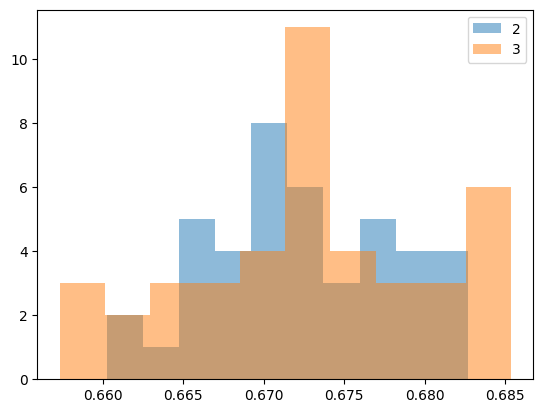

In [254]:
for value, group in grid_df.groupby('n_layers'):
    plt.hist(group['auc'], alpha = 0.5, label = str(value))
plt.legend()

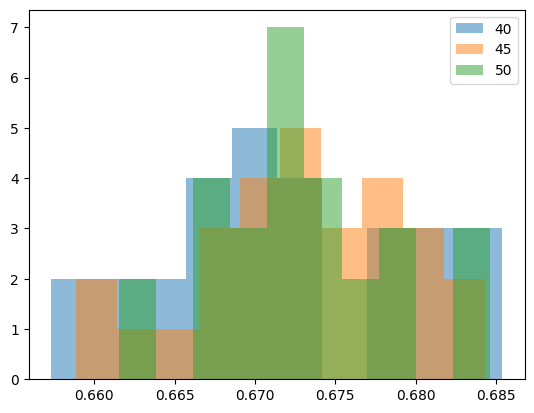

In [255]:
for value, group in grid_df.groupby('n_hidden'):
    plt.hist(group['auc'], alpha = 0.5, label = str(value))
plt.legend()

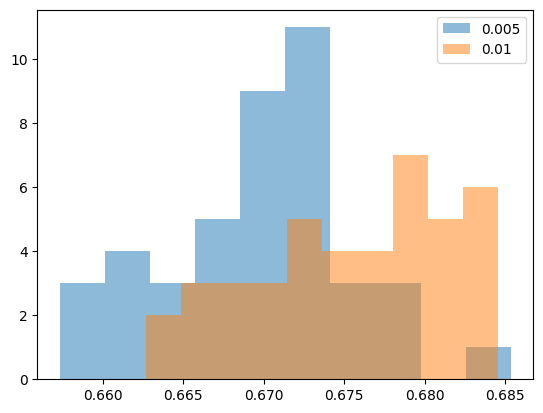

In [256]:
for value, group in grid_df.groupby('eta'):
    plt.hist(group['auc'], alpha = 0.5, label = str(value))
plt.legend()

In [257]:
grid_df.groupby(['n_layers','n_hidden'])['auc'].describe().sort_values('mean', ascending = False)

count      mean       std       min       25%       50%  \
n_layers n_hidden                                                            
2        45         14.0  0.673953  0.004177  0.668551  0.671039  0.673082   
3        50         14.0  0.673691  0.005468  0.663344  0.671998  0.673081   
         40         14.0  0.672982  0.009086  0.657325  0.668863  0.673046   
2        50         14.0  0.672418  0.005962  0.661562  0.667690  0.671802   
3        45         14.0  0.671882  0.008066  0.658869  0.665827  0.673302   
2        40         14.0  0.670810  0.006759  0.660260  0.666132  0.669742   

                        75%       max  
n_layers n_hidden                      
2        45        0.676754  0.681882  
3        50        0.675066  0.684599  
         40        0.681280  0.685366  
2        50        0.677832  0.682689  
3        45        0.678073  0.684297  
2        40        0.676248  0.682142

In [11]:
grid_best_model_paths = [os.path.join(model_dir, fname) for fname in grid_best_models]
#grid_df_sorted = pd.read_csv('../../data/lstm_grid.csv', index_col = 0)
#best_params = grid_df_sorted[['n_layers', 'n_hidden', 'dropout', 'eta']].iloc[0]
best_params = {'n_layers': 3, 'n_hidden': 40, 'dropout': 0.15, 'eta': 0.005}
model = SequenceModel(n_features = len(best_features),
                      n_classes = 2,
                      n_hidden = int(best_params['n_hidden']),
                      n_layers = int(best_params['n_layers']),
                      dropout = best_params['dropout']
                      )
lstmcv = LOWOCVLSTM(data = pro_frames_merge_trunc,
                features = best_features,
                target_col = 'rush_win',
                num_weeks = num_weeks,
                model = model)
lstmcv.infer_saved_models(saved_model_names = grid_best_model_paths, 
                         scaler = scaler,
                         model = model,
                         sequence_length = sequence_length)

In [21]:
lstmcv.get_auc(), lstmcv.get_f1(), lstmcv.get_avg_train_auc()

(0.6853661268681359, 0.5288221880468791, 0.7554231957629252)

In [22]:
lstmcv.get_scores_by_frame('frame_from_overlap')

,count,pred,prob,f1_score,auc_score
frame_from_overlap,,,,,
-22,36,0.444444,0.496312,0.307692,0.542308
-21,93,0.526882,0.500654,0.512821,0.612608
-20,157,0.471338,0.493697,0.471545,0.589380
-19,232,0.409483,0.485212,0.436364,0.606437
-18,329,0.422492,0.480979,0.493927,0.630761
-17,440,0.443182,0.480872,0.481375,0.615952
-16,567,0.451499,0.483115,0.470330,0.599806
-15,664,0.462349,0.485030,0.465291,0.597264
-14,754,0.482759,0.487740,0.469453,0.585553


In [25]:
lstm_probs = json.dumps([float(prob) for prob in lstmcv.probs])
with open(os.path.join(json_dir, '/lstm_probs.json'), 'w') as outfile:
    outfile.write(lstm_probs)